# Section A.2 : Conv Approximation

In [3]:
# Now you can import modules from this directory
import torch
import os
from src.plotter import EigenvectorPlotter
from src.heist import load_model
import imageio
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#some helper functions
def make_gif_dataset(dataset, image_path = "dataset.png"):
    frames = []
    for i in range(len(dataset)):
        frames.append(dataset[i].render(mode='rgb_array'))
    imageio.mimsave(image_path, frames, fps=2)

def top_activating_image_segments(filter_matrix, input_dataset, padding=3):
    # Ensure the filter matrix is a PyTorch tensor and is 7x7
    if not isinstance(filter_matrix, torch.Tensor):
        filter_matrix = torch.tensor(filter_matrix, dtype=torch.float32)

    # Ensure filter dimensions are correct for broadcasting over channels
    if filter_matrix.ndim == 2:
        filter_matrix = filter_matrix.unsqueeze(0).repeat(3, 1, 1)  # Replicate the 7x7 filter for each channel

    padded_images = [F.pad(img, (padding, padding, padding, padding), mode='constant', value=0) for img in input_dataset]

    activation_dataset = []

    for img in padded_images:
        c, h, w = img.shape
        activation_map = torch.zeros((h - 2 * padding, w - 2 * padding))

        for i in range(h - 2 * padding):
            for j in range(w - 2 * padding):
                # Extract 7x7 segment for each channel
                segment = img[:, i:i+7, j:j+7]
                # Apply the filter to the segment for each channel
                filtered_segment = segment * filter_matrix
                # Compute the norm of activations across channels
                activation_value = torch.norm(filtered_segment.sum(dim=(1, 2)))
                # Store the activation value
                activation_map[i, j] = activation_value

        # Store the activation map and corresponding padded image
        activation_dataset.append((activation_map, img))

    return activation_dataset

def visualize_top_segments(activation_dataset, num_segments=10):
    for activation_map, img in activation_dataset:
        # Flatten the activation map to sort and find top segments
        top_indices = torch.topk(activation_map.view(-1), k=num_segments).indices
        fig, axes = plt.subplots(1, num_segments, figsize=(20, 2))

        for idx, ax in zip(top_indices, axes.flatten()):
            i, j = divmod(idx.item(), activation_map.shape[1])
            # Extract the corresponding top segment
            segment = img[:, i:i+7, j:j+7]
            segment_img = segment.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
            ax.imshow(segment_img)
            ax.set_title(f"Activation: {activation_map[i, j]:.2f}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()
#visualise images in rgb format
def visualize_images(images, title="Image"):
    """Helper function to visualize images."""
    num_images = len(images)
    if num_images == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(images[0].permute(1, 2, 0))  # Convert CxHxW to HxWxC
        ax.set_title(f"{title} 1")
        ax.axis('off')
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
        for i, img in enumerate(images):
            if num_images > 1:
                axs[i].imshow(img.permute(1, 2, 0))  # Convert CxHxW to HxWxC
                axs[i].set_title(f"{title} {i+1}")
                axs[i].axis('off')
            else:
                axs.imshow(img.permute(1, 2, 0))
                axs.set_title(f"{title} {i+1}")
                axs.axis('off')
    plt.show()

def visualize_top_segments_with_full_images(activation_dataset, num_segments=10):
    # List to store activation values, corresponding segments, and the full image
    all_segments = []
    
    for activation_map, img in activation_dataset:
        # Flatten the activation map to sort and find top segments later
        for idx in activation_map.view(-1).argsort(descending=True)[:num_segments]:
            i, j = divmod(idx.item(), activation_map.shape[1])
            # Extract the corresponding segment
            segment = img[:, i:i+7, j:j+7]
            activation_value = activation_map[i, j].item()
            all_segments.append((activation_value, segment, img))
    
    # Sort all collected segments by activation value in descending order
    all_segments.sort(reverse=True, key=lambda x: x[0])
    
    # Select the top k segments
    top_segments = all_segments[:num_segments]
    
    # Visualization
    fig, axes = plt.subplots(2, num_segments, figsize=(20, 5))  # 2 rows: one for segments, one for full images
    for idx, (activation, segment, full_img) in enumerate(top_segments):
        segment_img = segment.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
        full_img_disp = full_img.permute(1, 2, 0).numpy()  # Convert full image to HWC format
        
        # Display the segment
        ax_segment = axes[0, idx]
        ax_segment.imshow(segment_img)
        ax_segment.set_title(f"Activation: {activation:.2f}")
        ax_segment.axis('off')
        
        # Display the full image
        ax_full_img = axes[1, idx]
        ax_full_img.imshow(full_img_disp)
        ax_full_img.set_title("Full Image")
        ax_full_img.axis('off')

    plt.tight_layout()
    plt.show()
#this method visualises a list of filters
def visualise_list_filters(input_dataset, filters,padding,num_segments):
    for filter_matrix in filters:
        activation_dataset= top_activating_image_segments(filter_matrix, input_dataset, padding)
        visualize_top_segments_with_full_images(activation_dataset, num_segments)
        


# Loading the model and printing the state dictionary of the model

In [3]:
model_dir = '/mnt/ssd-1/mechinterp/narmeen/train-procgen-pfrl/checkpoints_bimpala_kernel7/heist/nlev_100000_easy/pistachio/trained/'
model_path = os.path.join(model_dir, 'bimpala_without_dropout_10501.0.pt')
model =load_model(model_path,7)
print(model)

for k in model.state_dict():
    print(k)
state_dict = model.state_dict()

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/src/heist.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model

Model loaded from /mnt/ssd-1/mechinterp/narmeen/train-procgen-pfrl/checkpoints_bimpala_kernel7/heist/nlev_100000_easy/pistachio/trained/bimpala_without_dropout_10501.0.pt
BimpalaCNN(
  (conv_seqs): ModuleList(
    (0): ConvSequence(
      (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
      (max_pool2d): MaxPool2d(kernel_size=7, stride=2, padding=3.0, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
        (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
        (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
        (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3.0, 3.0))
        (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding

# Computing the Bilinear Symmetric Matrix assuming that different Input Channels have the same activations.

In [7]:
#we start with the latest residual block and decompose the input channel interactions
#ignoring the biases for now

W = state_dict["conv_seqs.2.res_block1.conv0.weight"]
V = state_dict["conv_seqs.2.res_block1.conv1.weight"]
U = state_dict["conv_seqs.2.res_block1.conv2.weight"]

#print(W.shape, V.shape)
out_channels, in_channels, kernel_width, kernel_height = W.shape

W_flatten = torch.randn(out_channels,in_channels,kernel_width*kernel_height)
V_flatten = torch.randn(out_channels,in_channels,kernel_width*kernel_height)

for i in range(out_channels):
    #the filter corresponding to the ith output channel
    #shape is in_channel, kernel_width, kernel_height
    for in1 in range(in_channels):
        W_flatten[i,in1,:] = torch.flatten(W[i,in1,:])
        V_flatten[i,in1,:] = torch.flatten(V[i,in1,:])


#let's compute the channel interactions
W_channel_interactions = torch.zeros(out_channels,in_channels,in_channels,kernel_width* kernel_height,kernel_width*kernel_height)
W_summed_interactions = torch.zeros(out_channels, kernel_width*kernel_height, kernel_width*kernel_height)
for i in range(out_channels):
    for in1 in range(in_channels):
        for in2 in range(in_channels):
            W_channel_interactions[i,in1,in2,:,:]= torch.outer(W_flatten[i,in1,:].t(),V_flatten[i,in2,:])
            W_summed_interactions[i,:,:] += torch.outer(W_flatten[i,in1,:].t(),V_flatten[i,in2,:])
def display_random_channel_interactions():
#now we select a random output channel and input channel pair and we visualise the convolutions:
    for i in range(10):
        out_channel_index = torch.randint(0,out_channels,(1,))[0]

        in1_index, in2_index =torch.randint(0, in_channels, (2,)) 

        matrix = W_channel_interactions[out_channel_index,in1_index, in2_index,:]
        print(matrix.shape)
        plotter = EigenvectorPlotter(matrix, 7, out_channel_index ,in1_index,in2_index)
        plotter.plot()



# Plotting the Eigenfilters and Eigenvalues of the matrix calculated in the above section

torch.Size([49, 49])


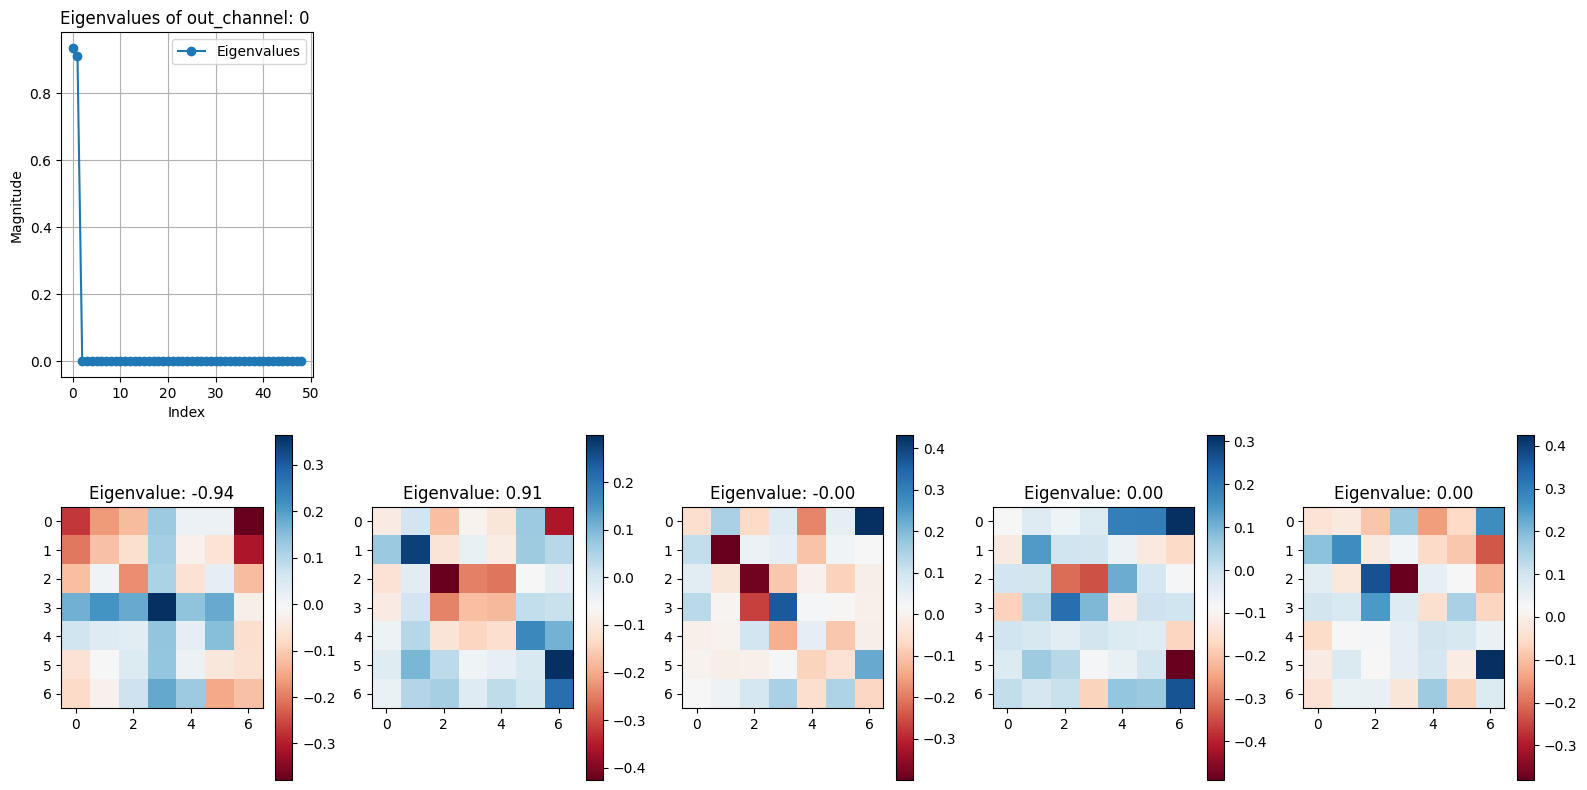

torch.Size([49, 49])


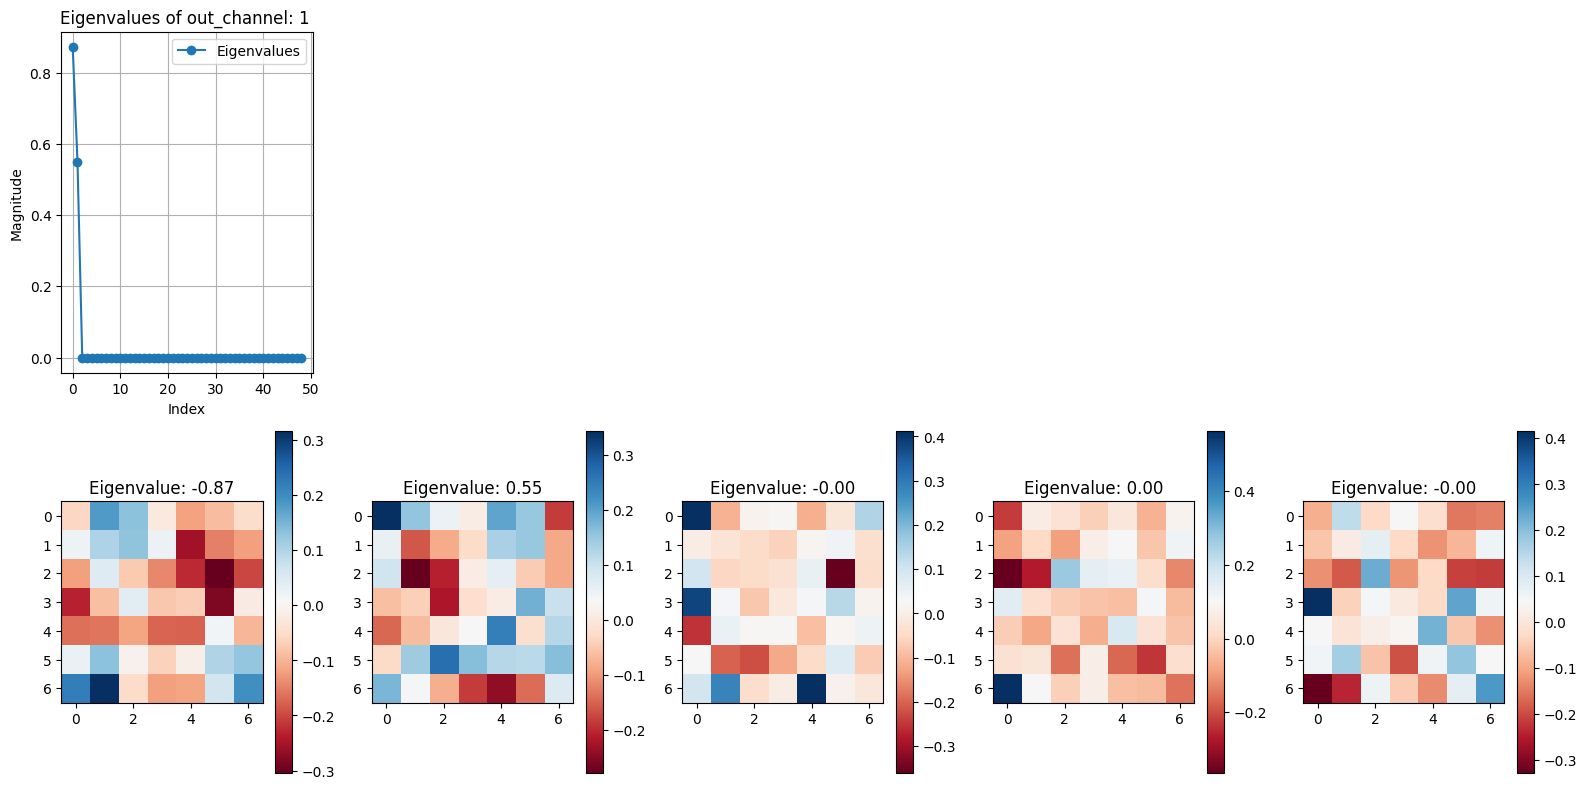

torch.Size([49, 49])


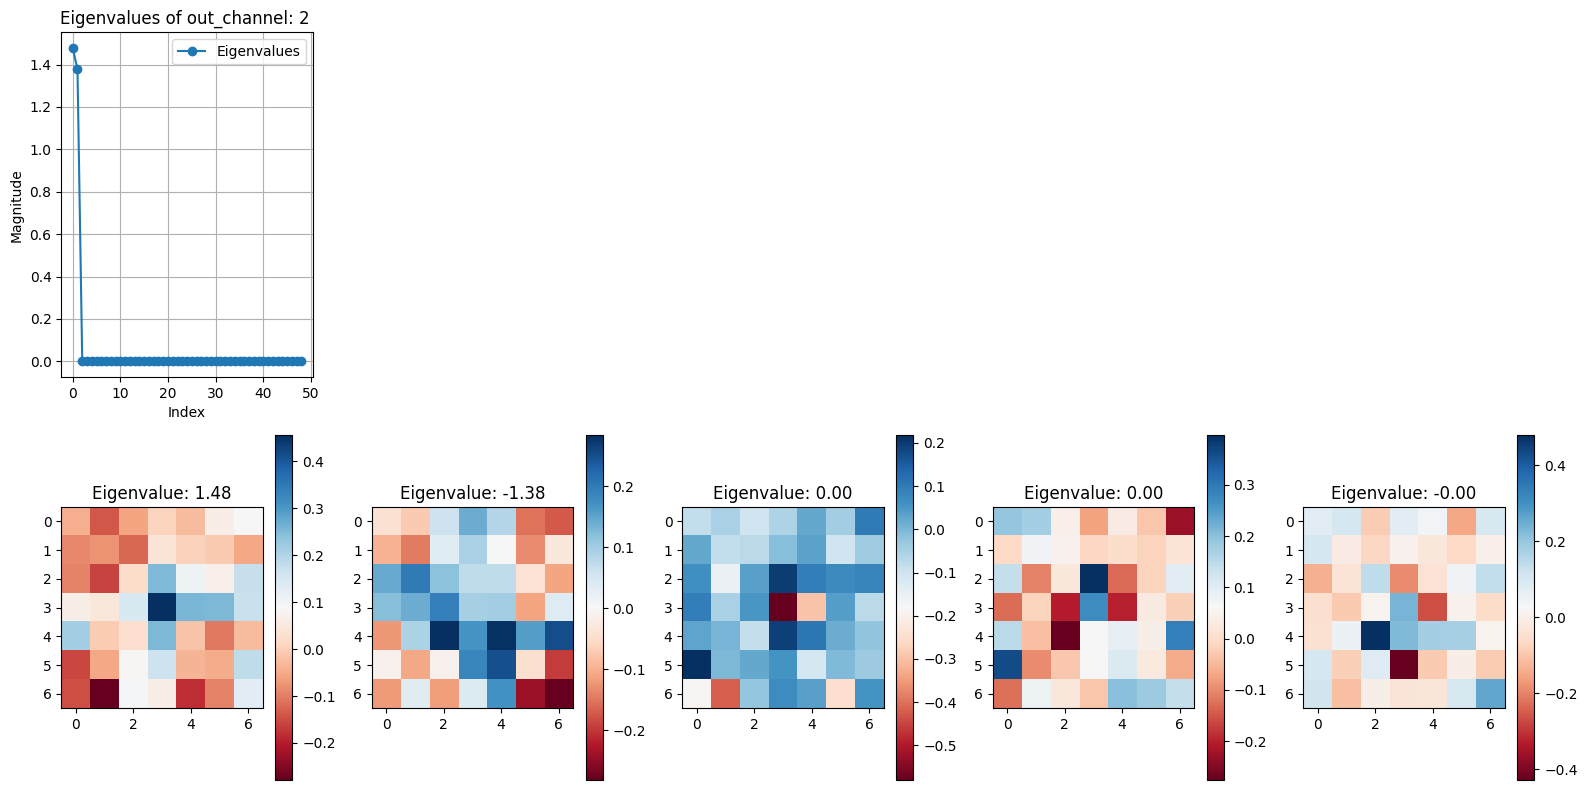

torch.Size([49, 49])


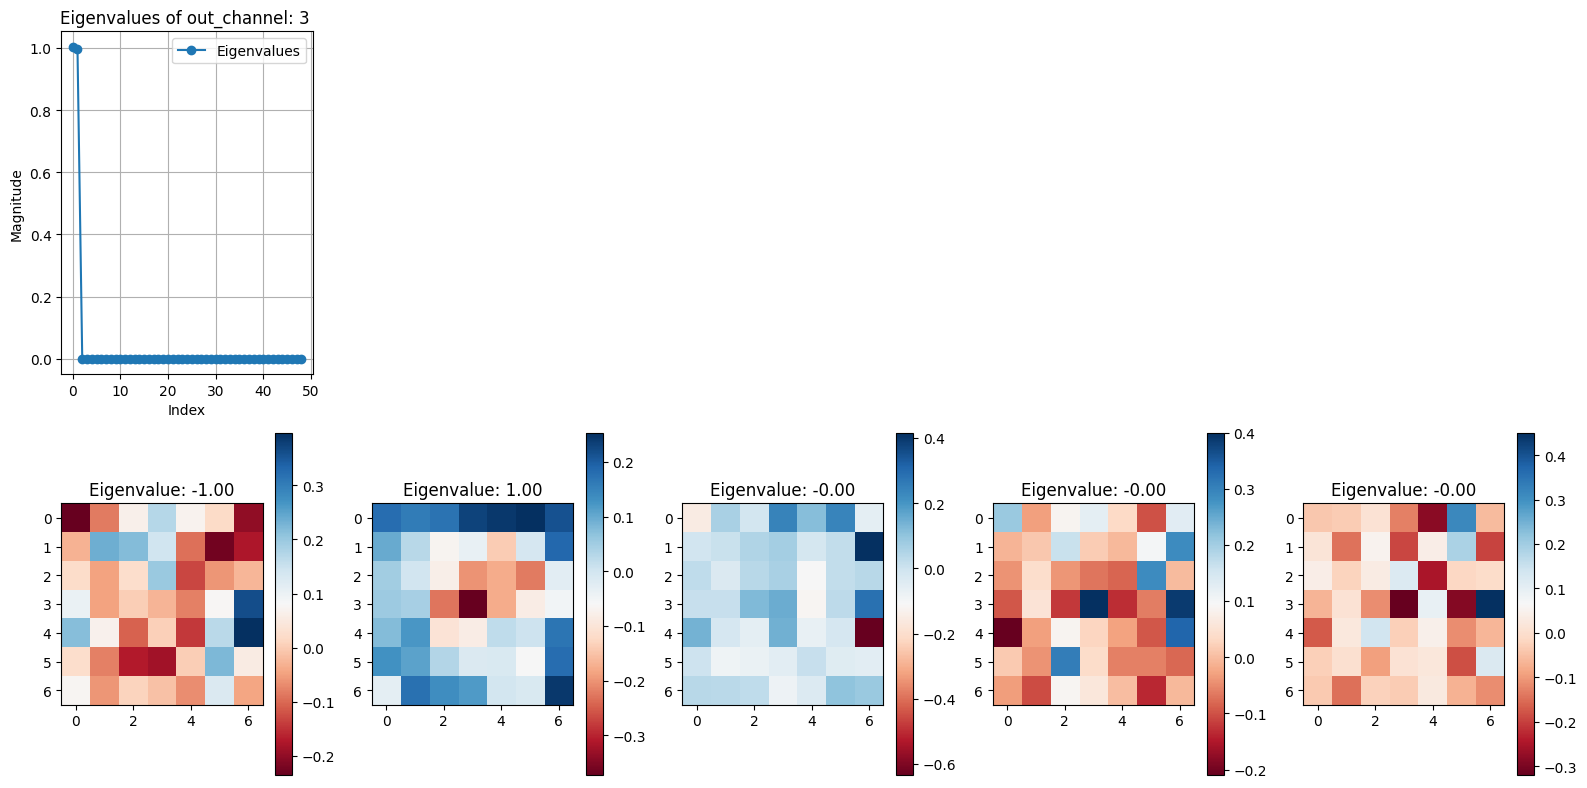

torch.Size([49, 49])


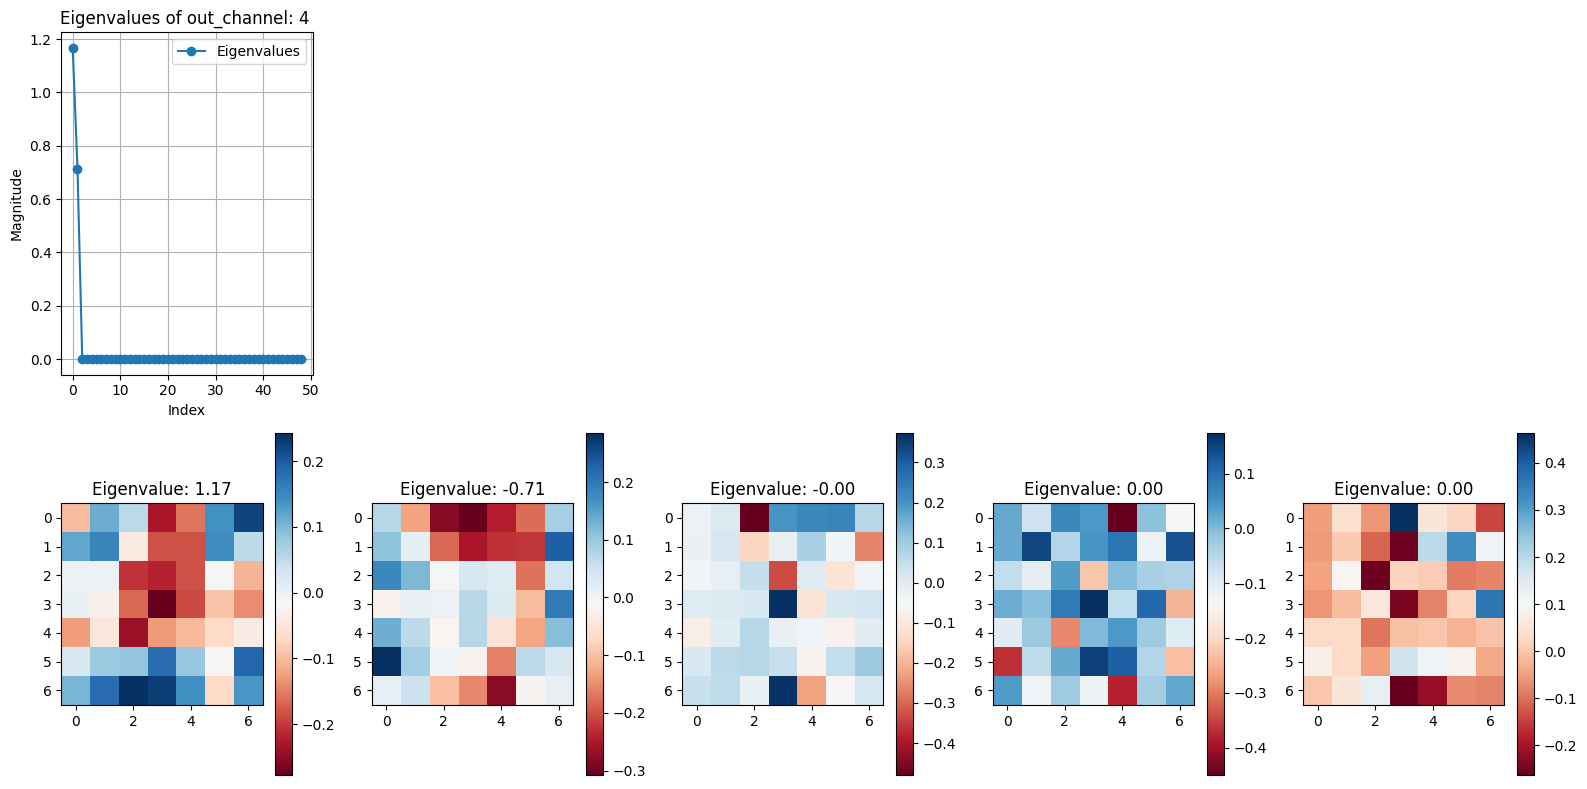

torch.Size([49, 49])


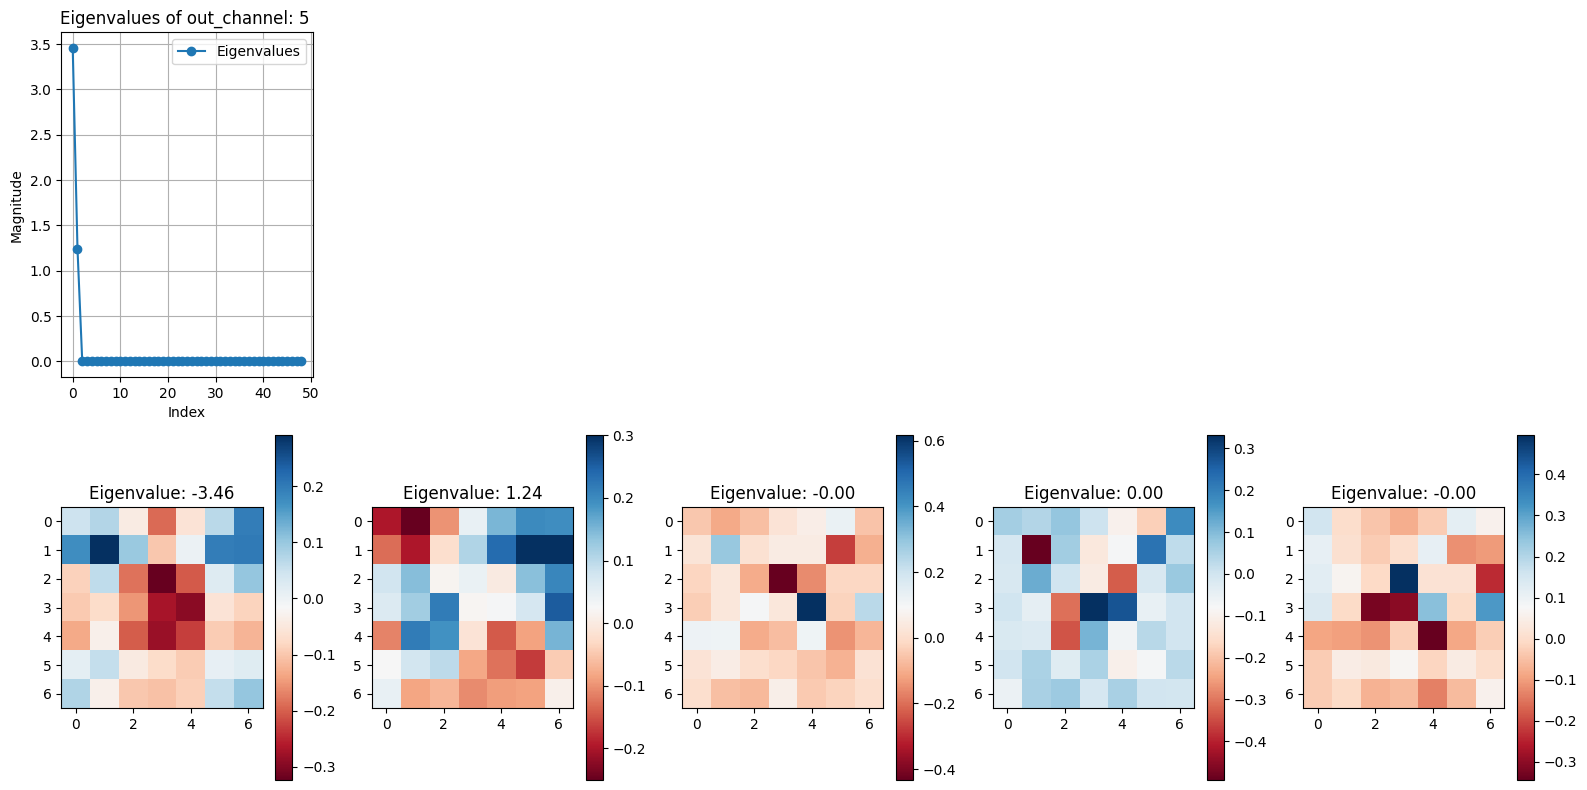

torch.Size([49, 49])


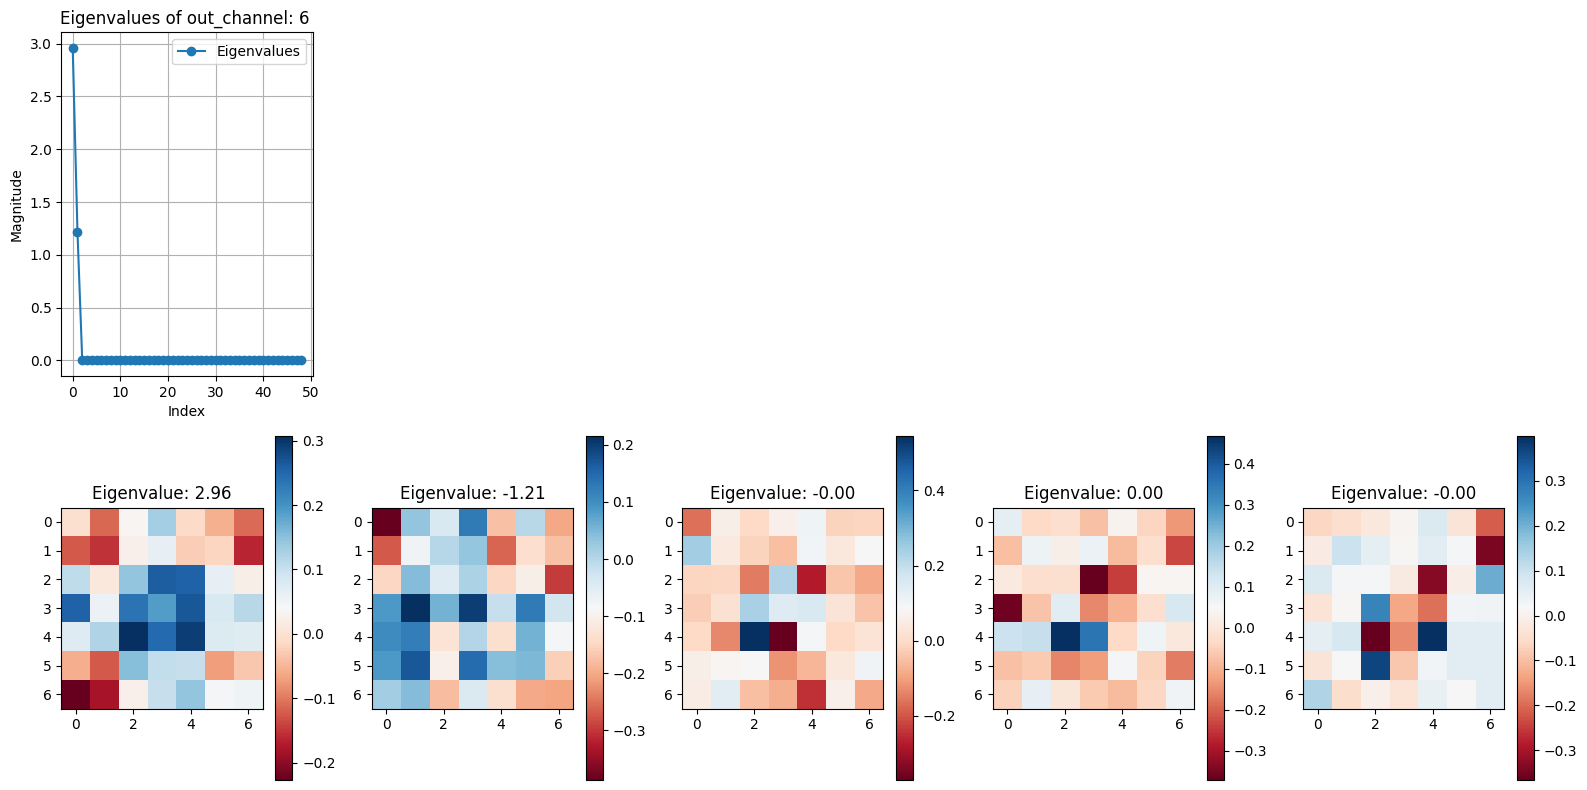

torch.Size([49, 49])


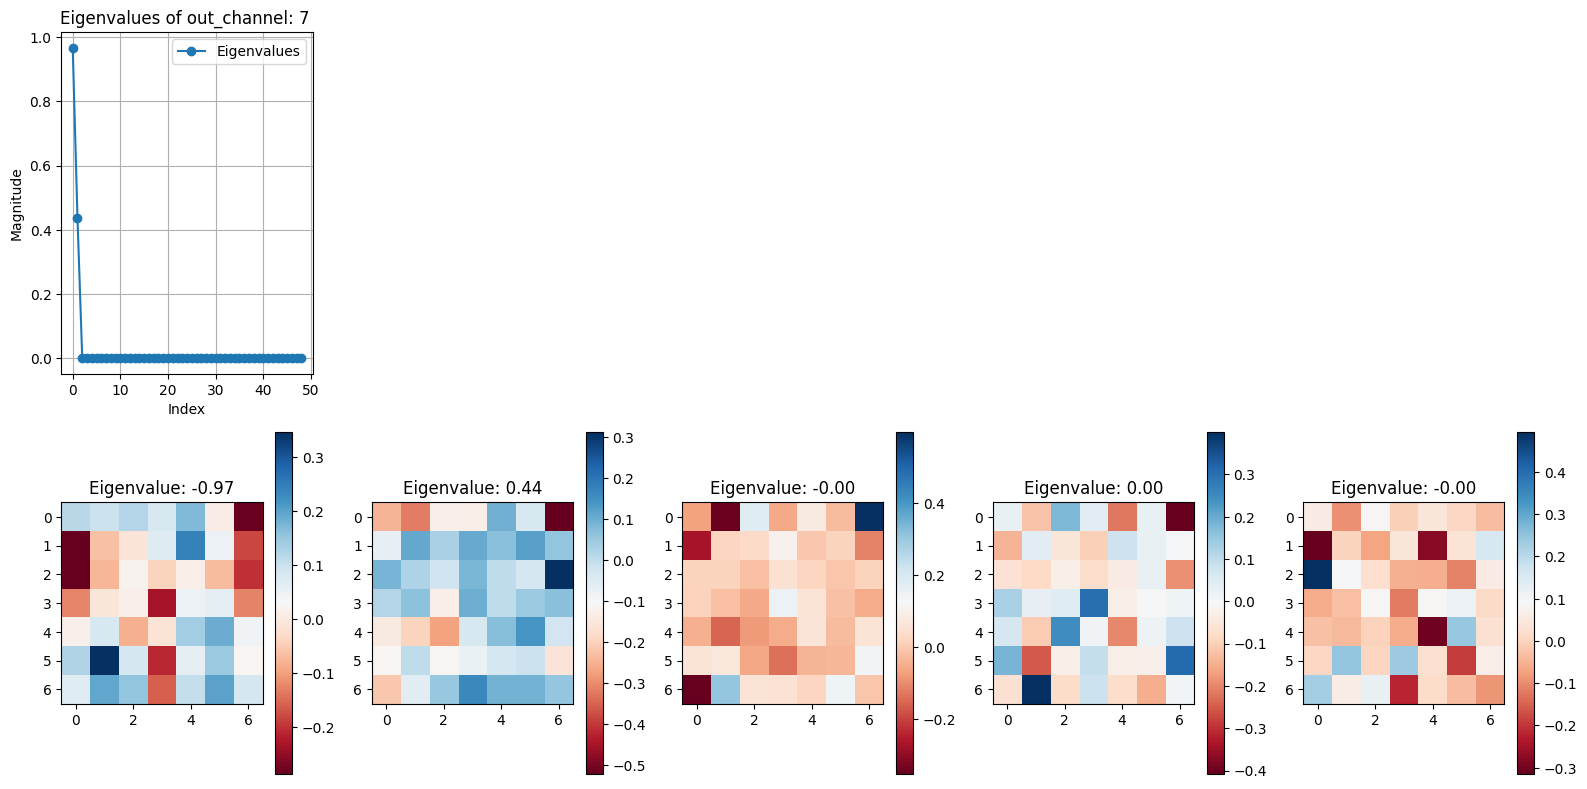

torch.Size([49, 49])


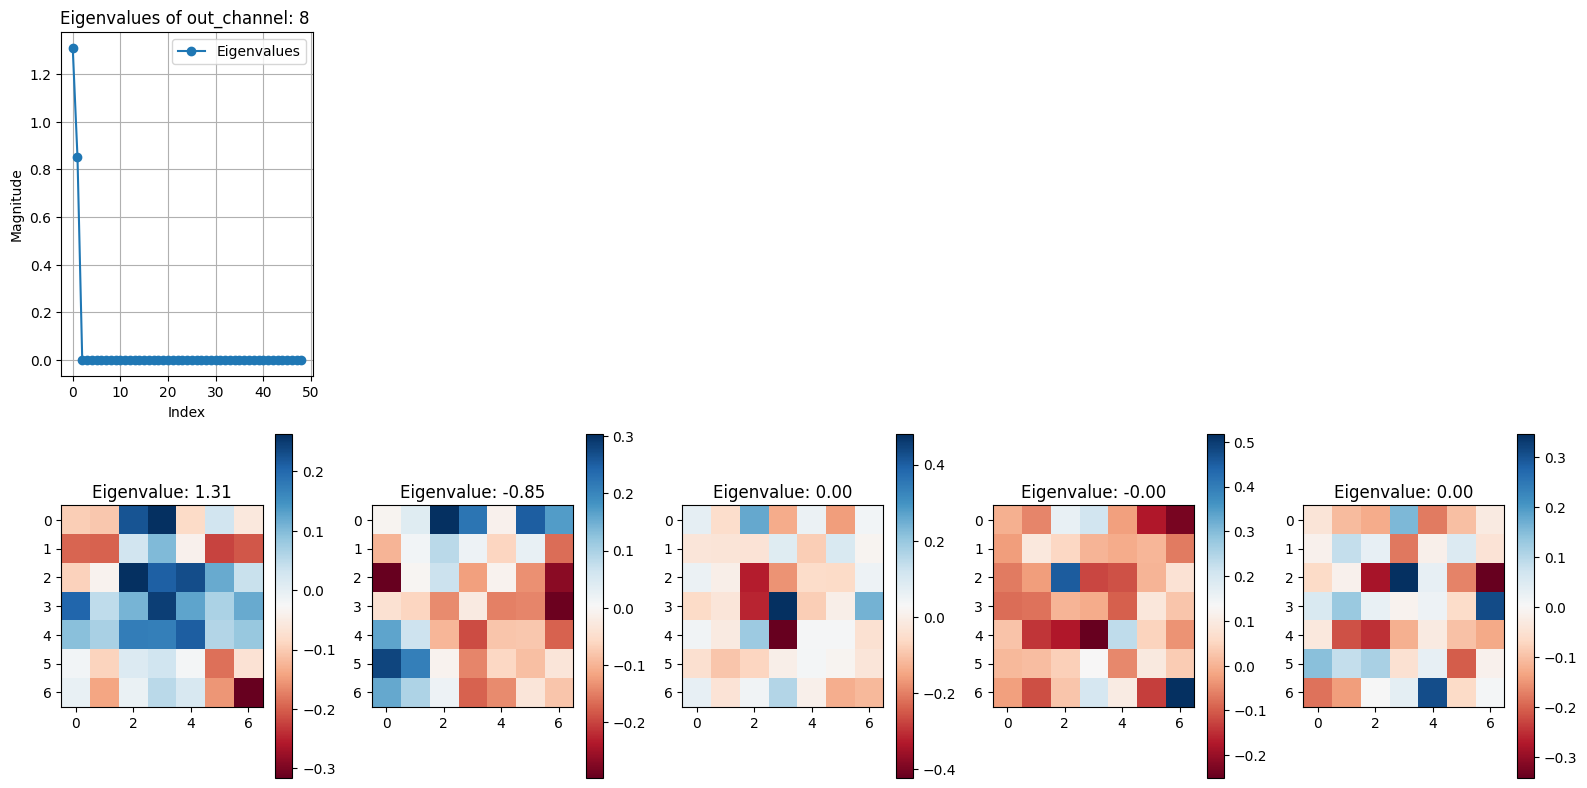

torch.Size([49, 49])


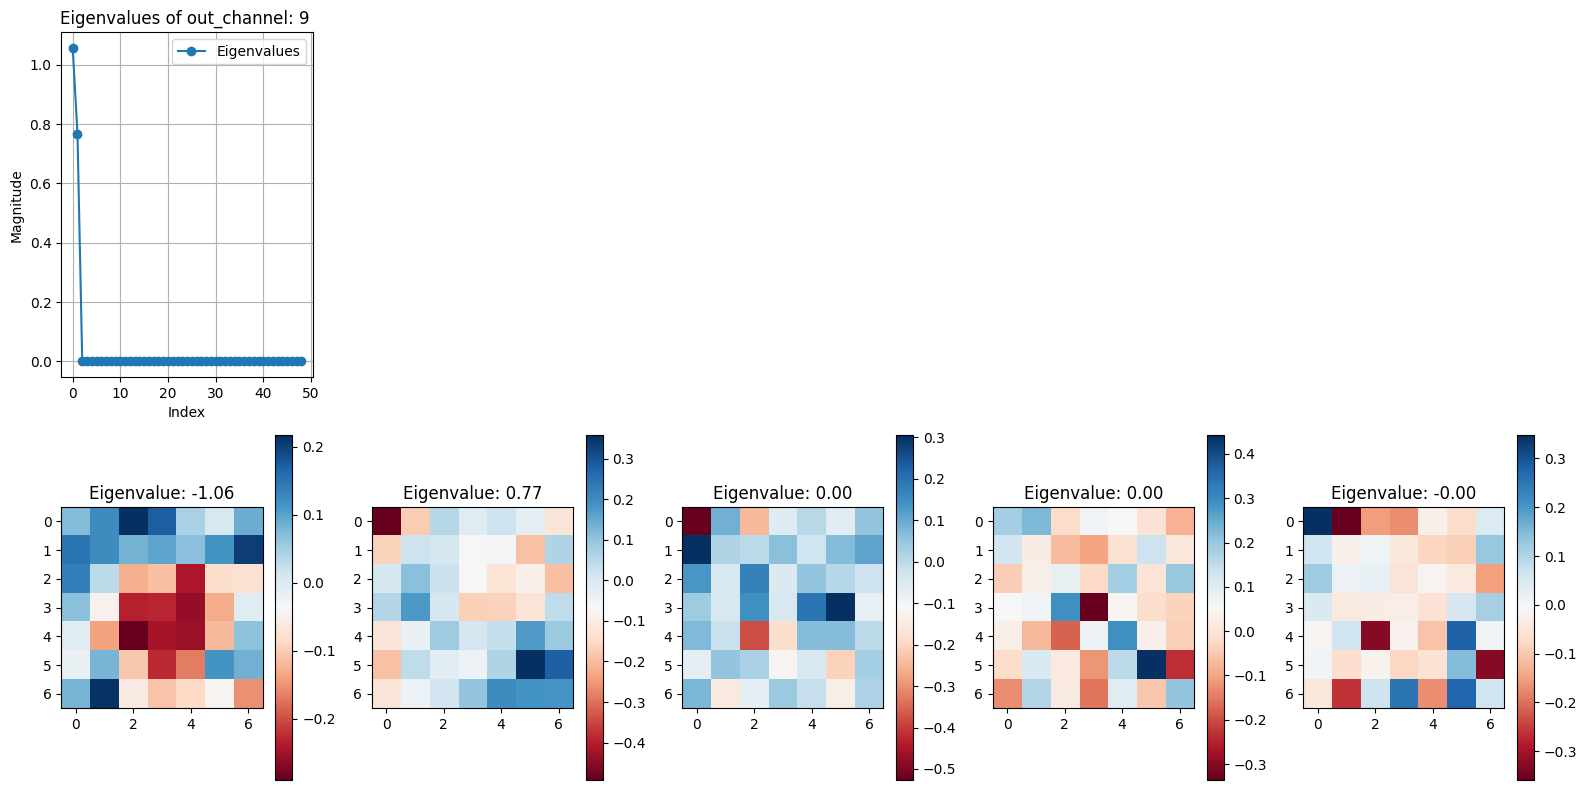

torch.Size([49, 49])


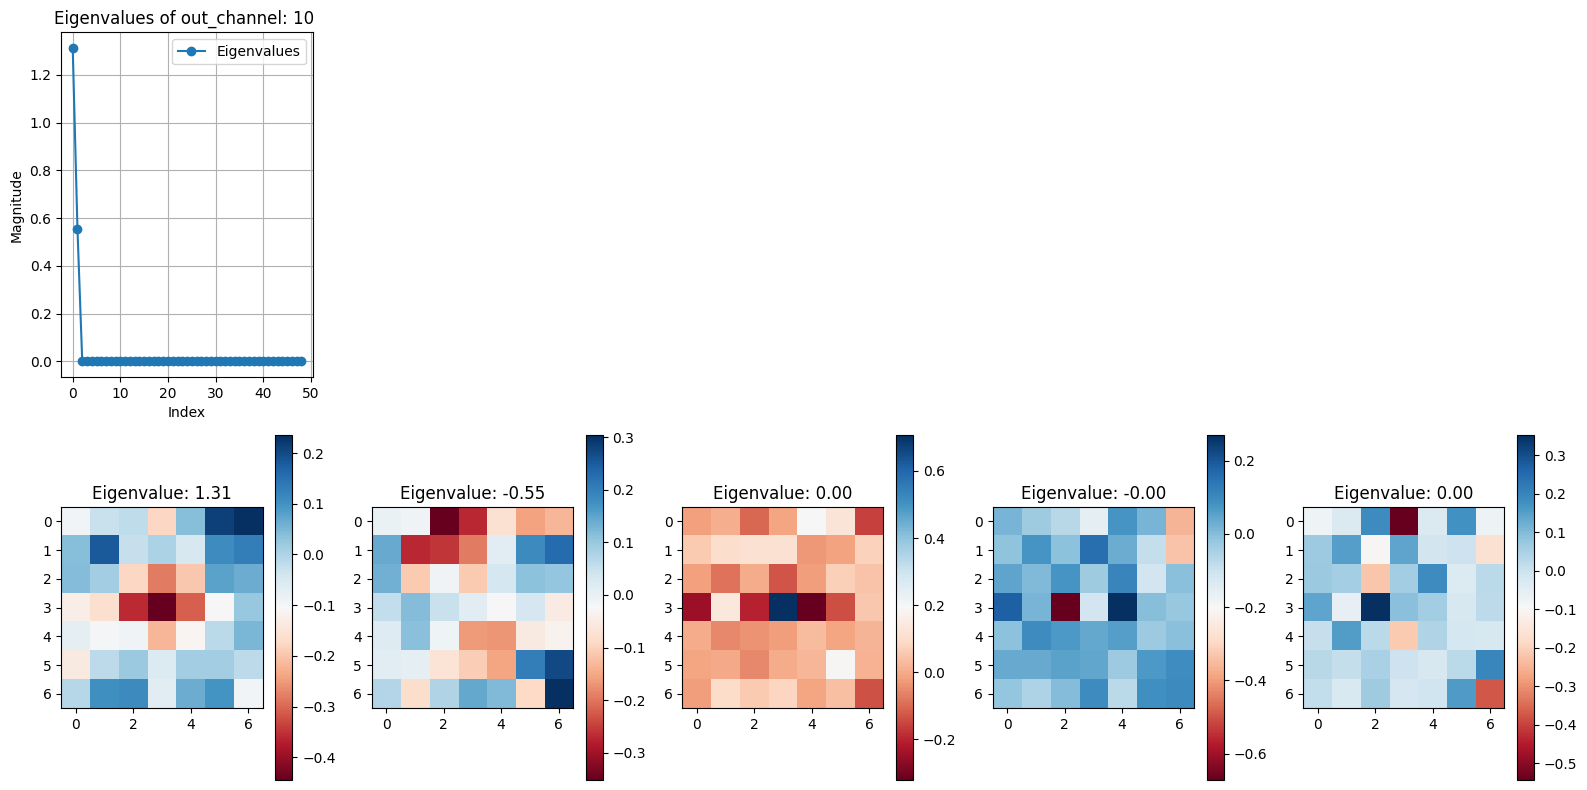

torch.Size([49, 49])


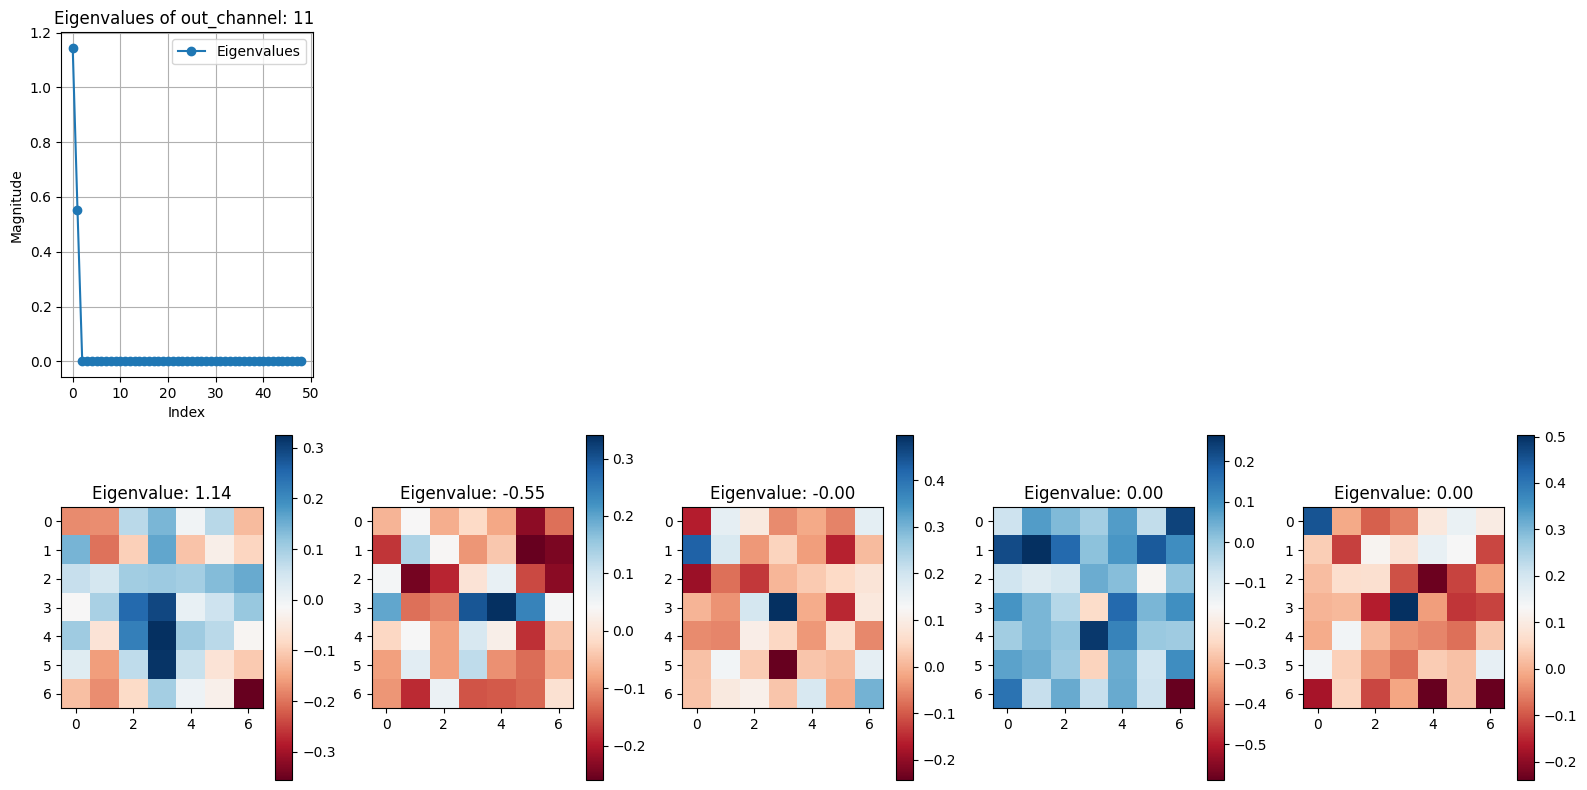

torch.Size([49, 49])


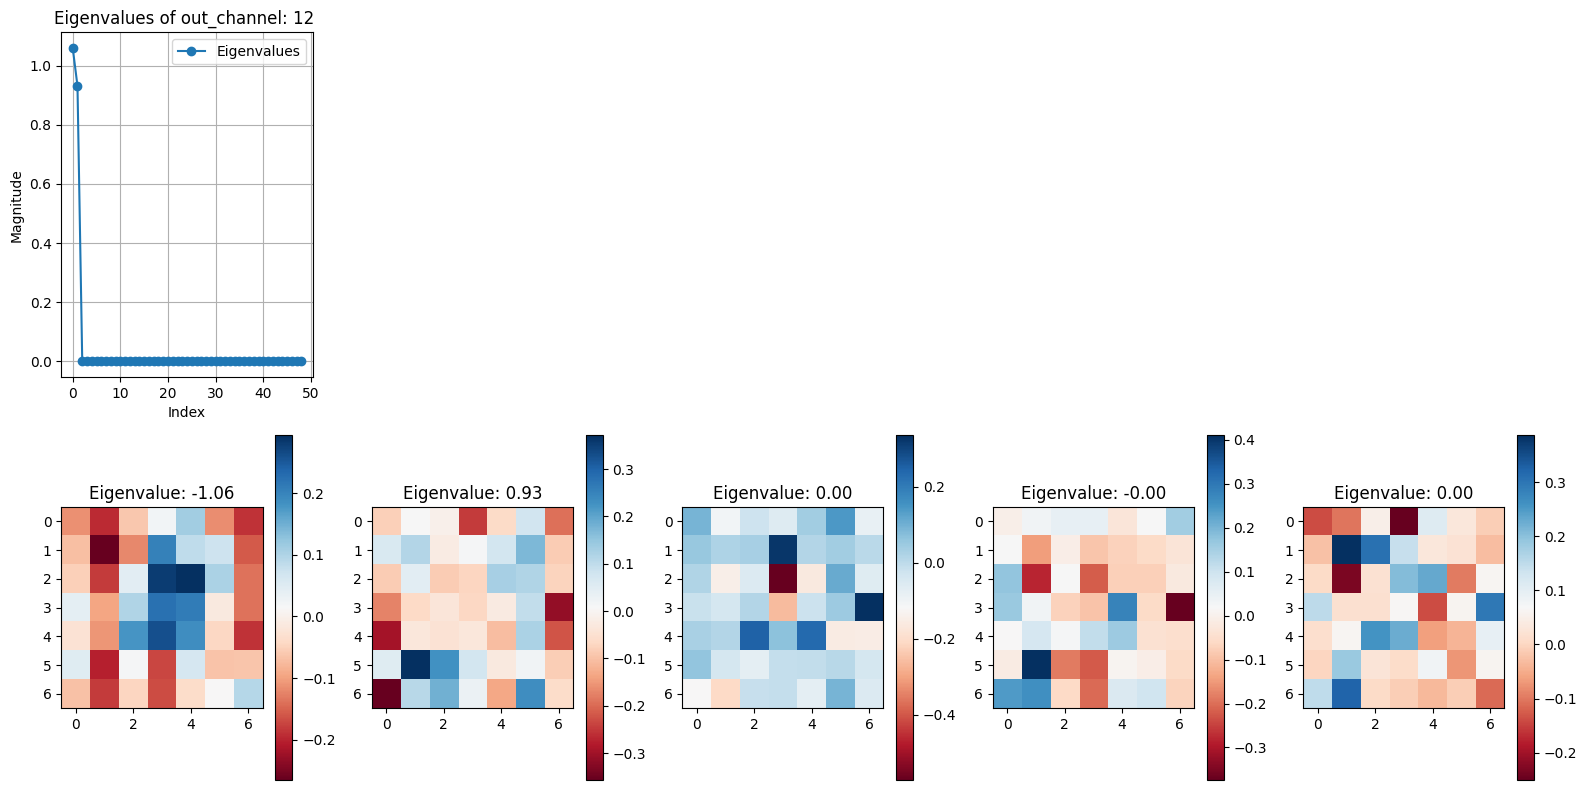

torch.Size([49, 49])


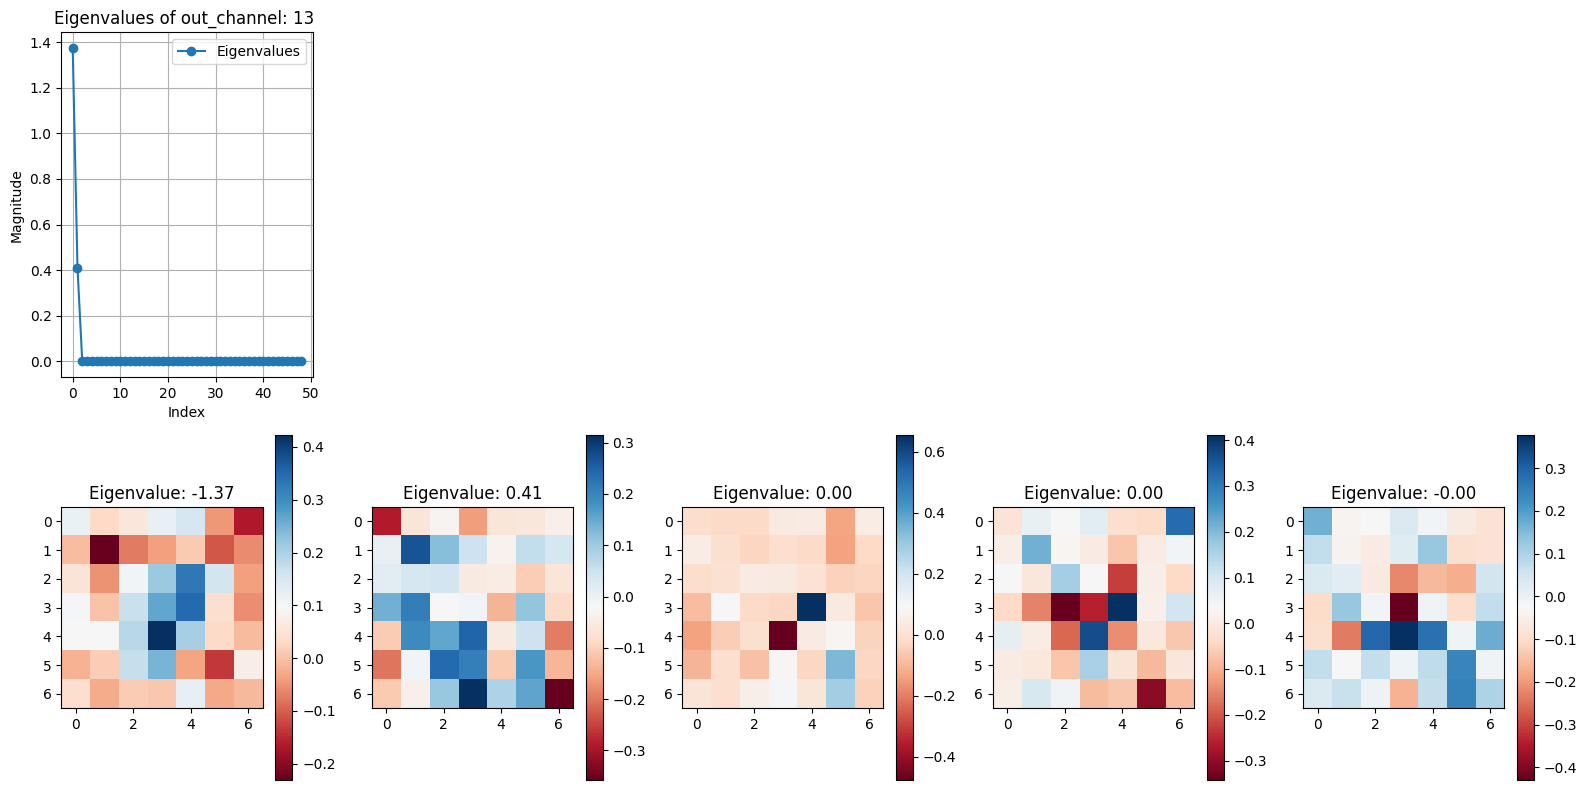

torch.Size([49, 49])


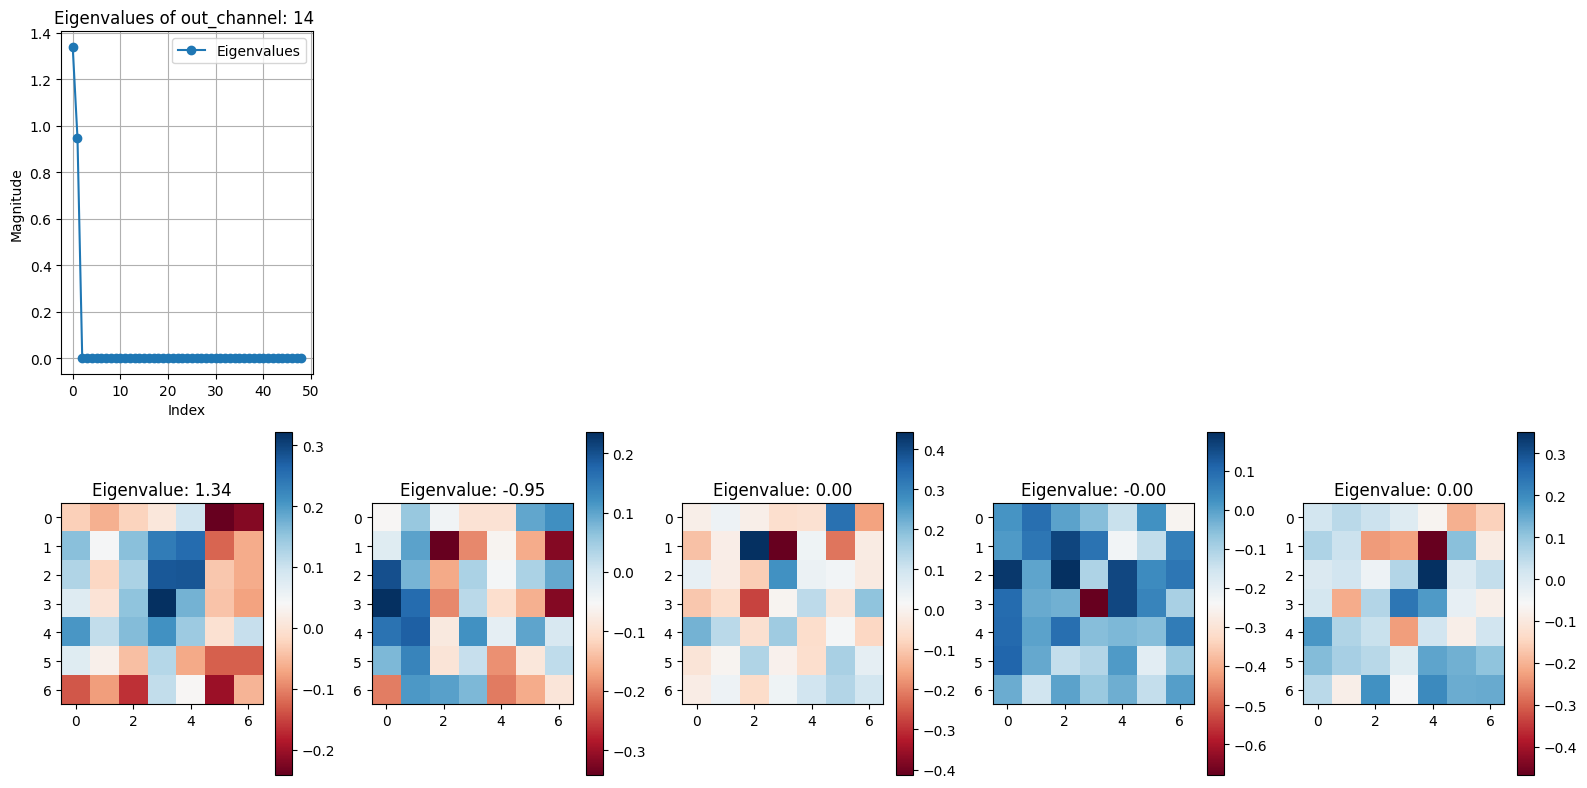

torch.Size([49, 49])


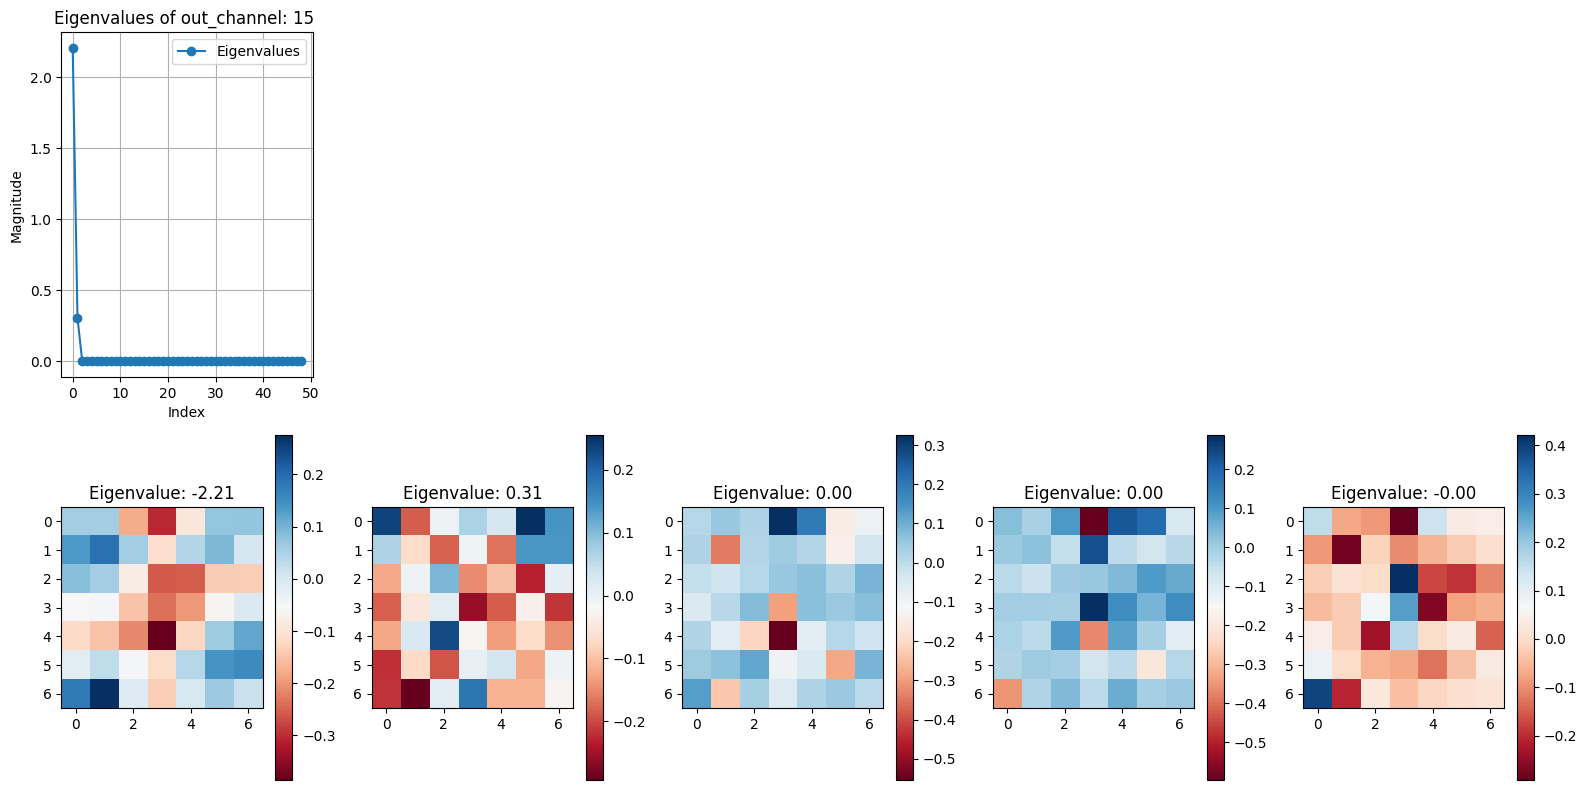

torch.Size([49, 49])


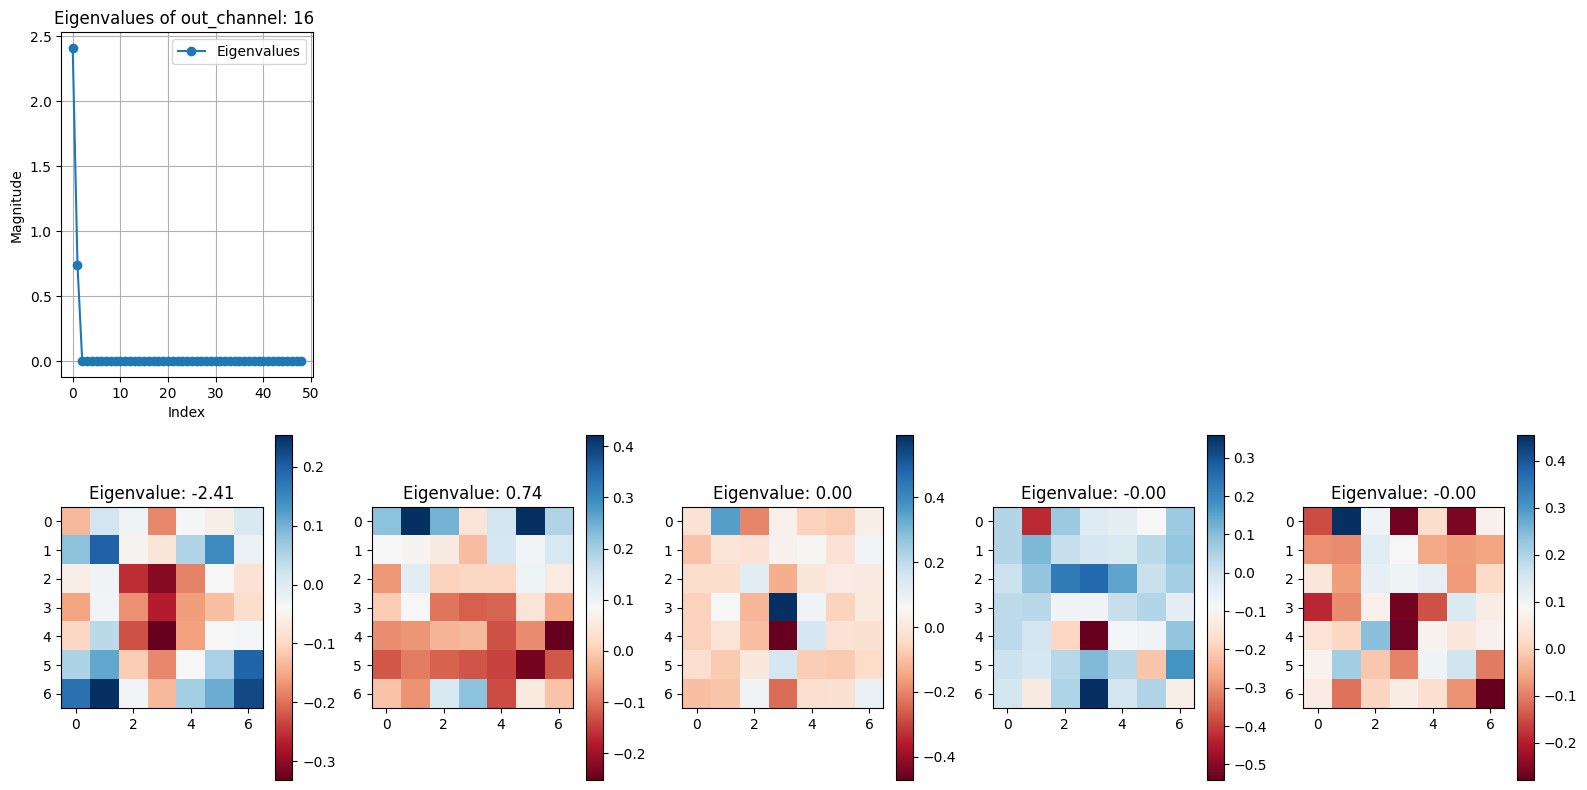

torch.Size([49, 49])


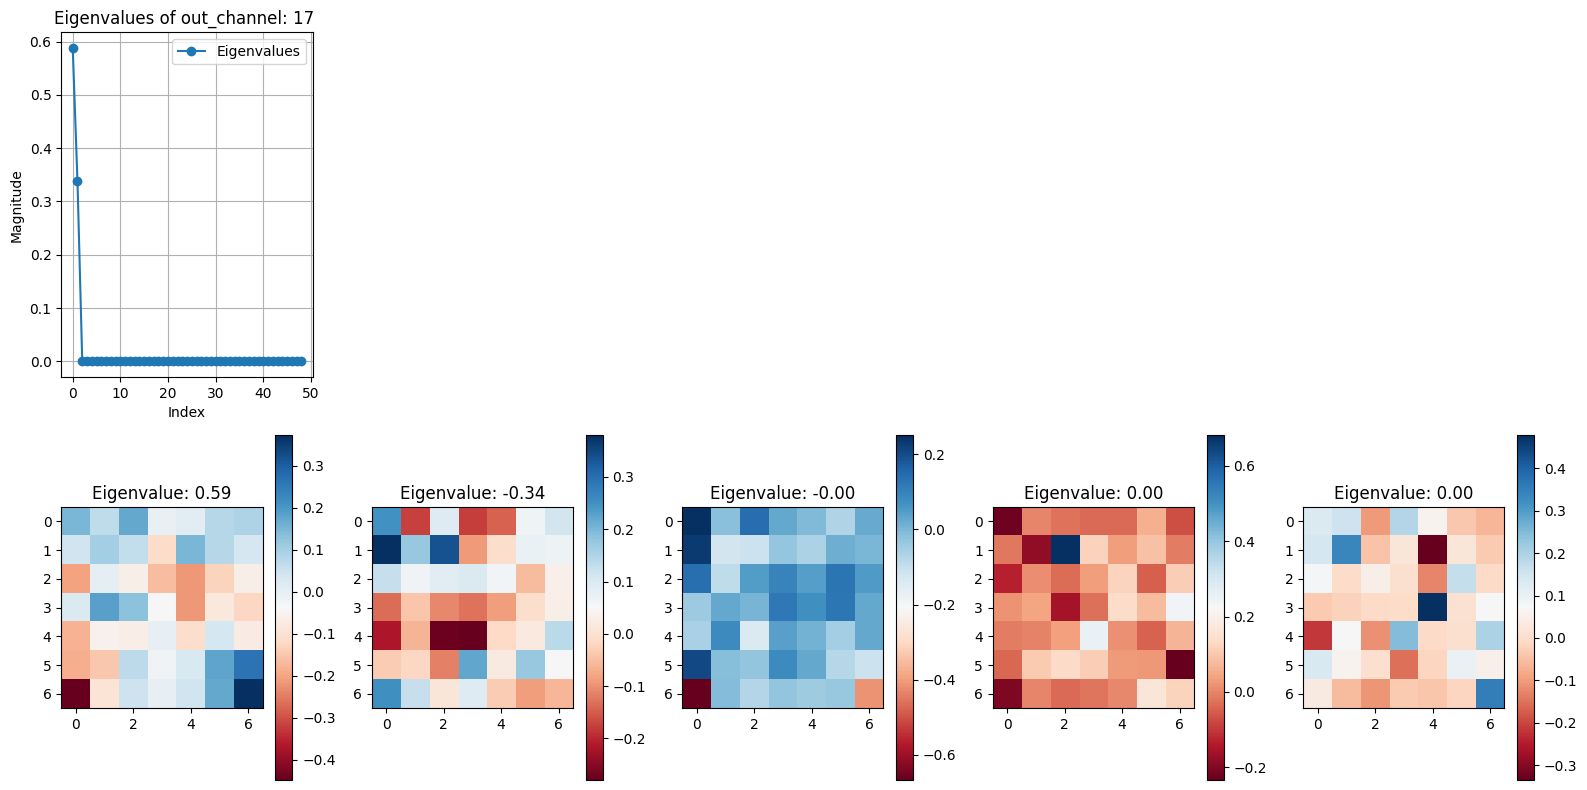

torch.Size([49, 49])


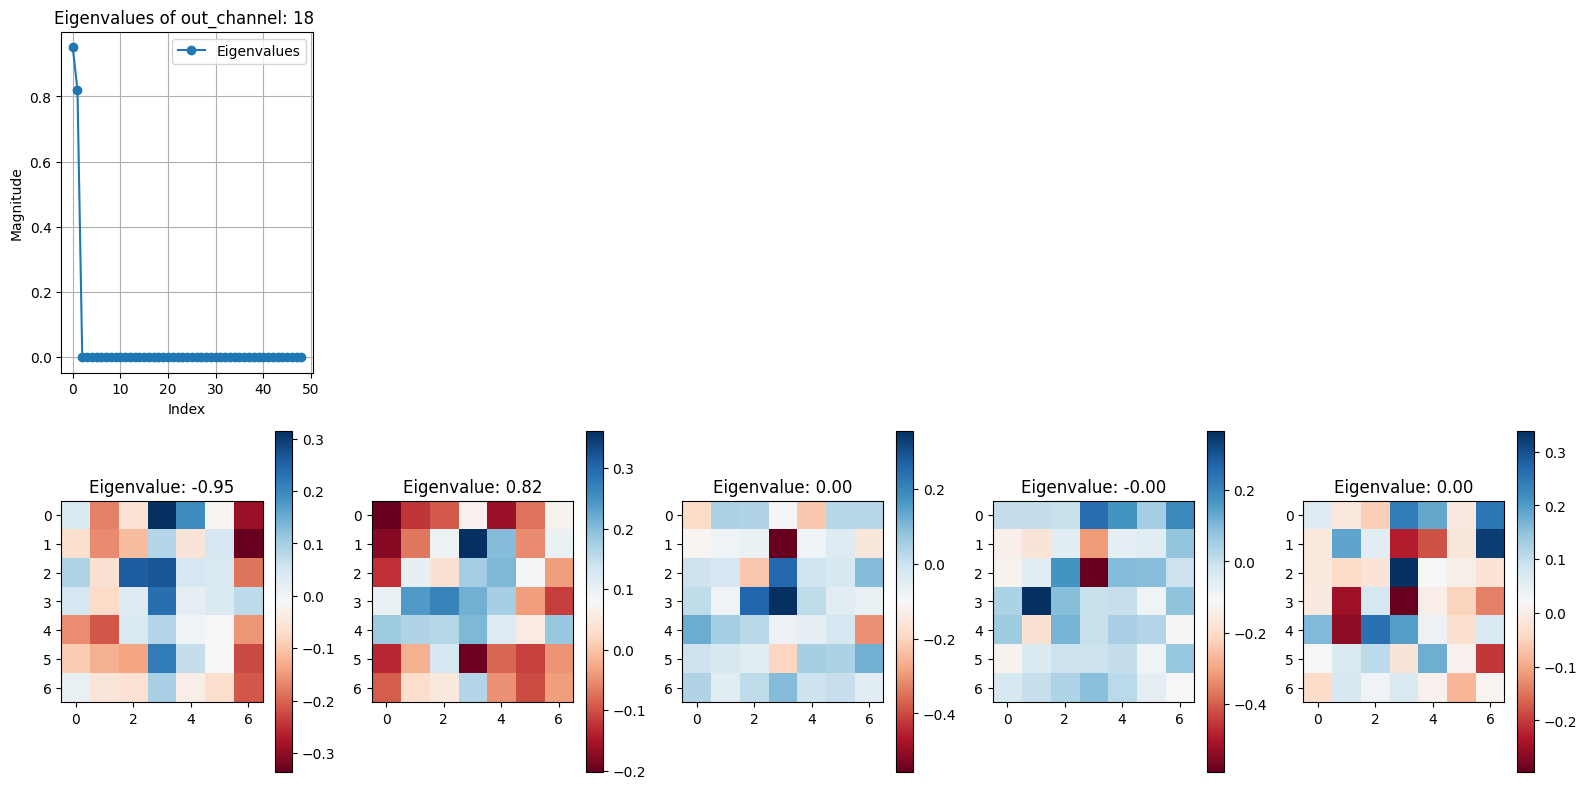

torch.Size([49, 49])


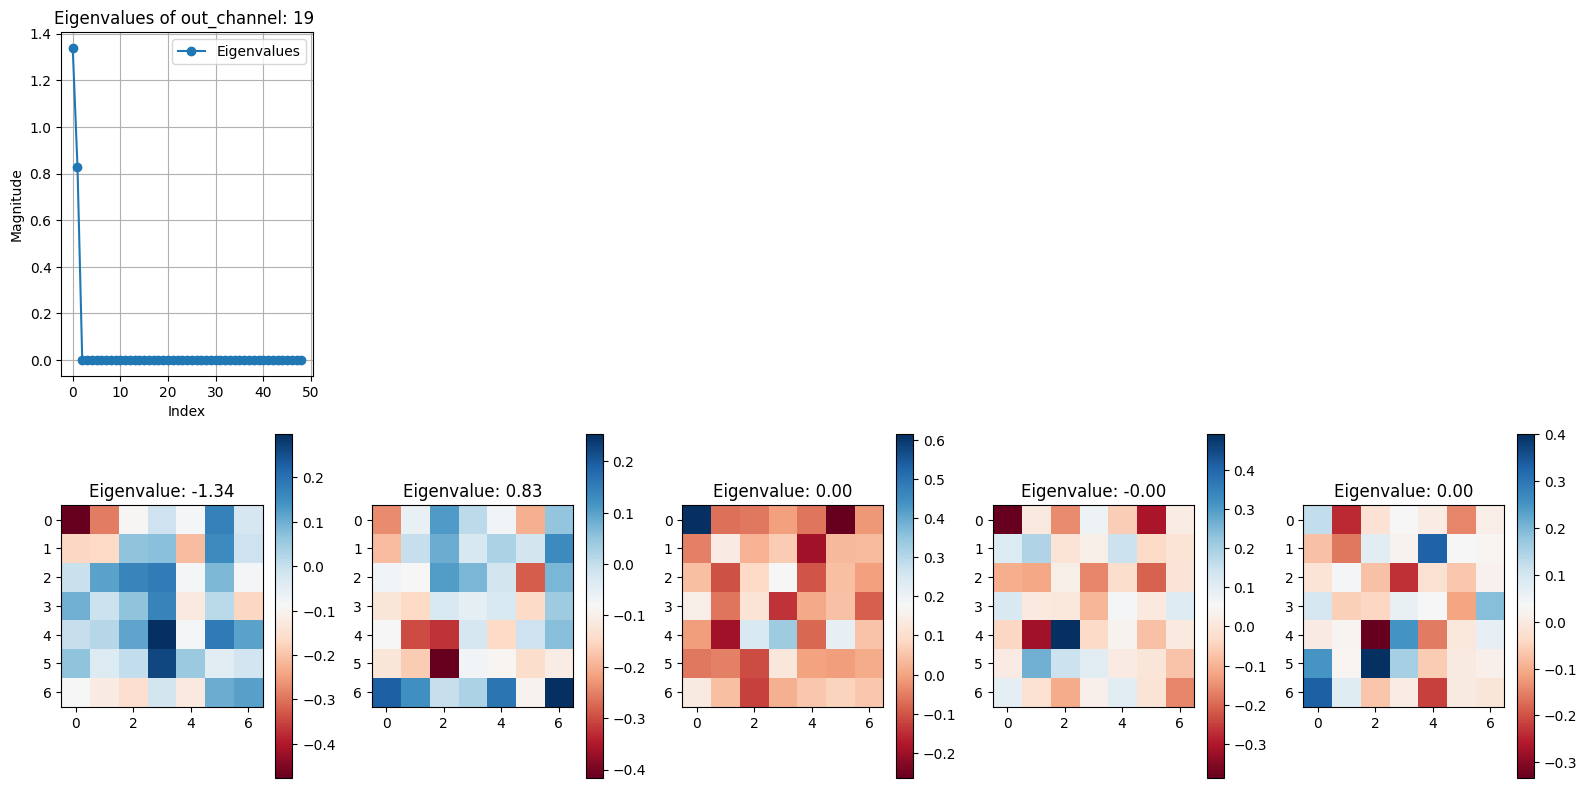

torch.Size([49, 49])


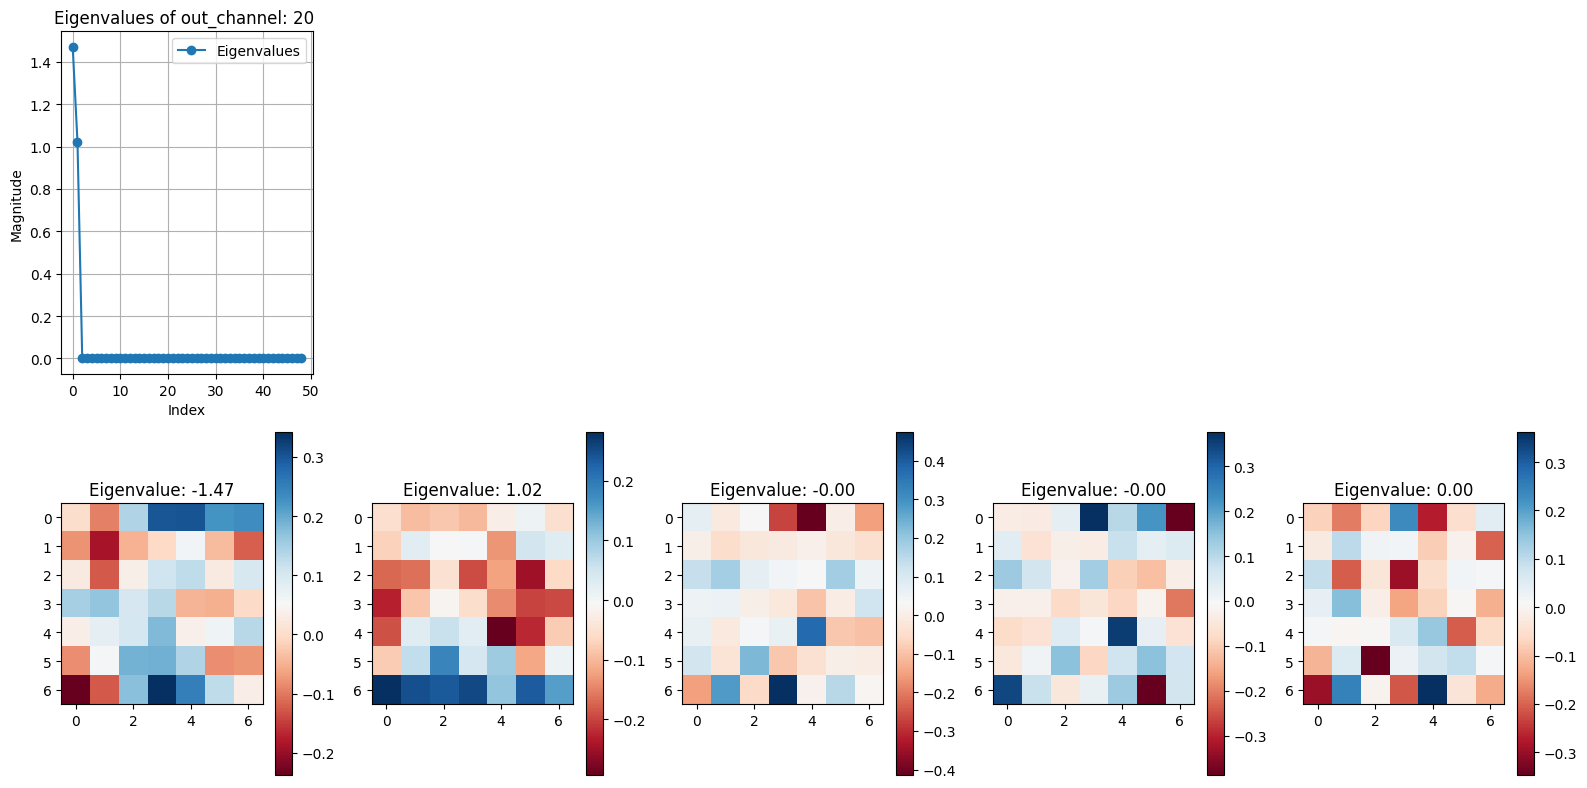

torch.Size([49, 49])


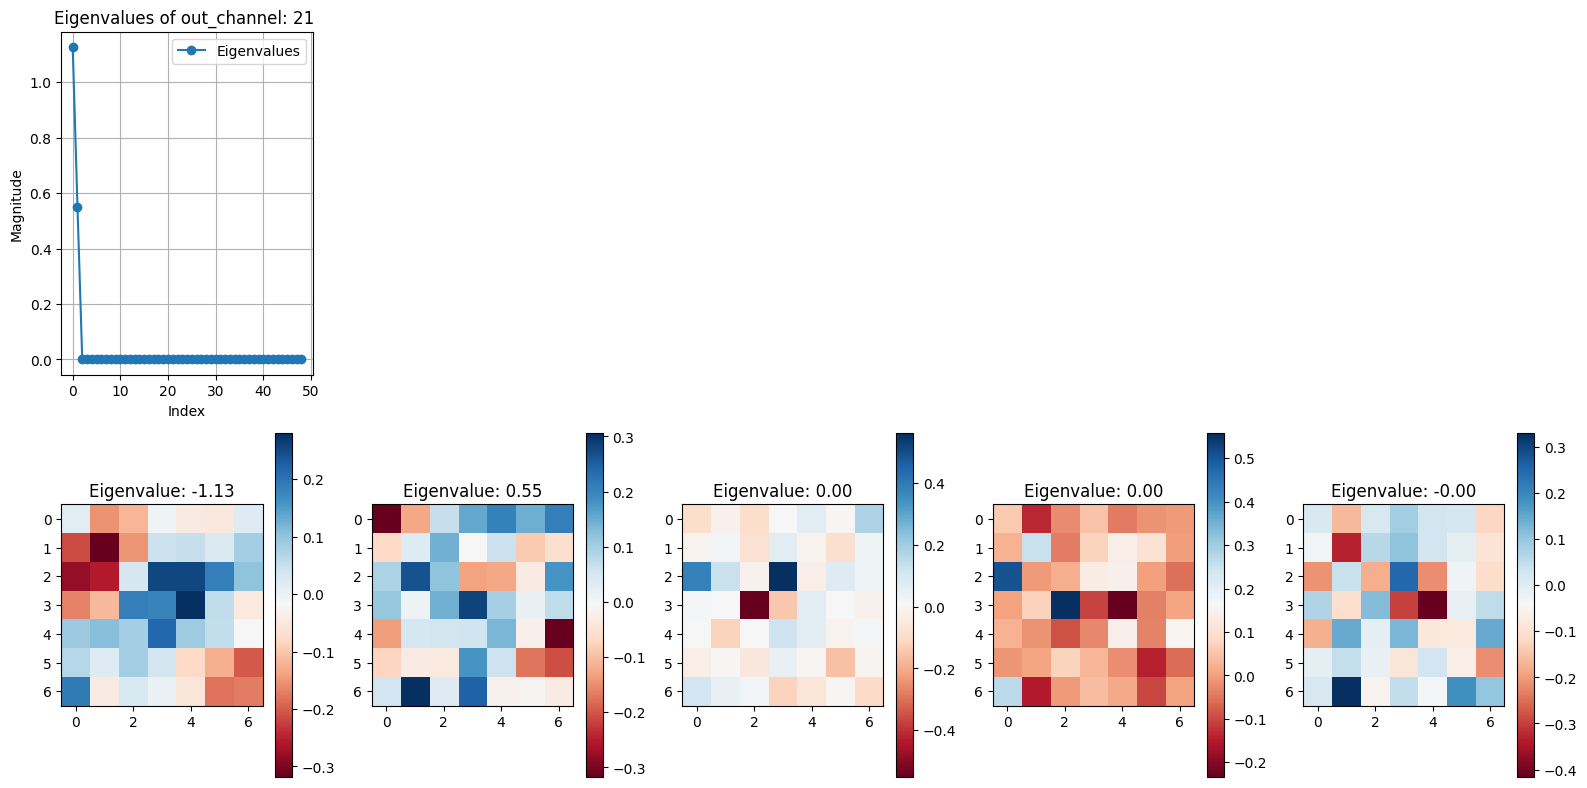

torch.Size([49, 49])


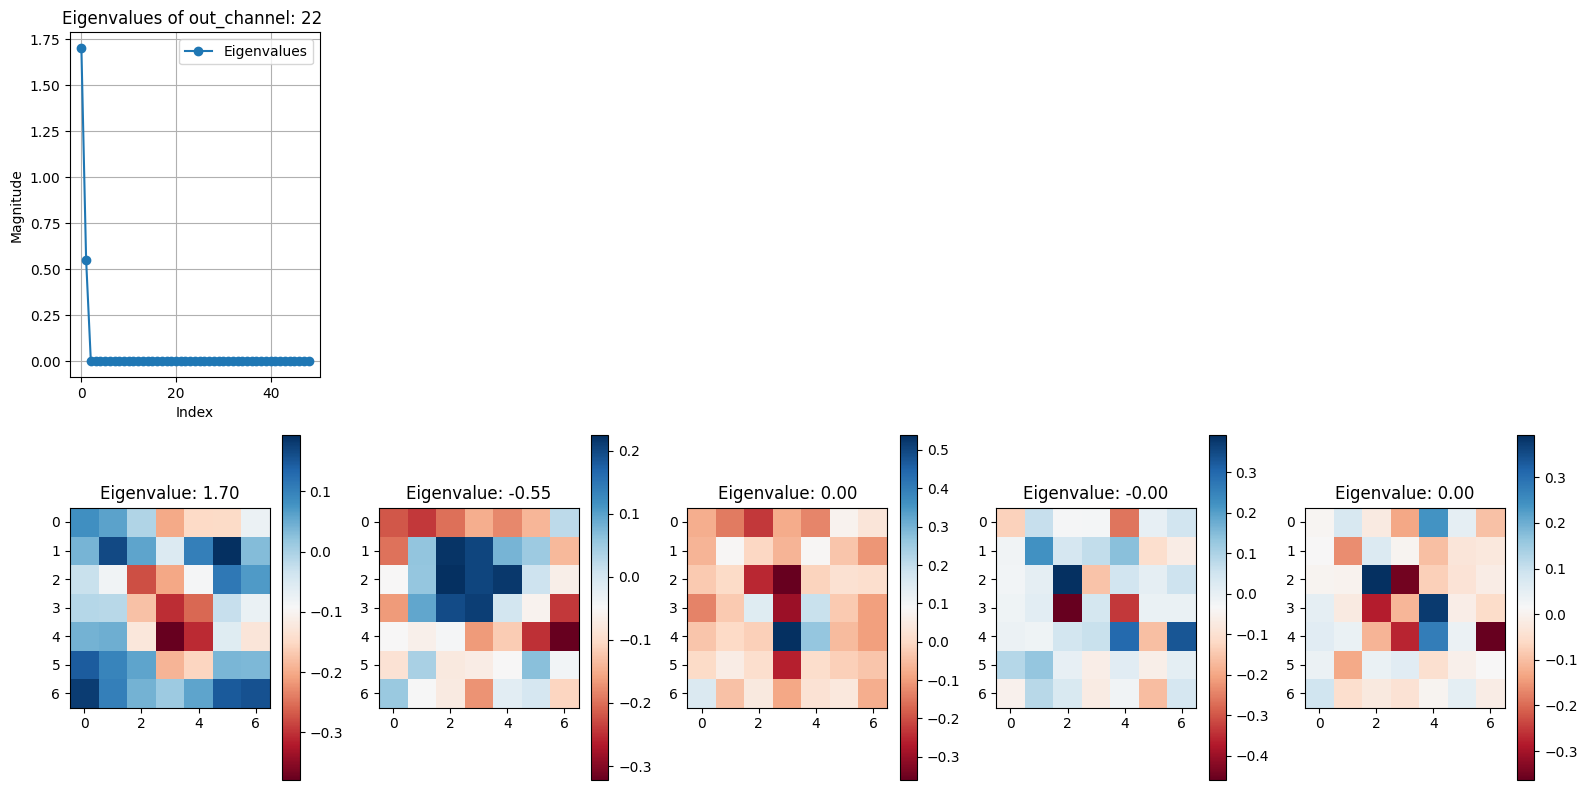

torch.Size([49, 49])


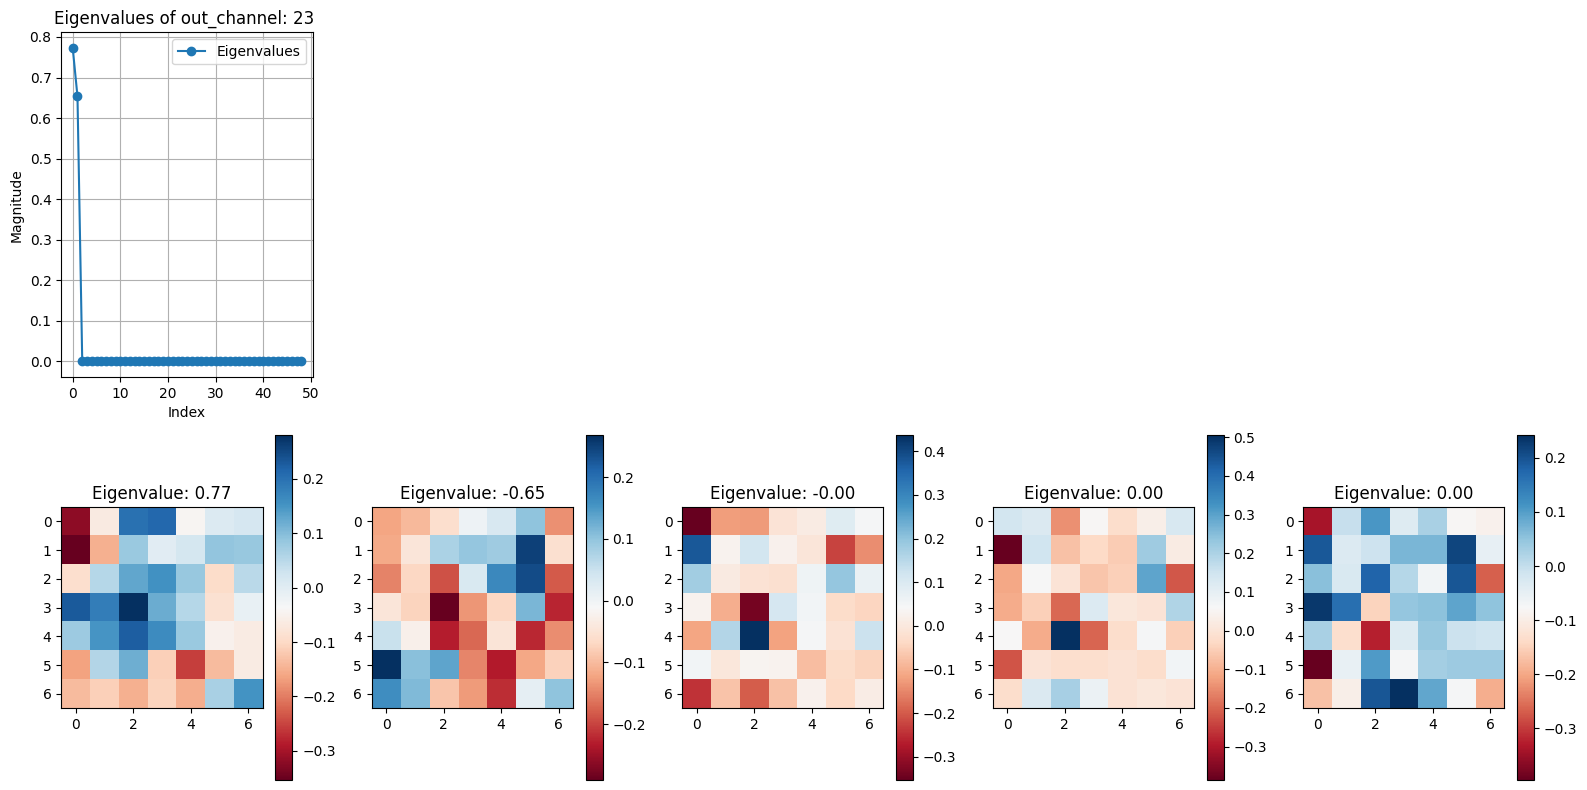

torch.Size([49, 49])


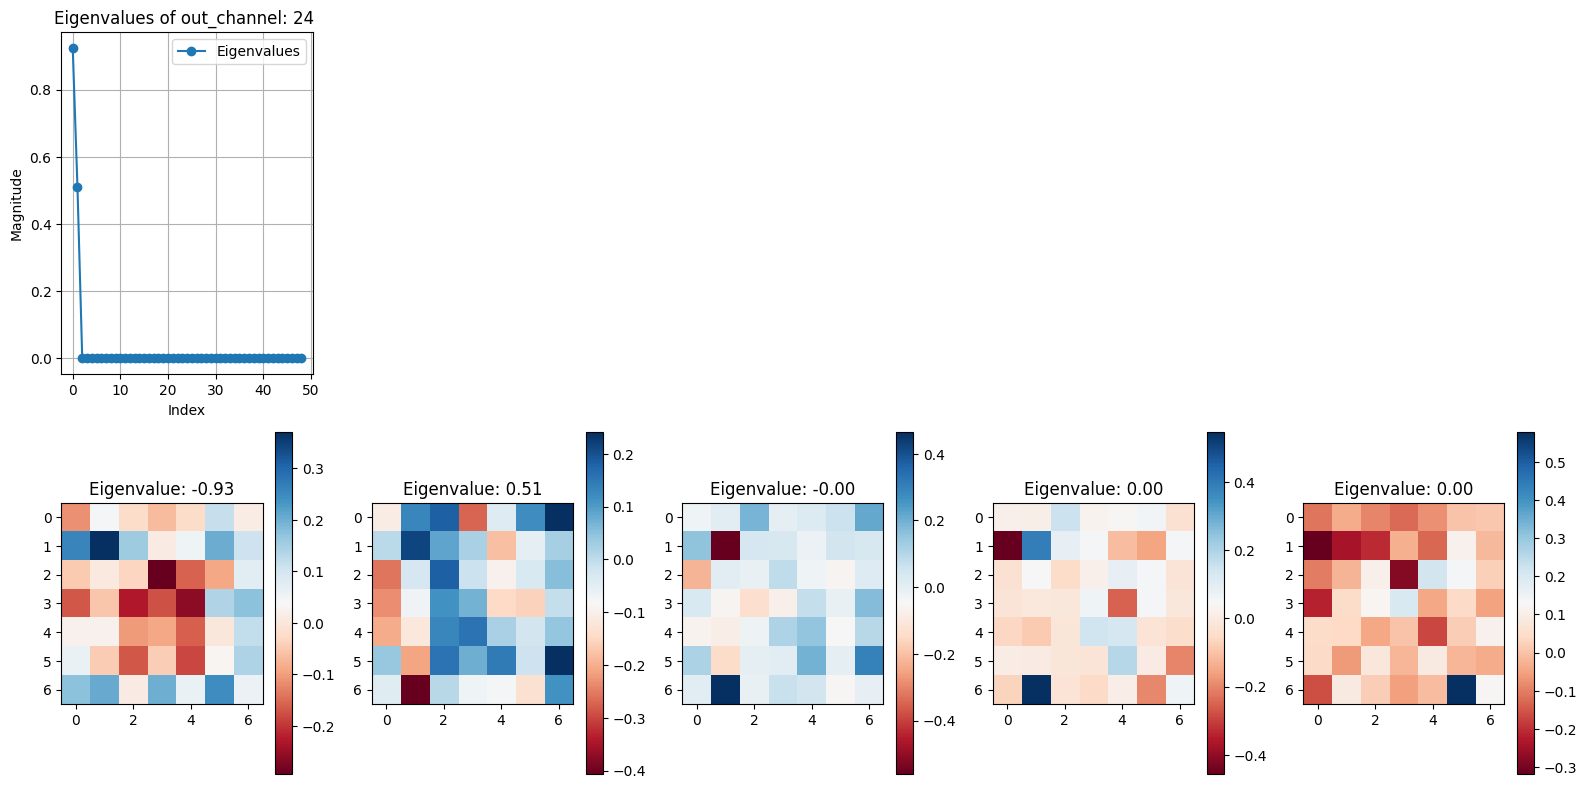

torch.Size([49, 49])


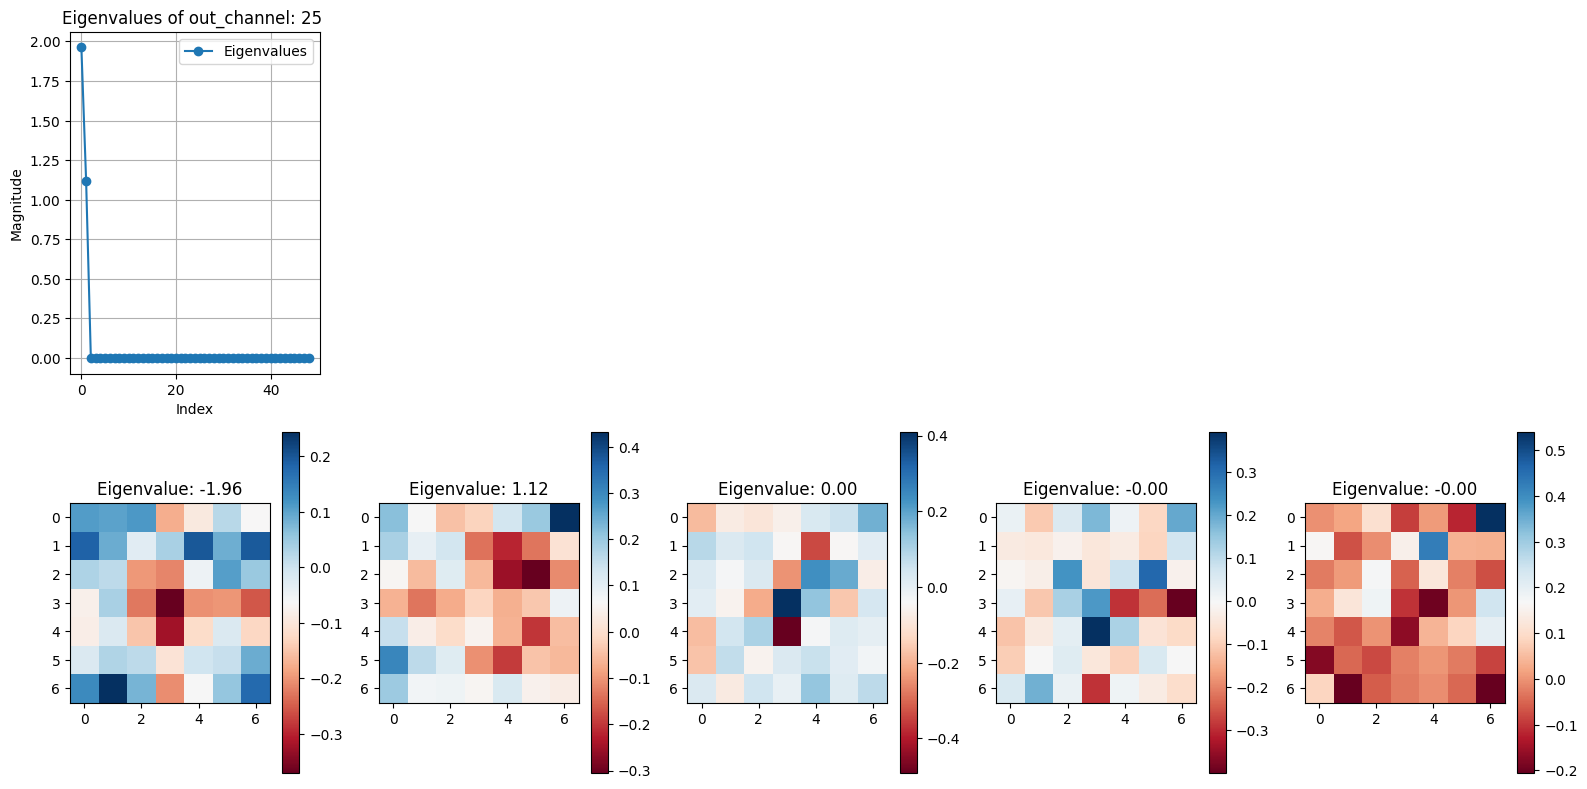

torch.Size([49, 49])


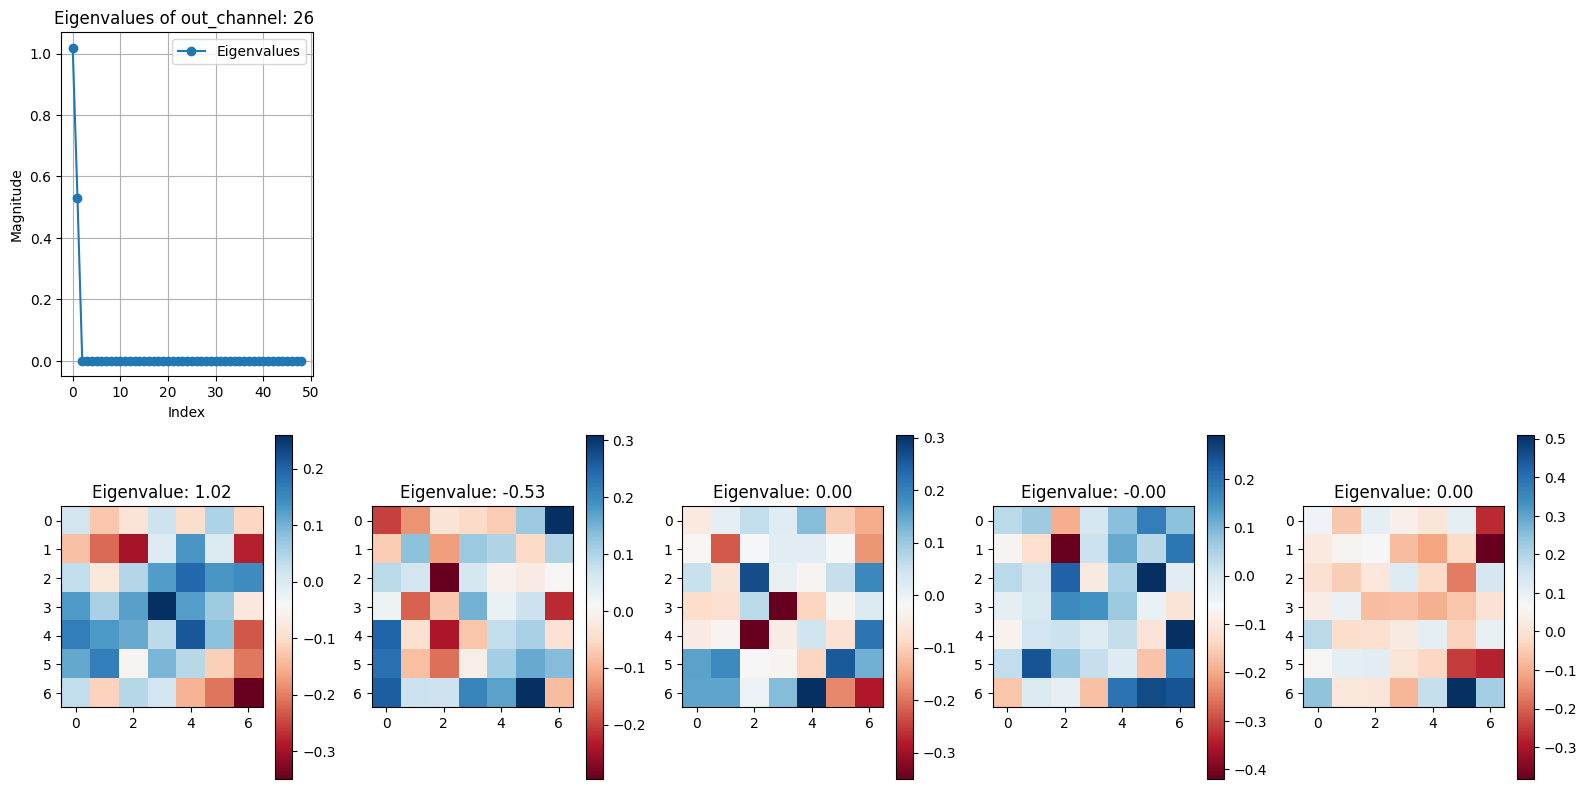

torch.Size([49, 49])


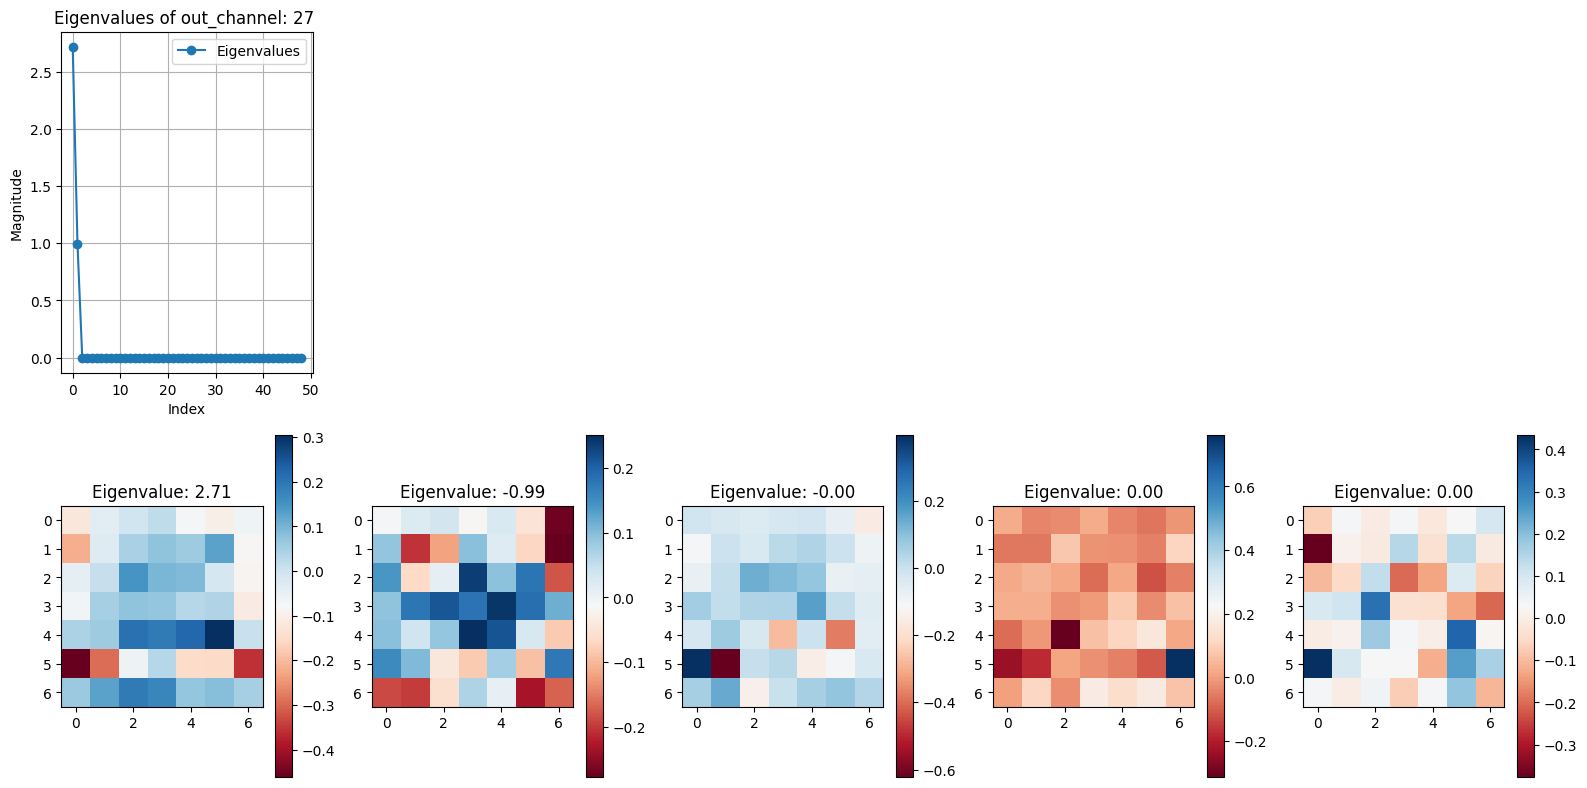

torch.Size([49, 49])


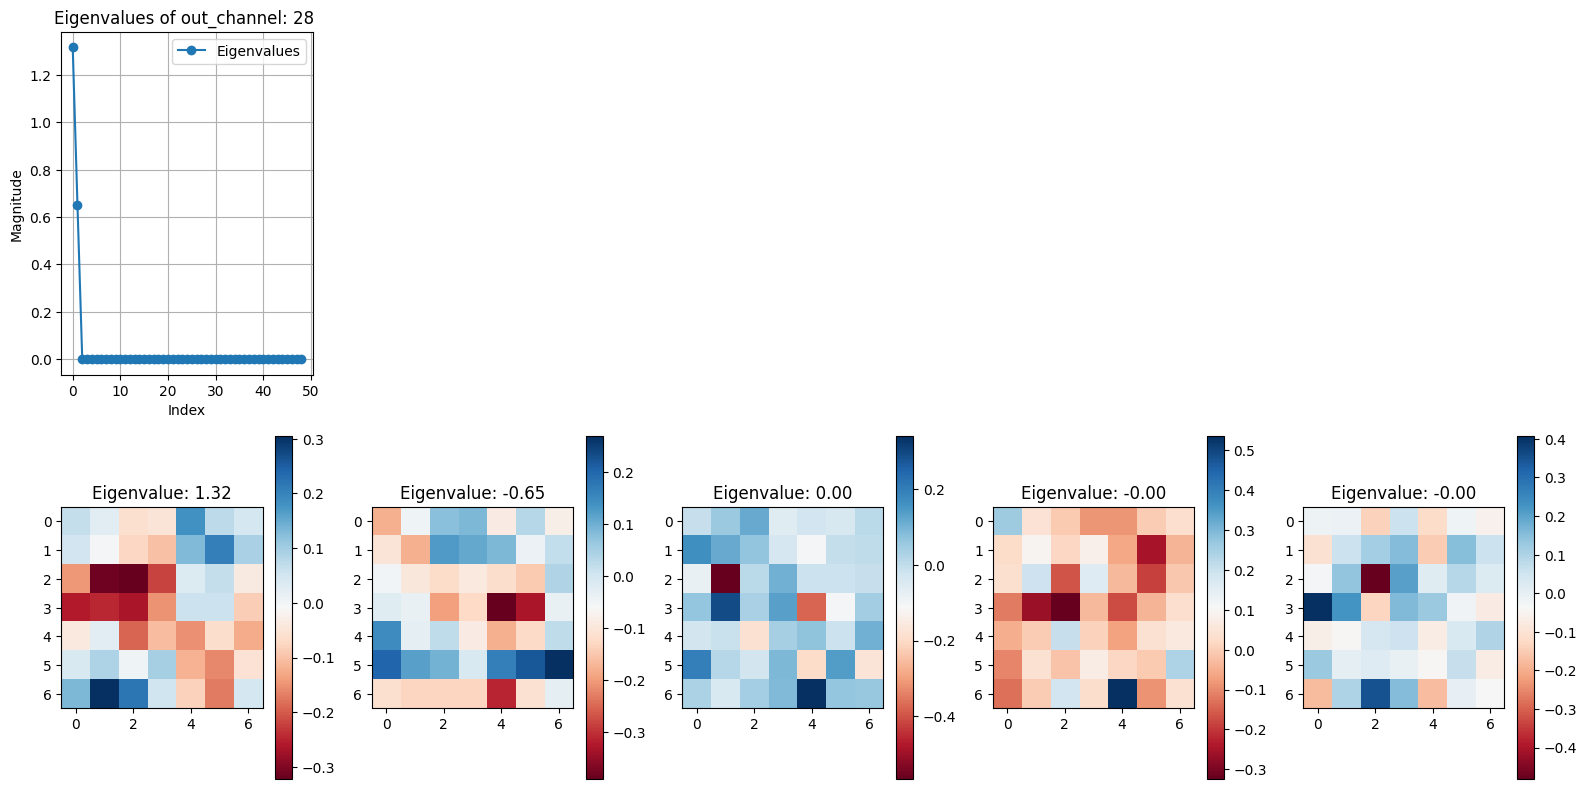

torch.Size([49, 49])


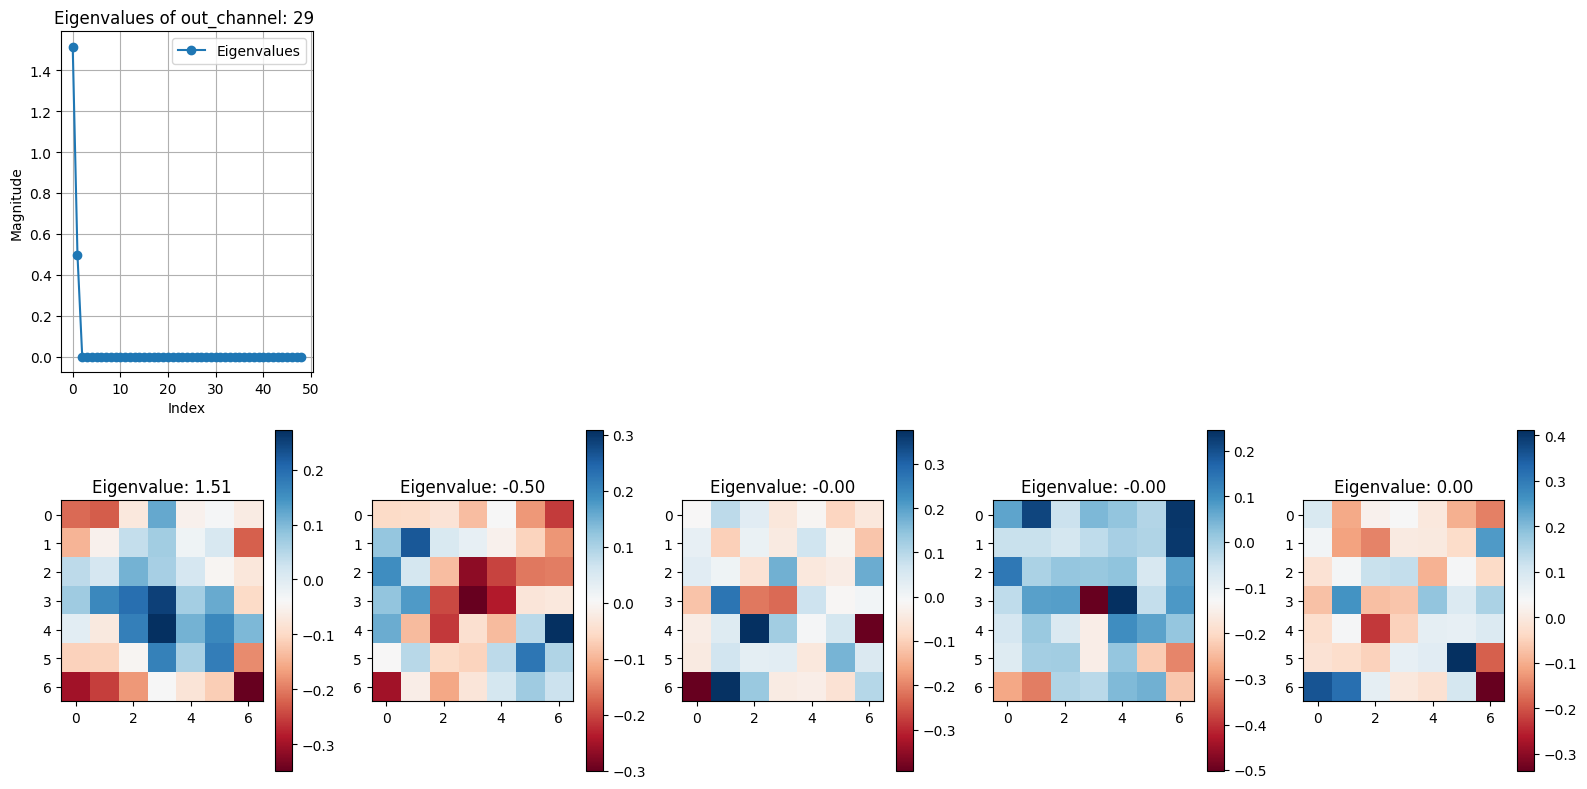

torch.Size([49, 49])


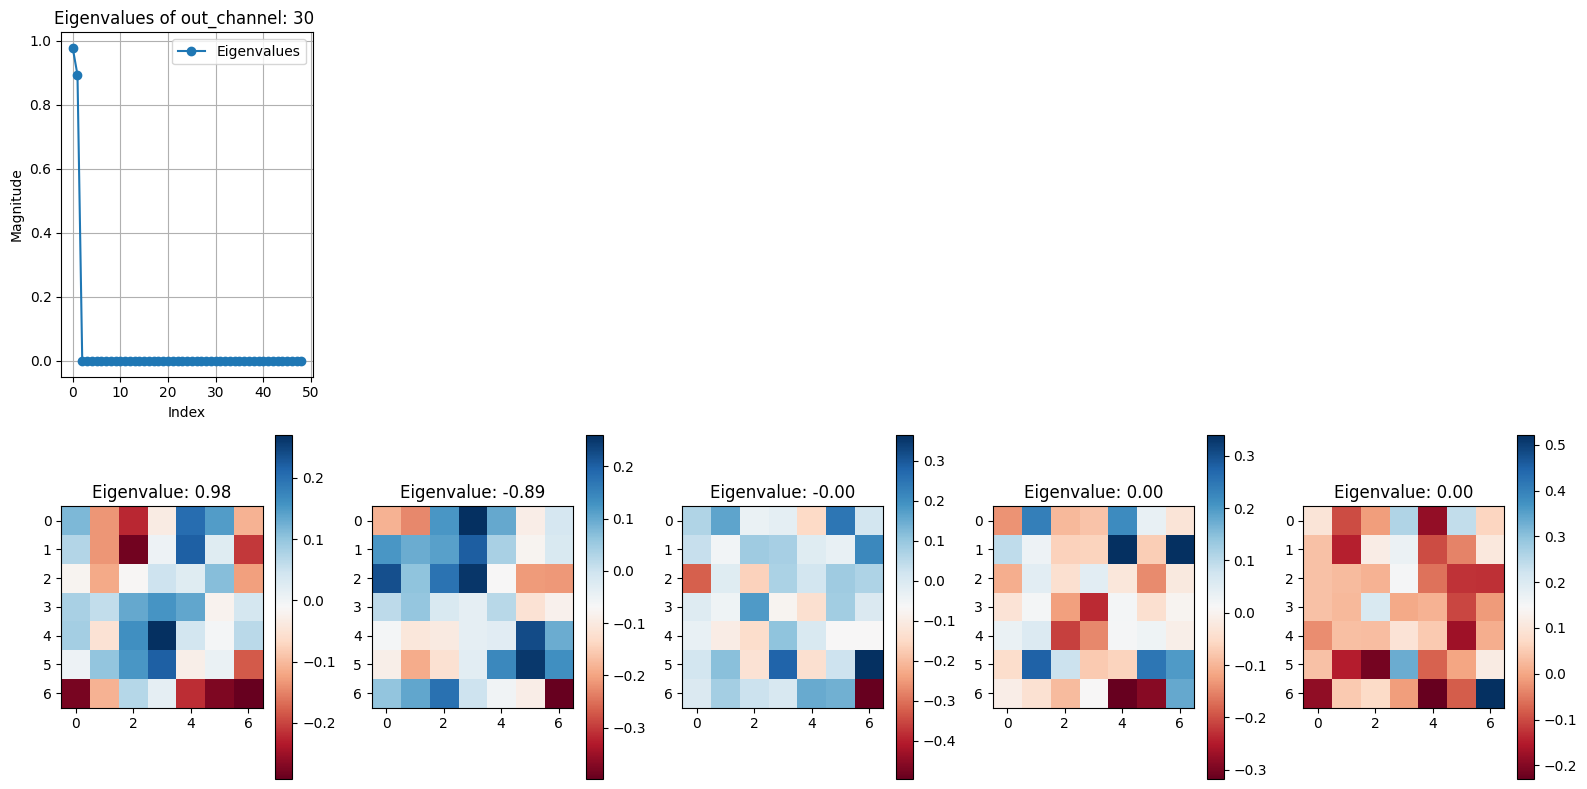

torch.Size([49, 49])


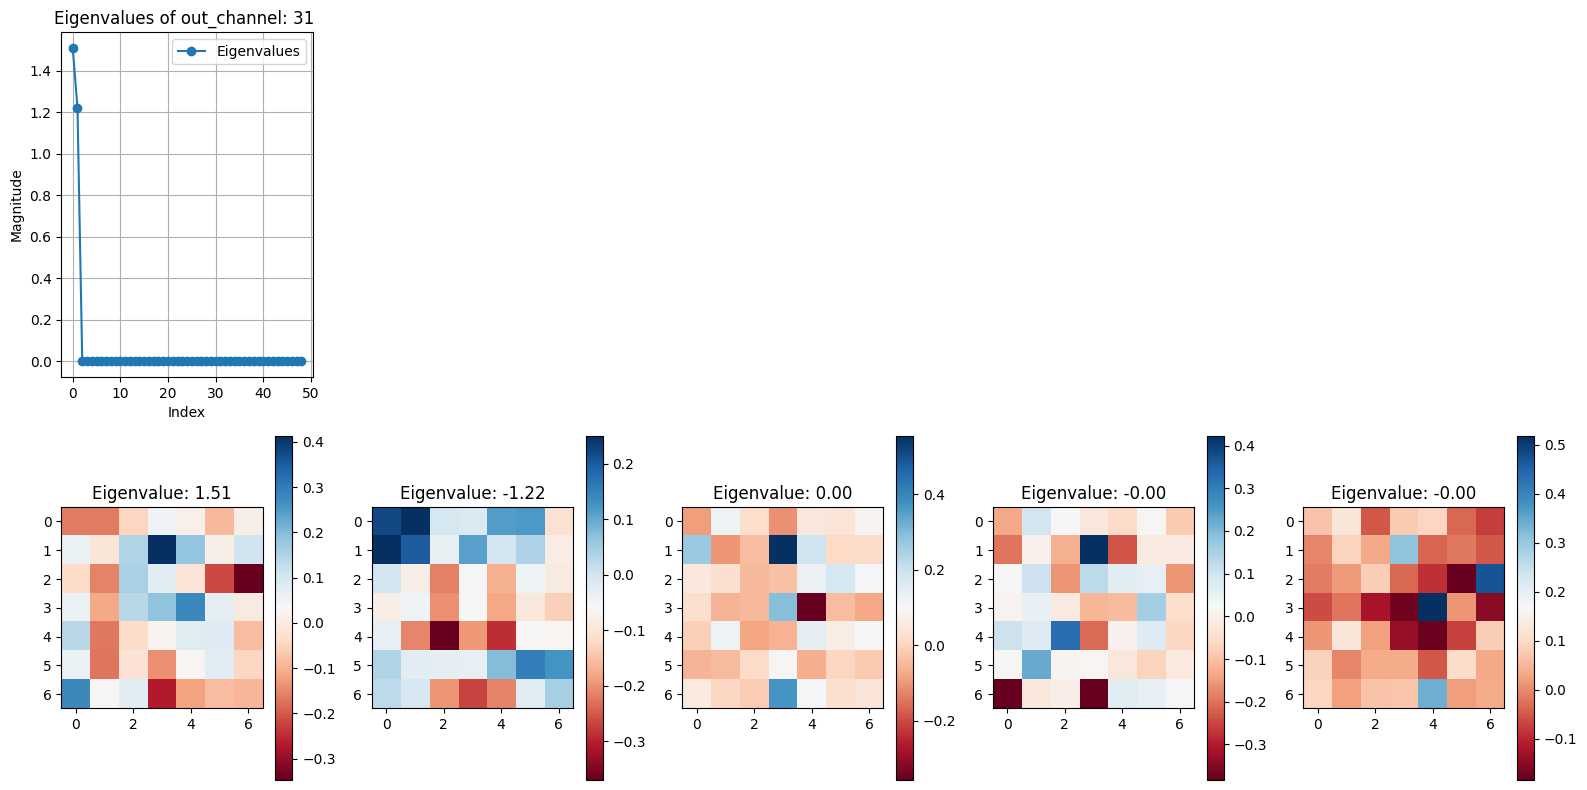

In [6]:
#we get three by three filters and now we should apply the maximally activating eigenvector channels 
# over a random image and see what we get
for i in range(out_channels):
    matrix = W_summed_interactions[i,:,:]
    print(matrix.shape)
    plotter = EigenvectorPlotter(matrix,7, i)
    plotter.plot()


Plotting the first 2 non zero eigenvectors

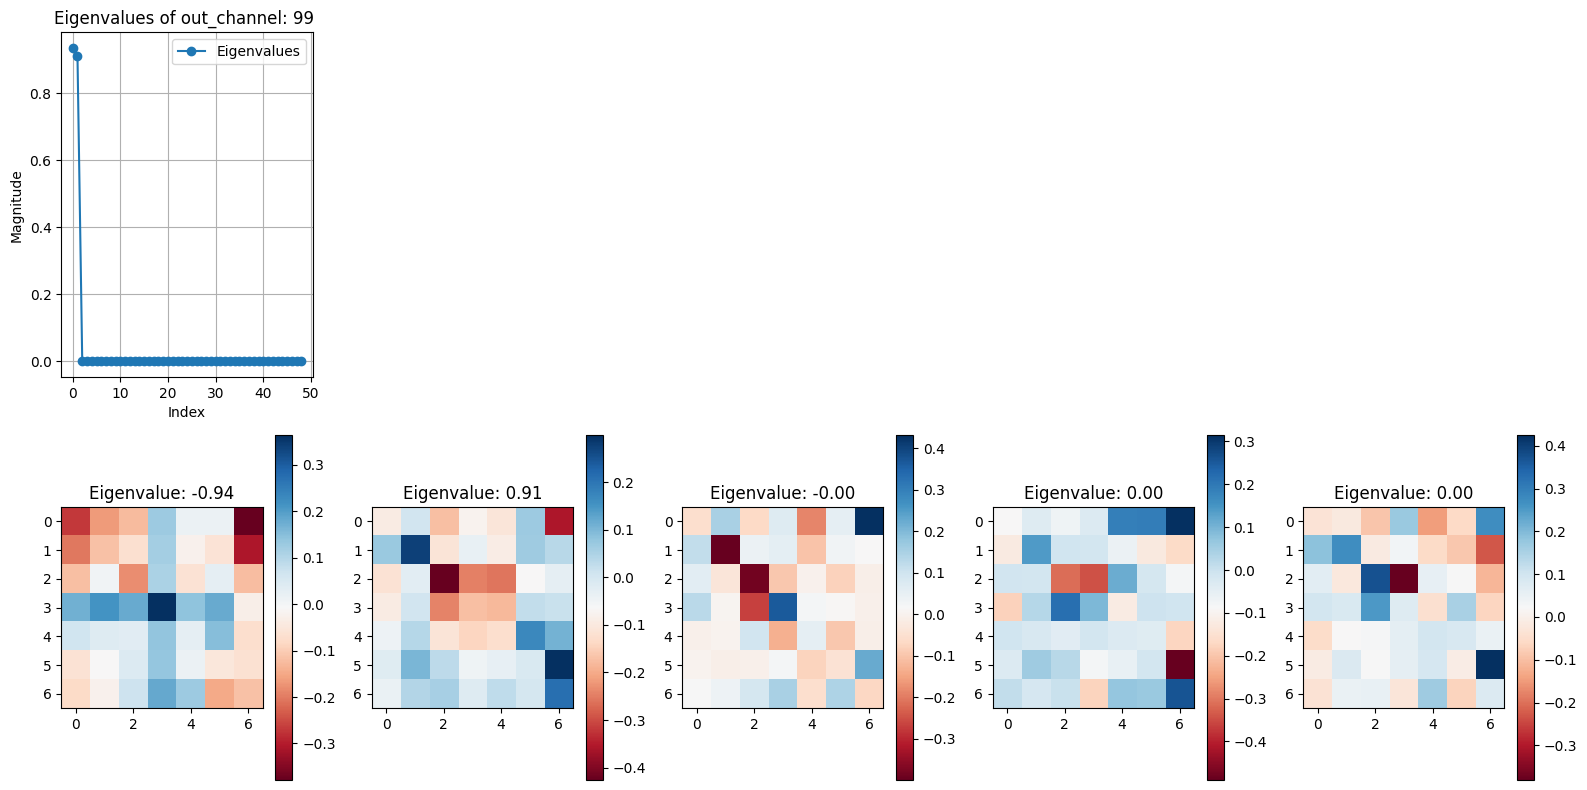

2 (7, 7)


In [13]:
#let's try to plot the first 2 non-zero eigenvecs (filters)
plotter = EigenvectorPlotter(W_summed_interactions[0,:,:],7, i)
plotter.plot()
matrices = plotter.get_non_zero_eigenvec()
print(len(matrix),matrix[0].shape)



# In this section, we calculate the top activating image segments for each eigenfilter
The steps are 
- Making a dataset to calculate the top activating segments for each eigenfilter
- We make a list of filters for all output channels
- We apply the filters on each image and record the maximally activating segments

In [30]:
input_dataset = []
for i in range(len(dataset)):
    obs = dataset[i].reset()
    obs = torch.tensor(obs)
    #obs = obs / 255.0  # scale to 0-1
    obs = obs.squeeze(0)
    assert obs.ndim == 3
    input_dataset.append(obs)


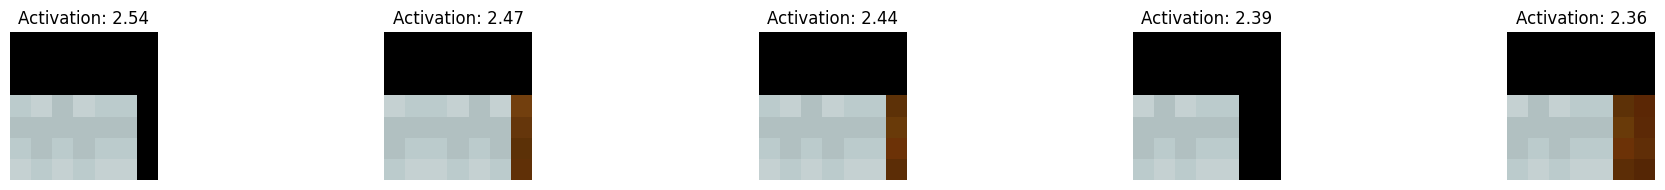

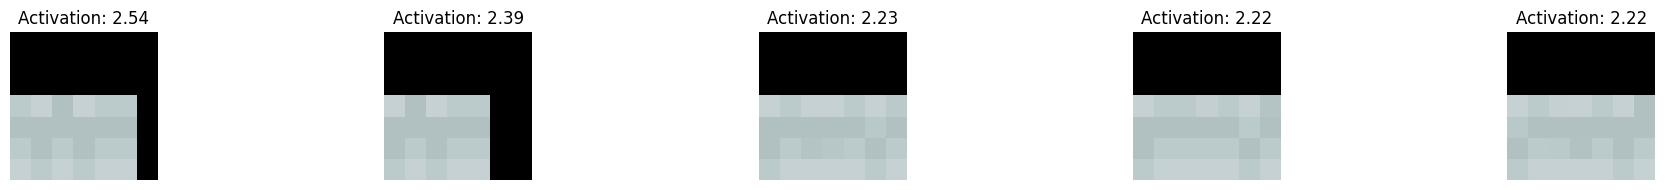

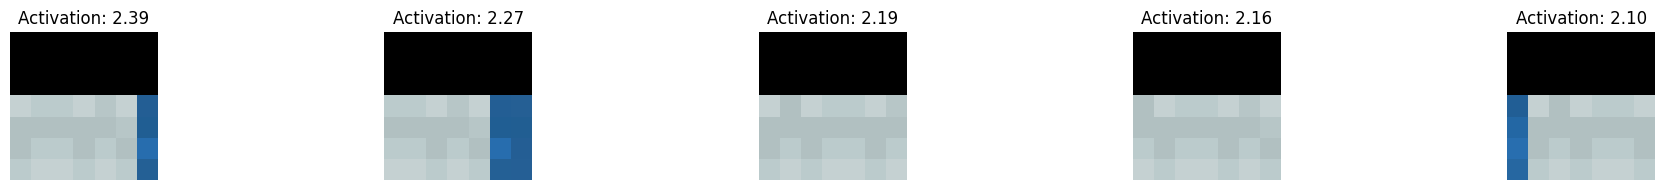

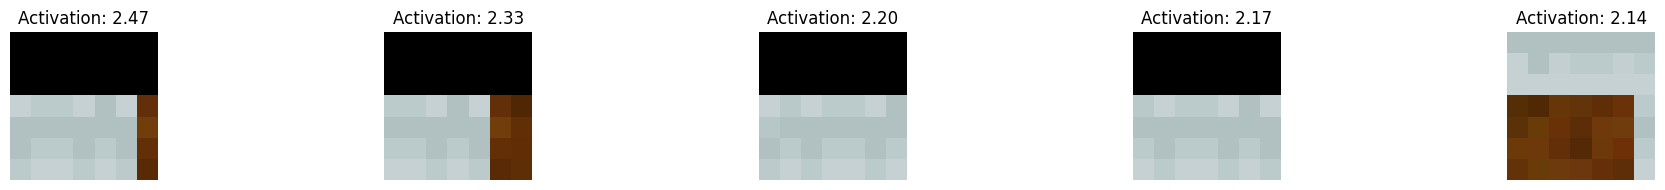

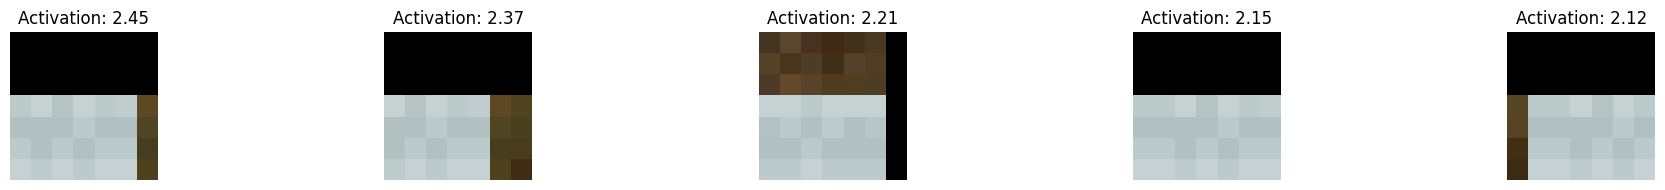

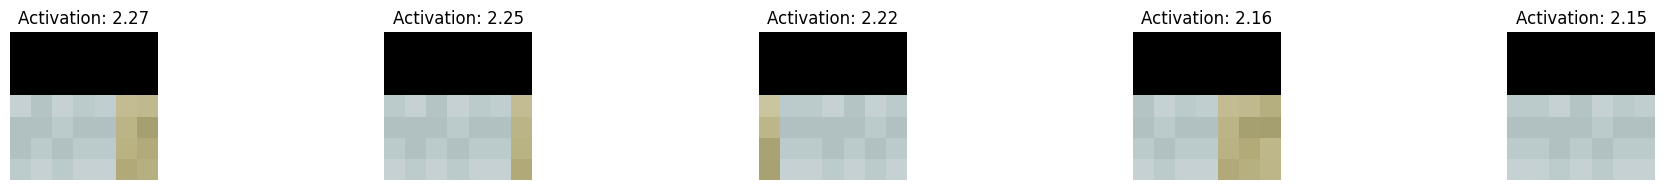

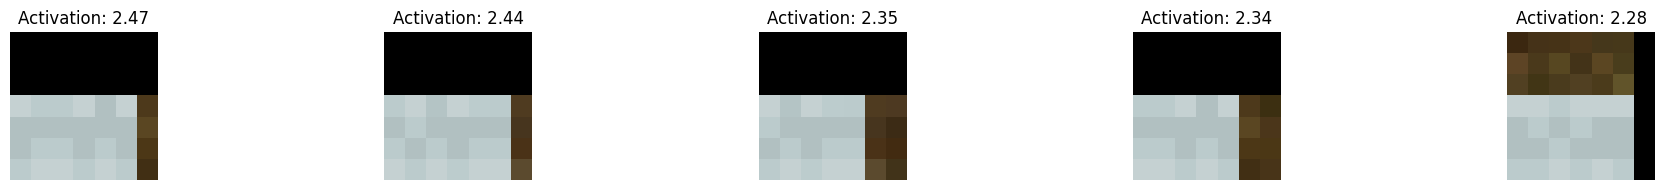

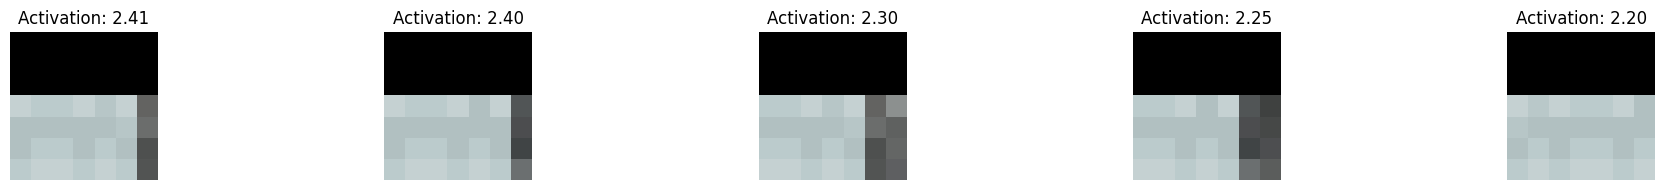

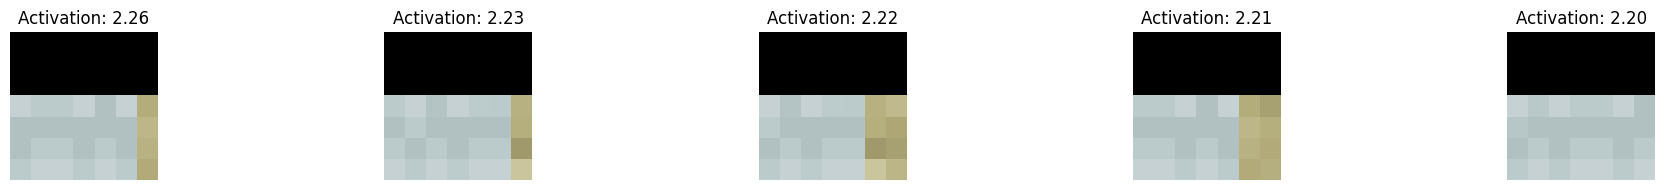

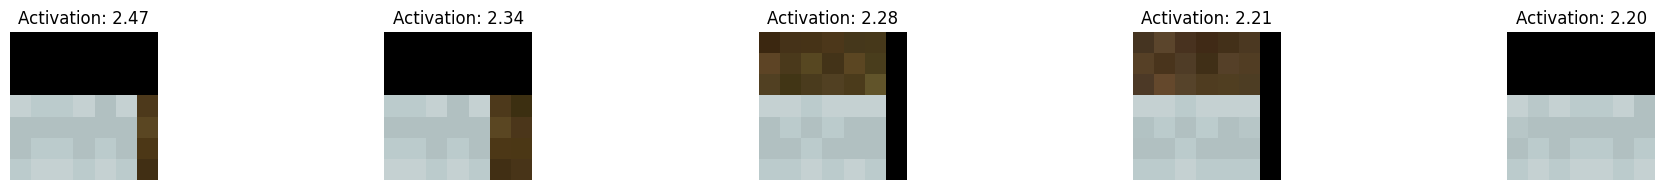

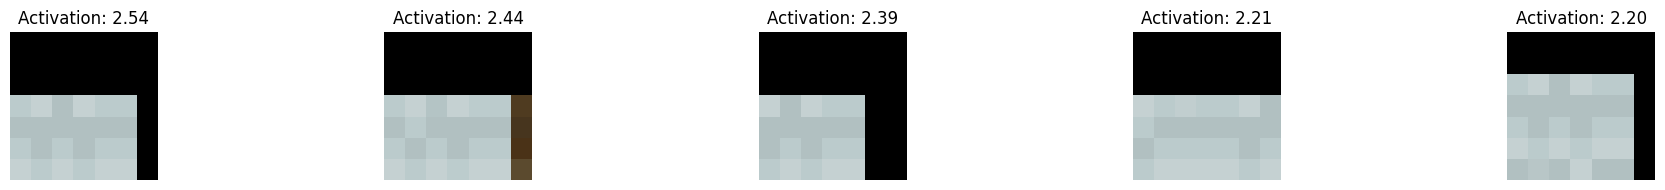

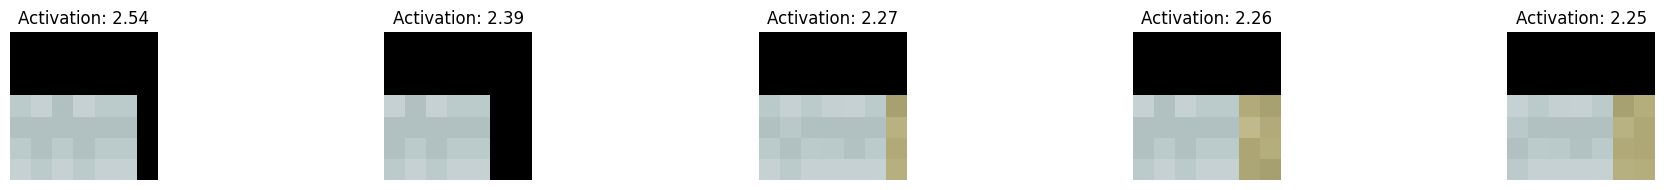

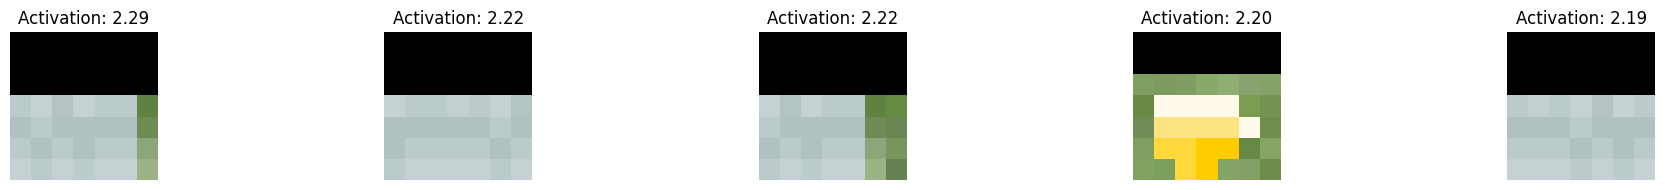

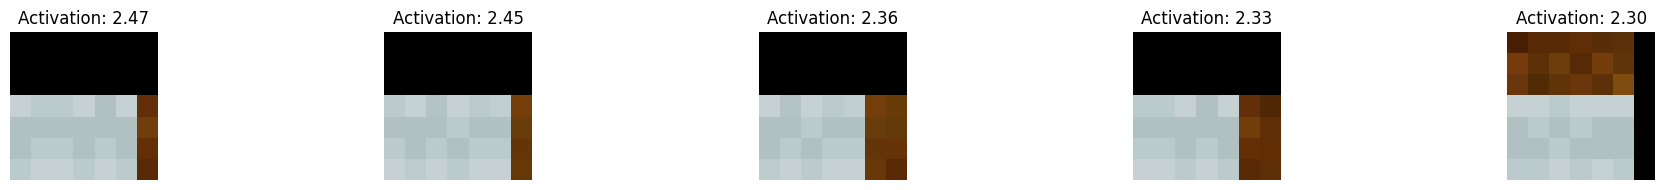

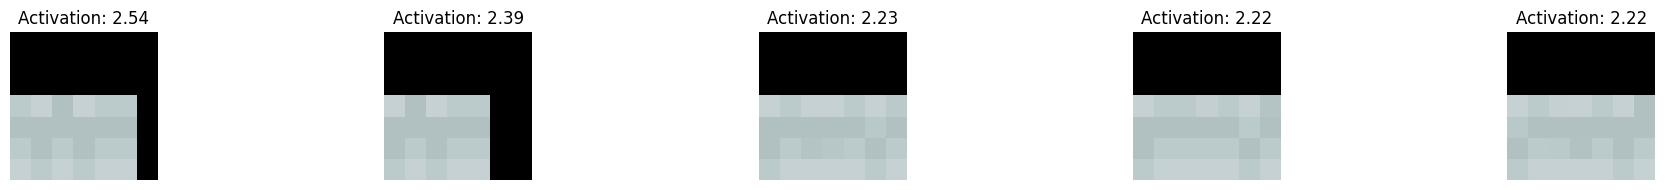

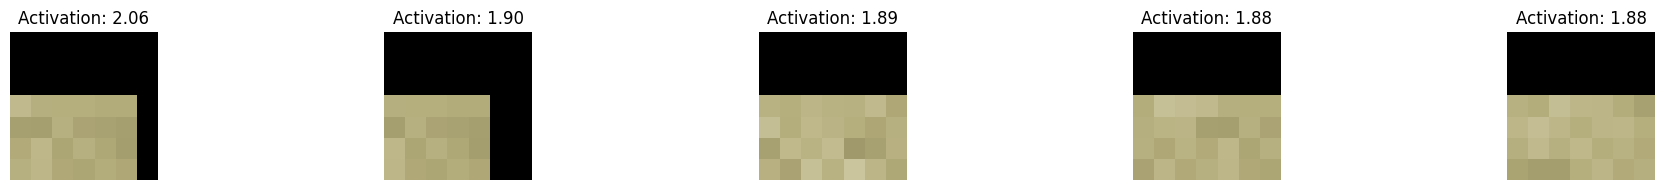

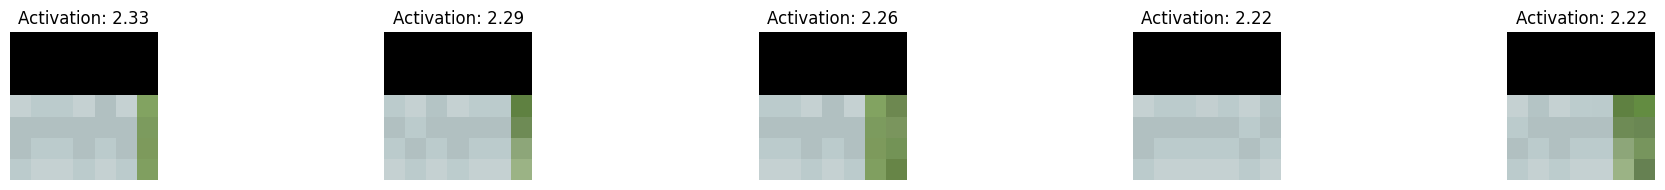

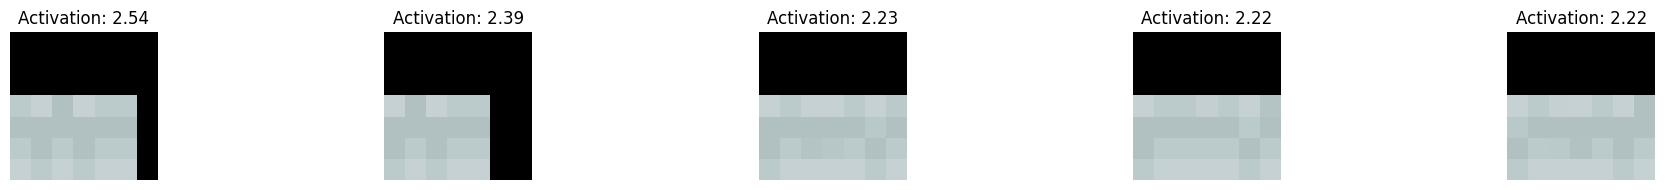

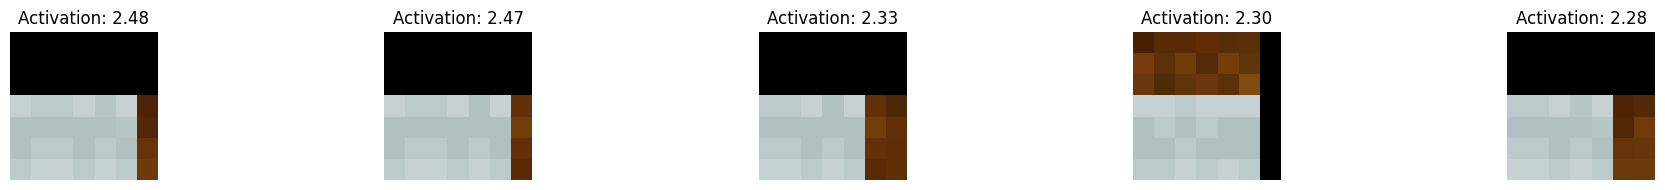

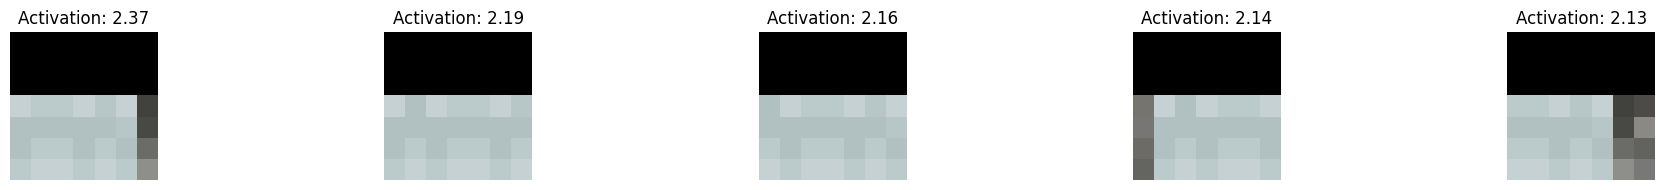

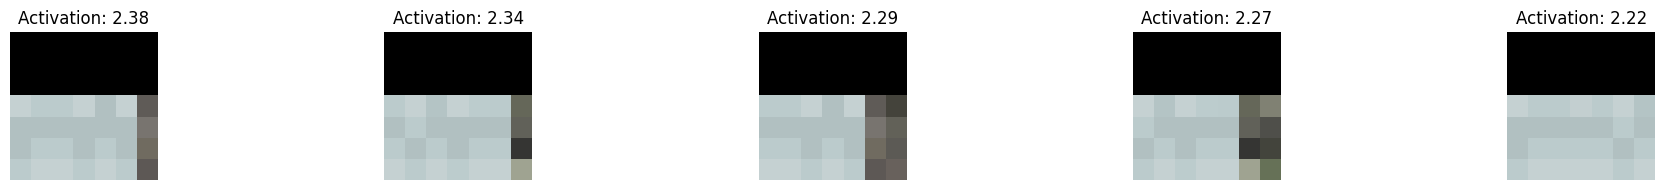

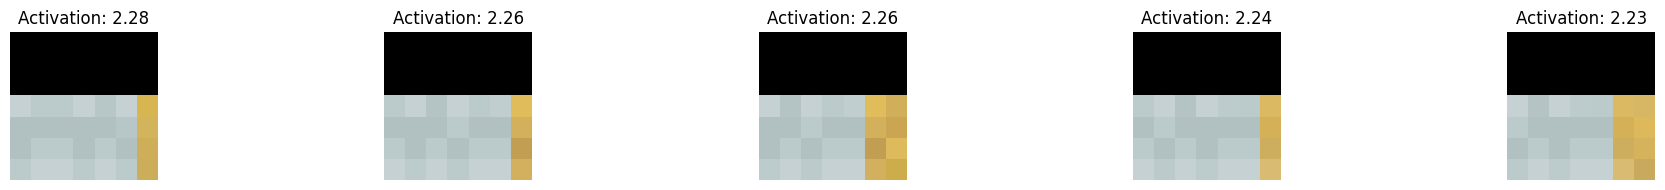

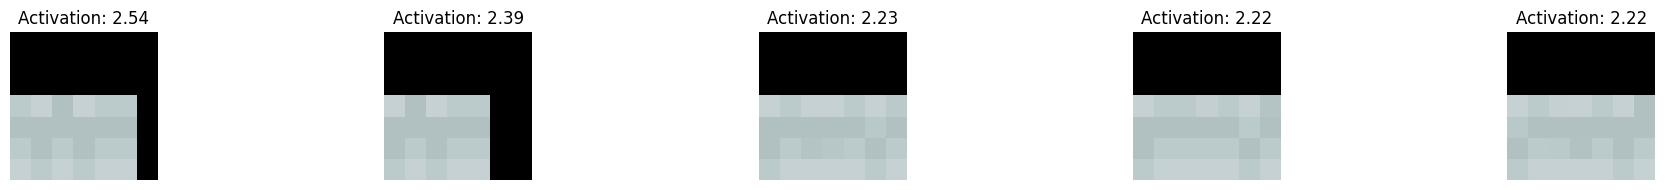

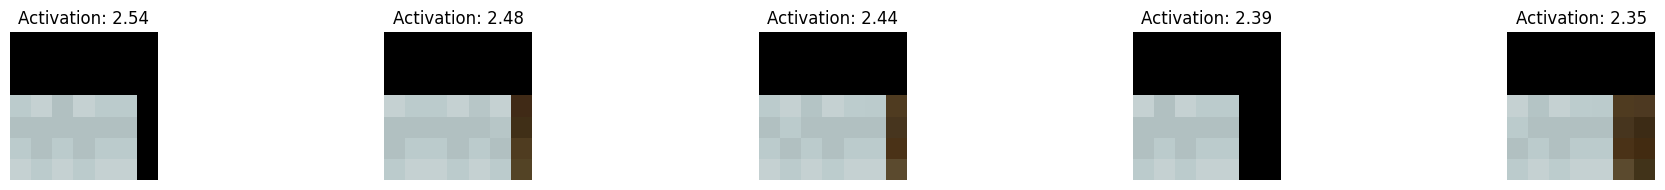

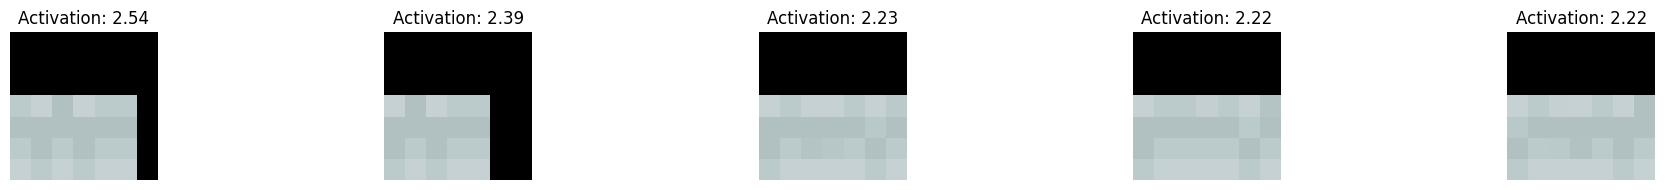

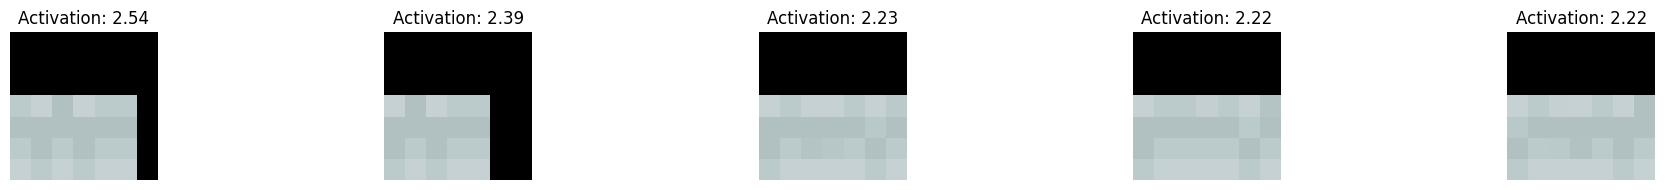

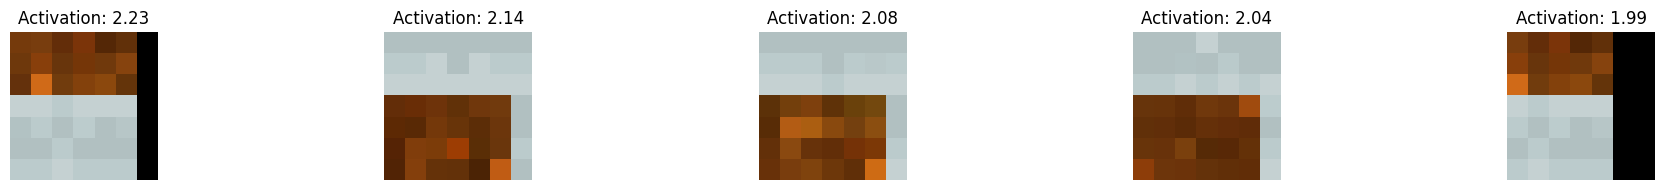

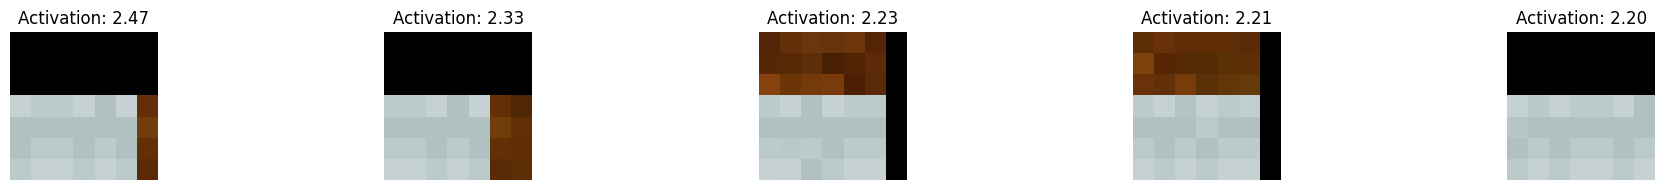

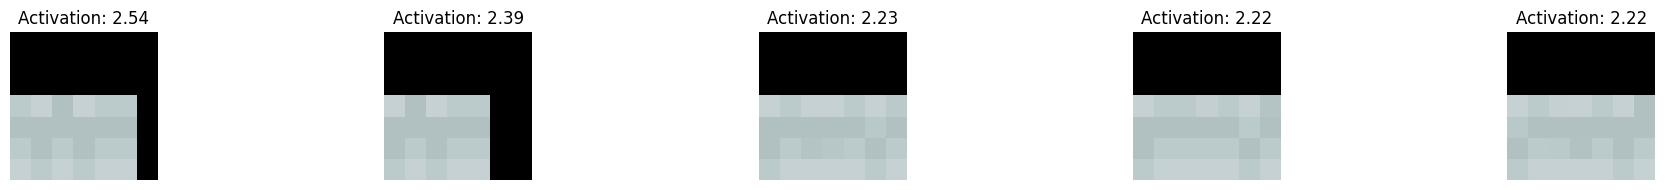

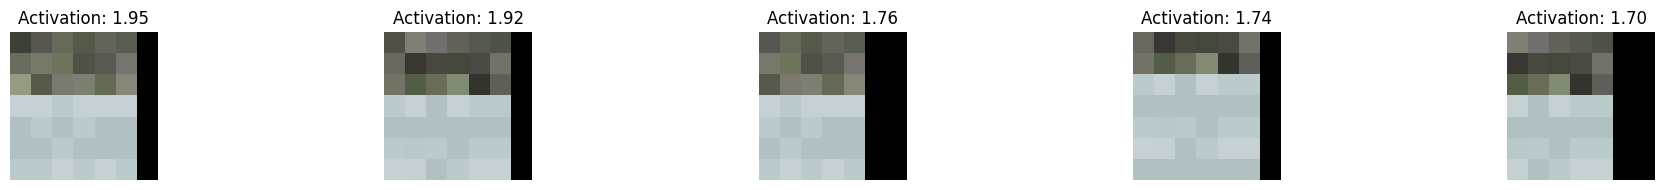

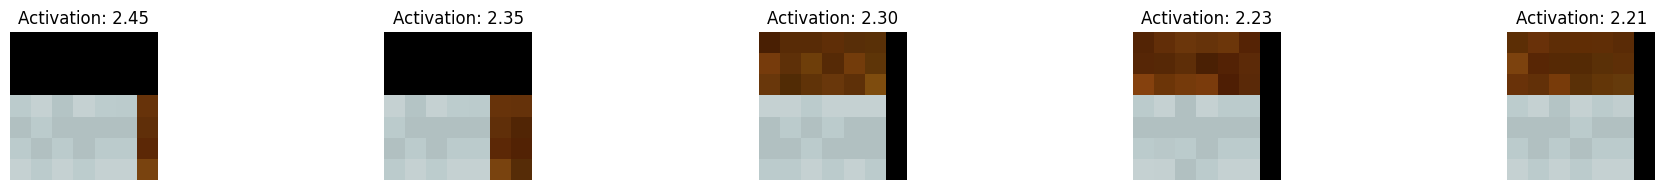

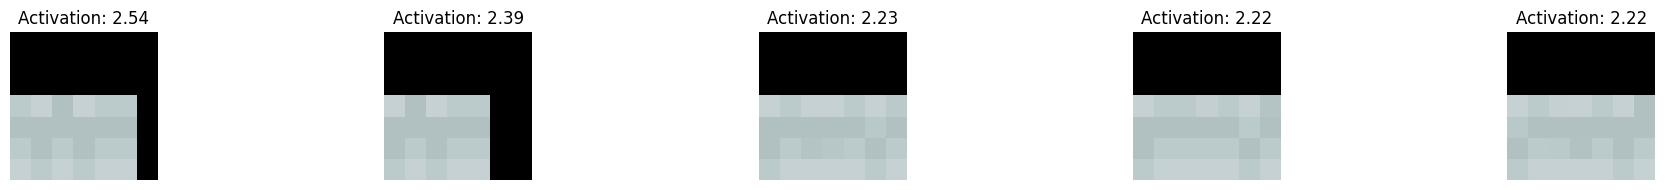

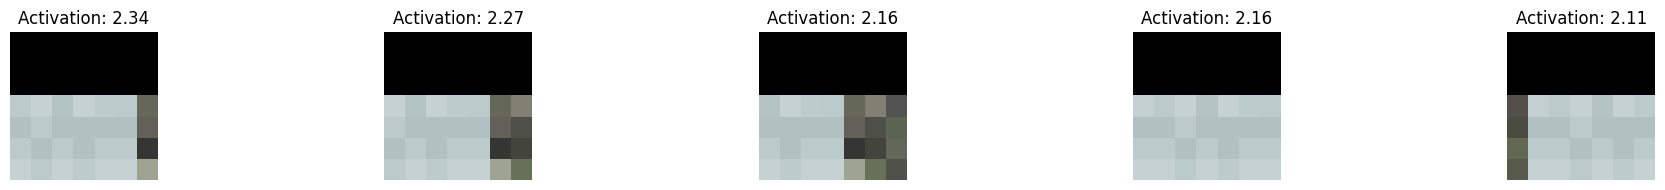

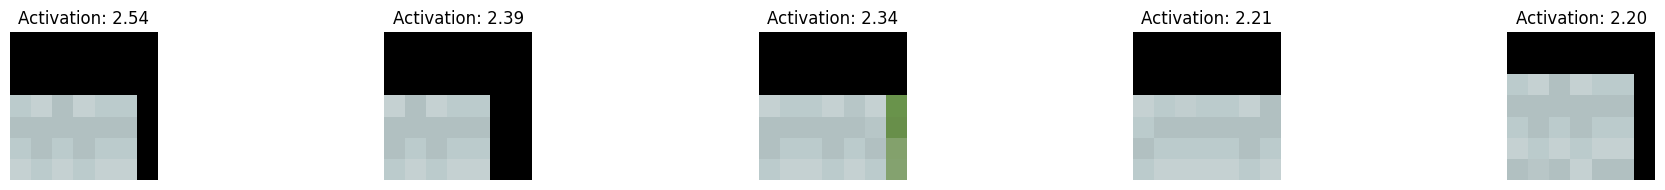

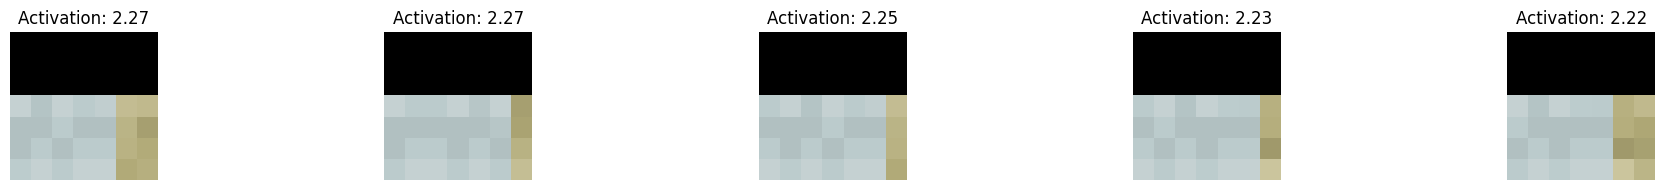

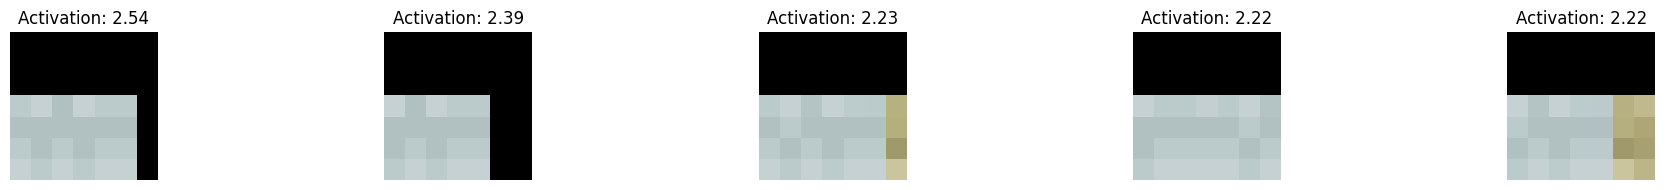

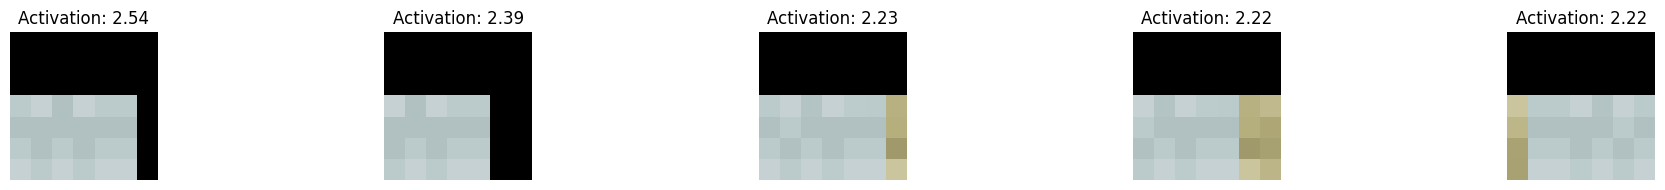

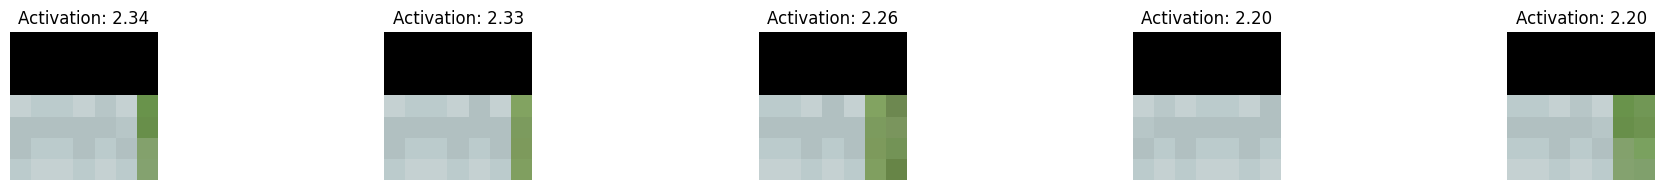

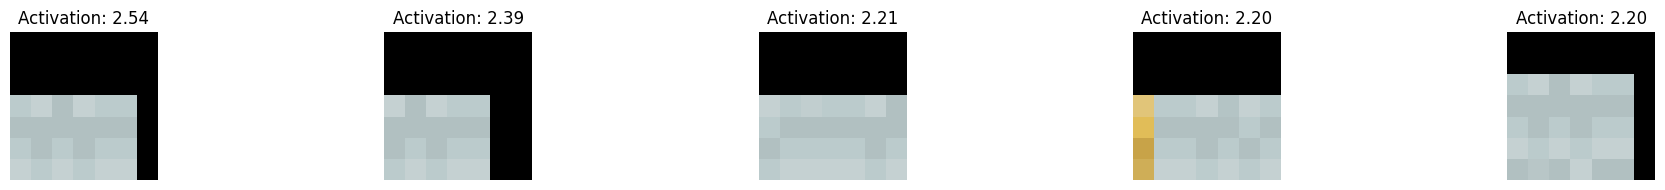

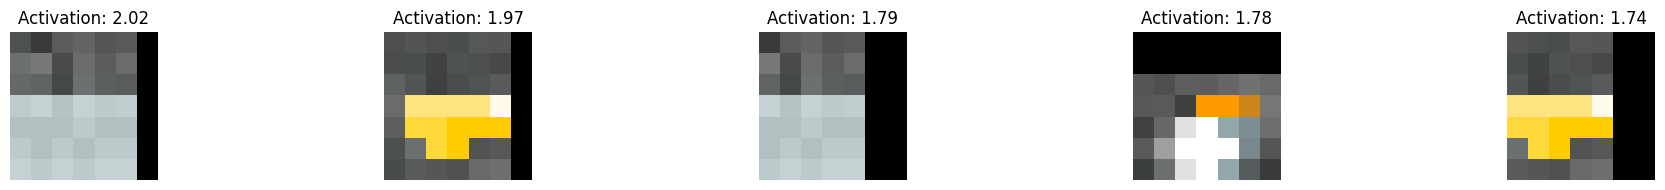

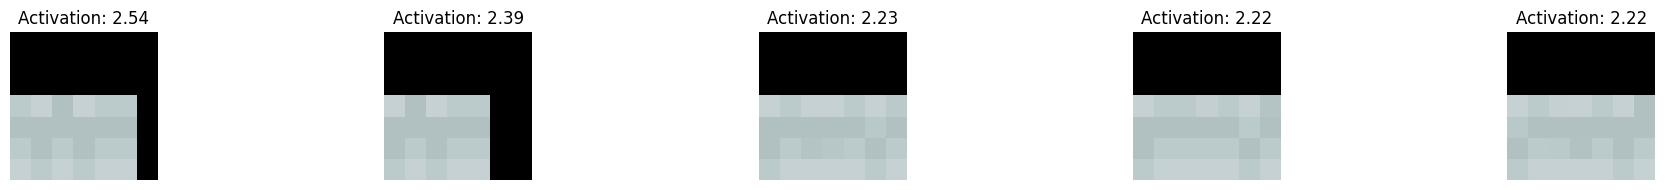

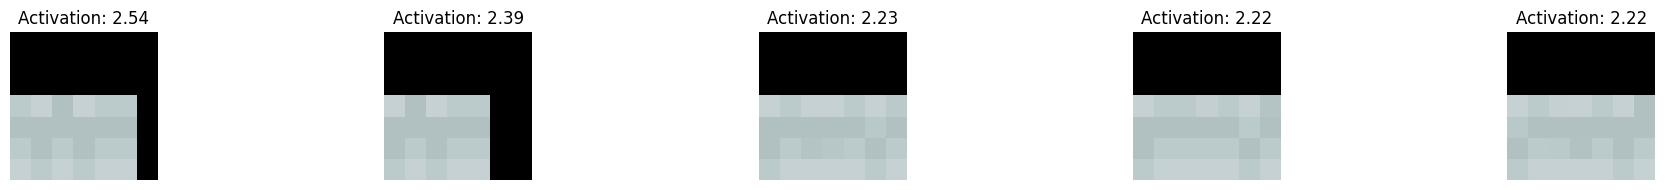

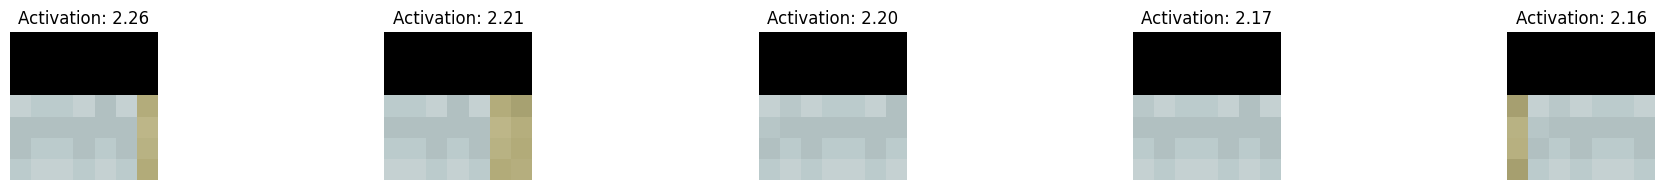

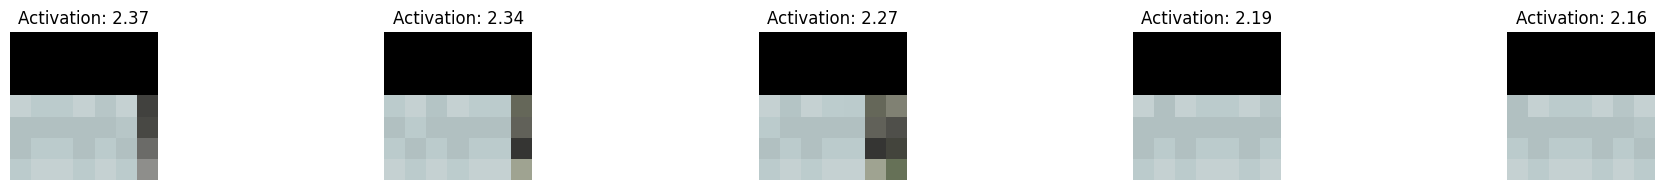

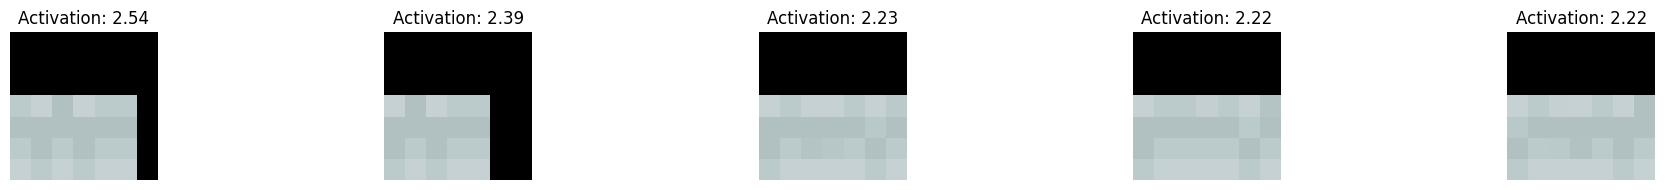

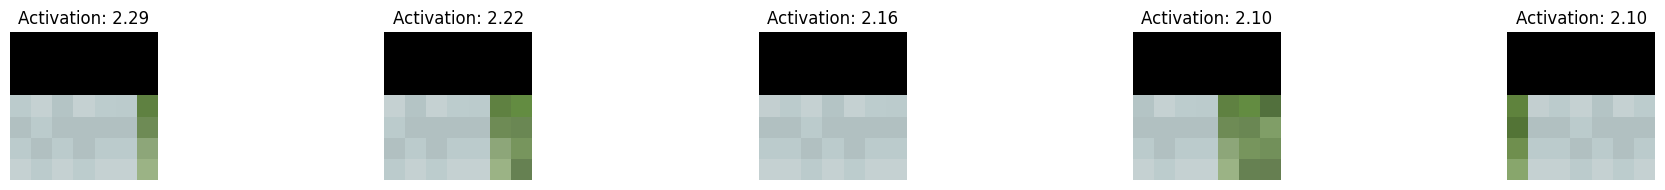

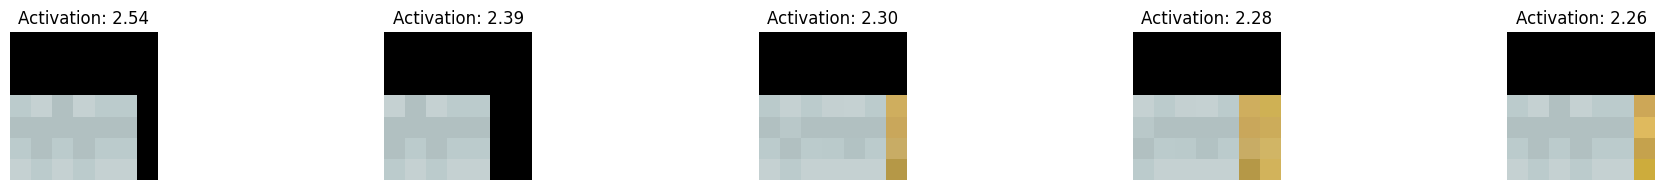

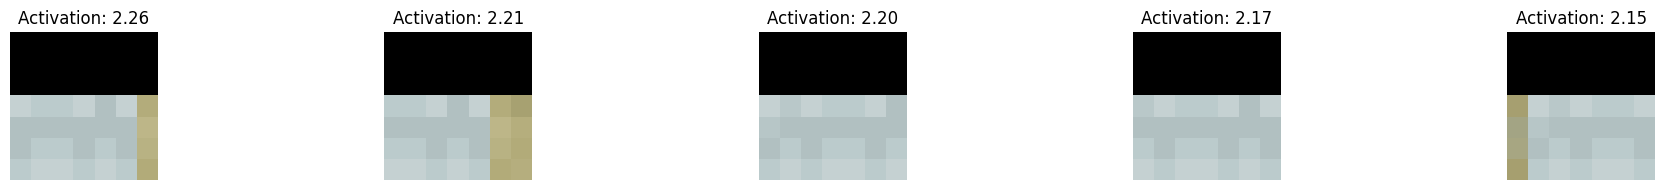

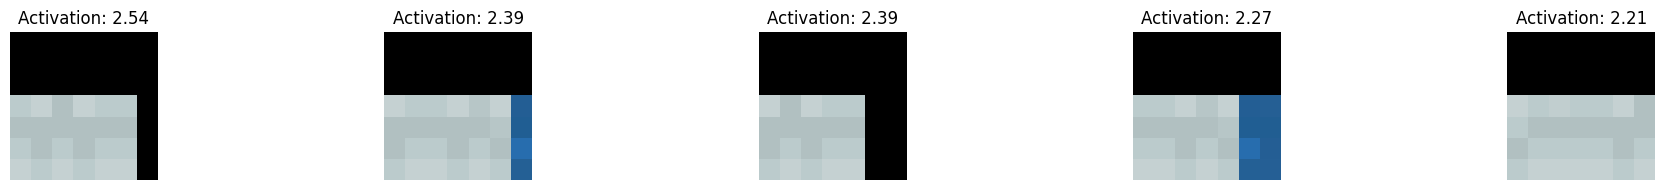

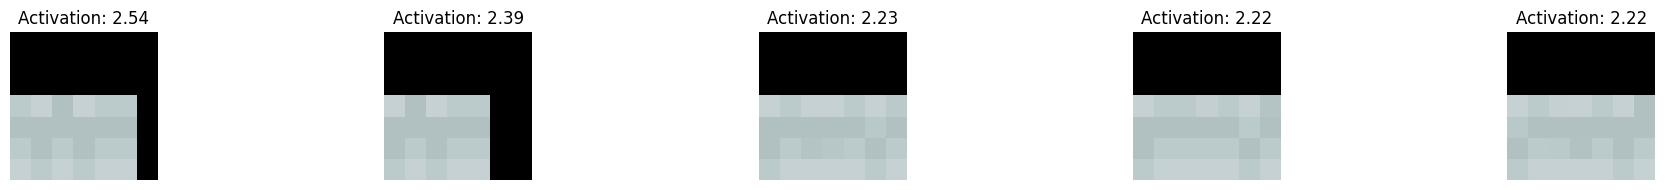

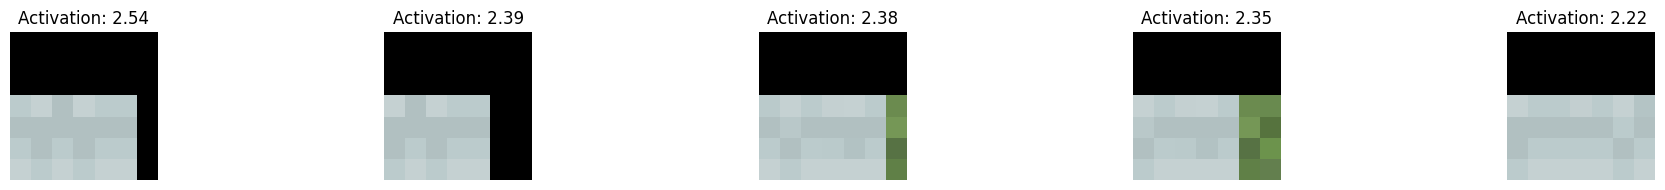

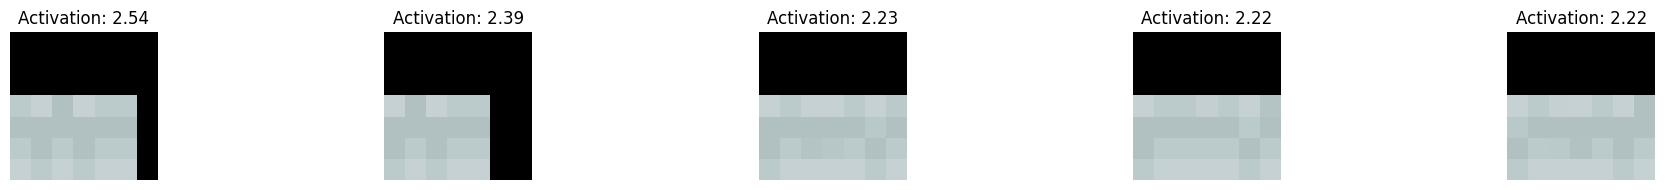

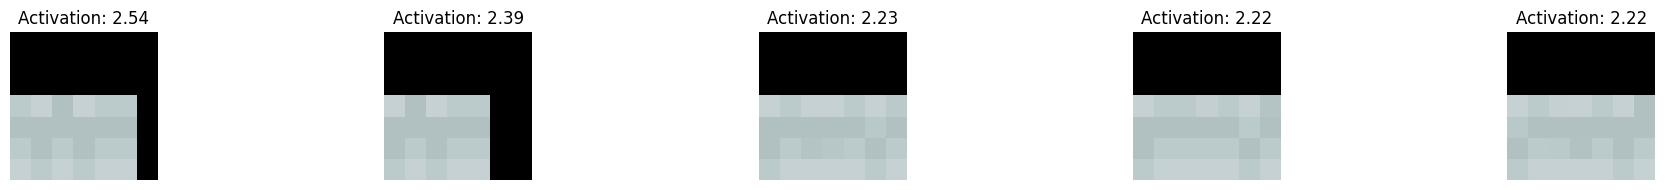

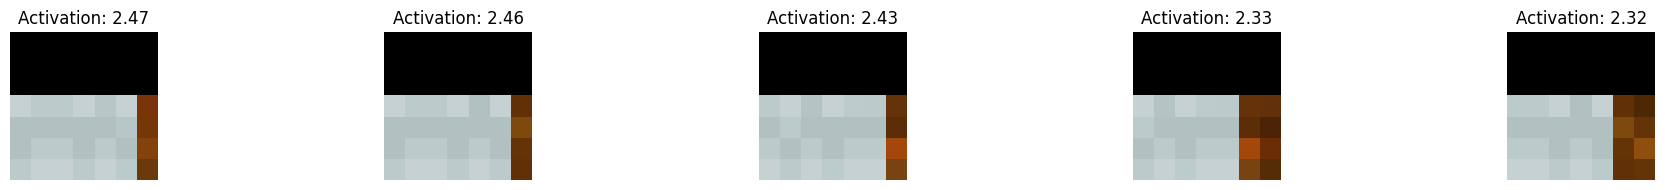

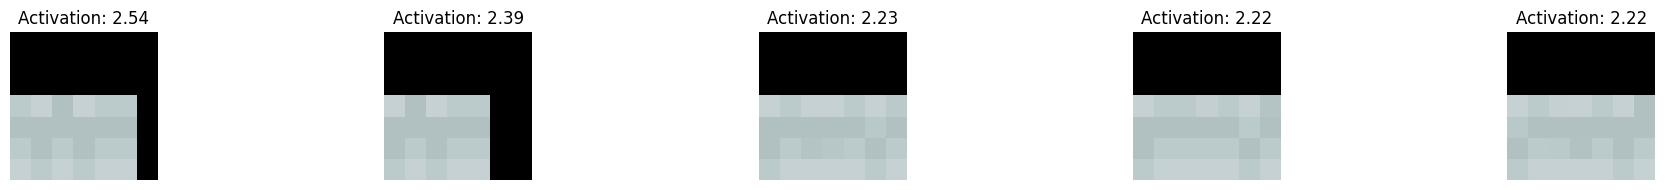

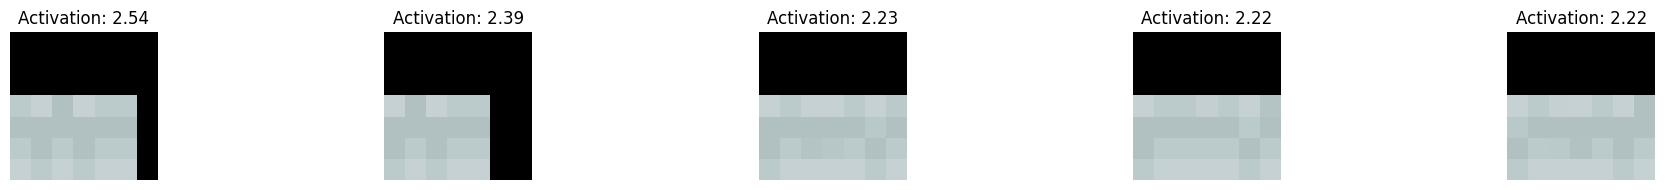

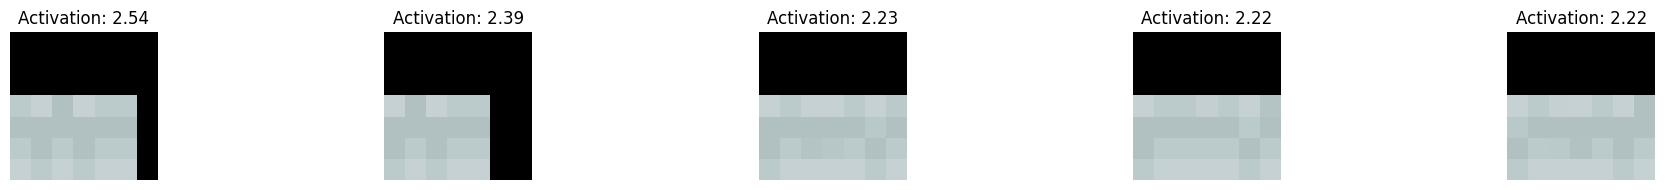

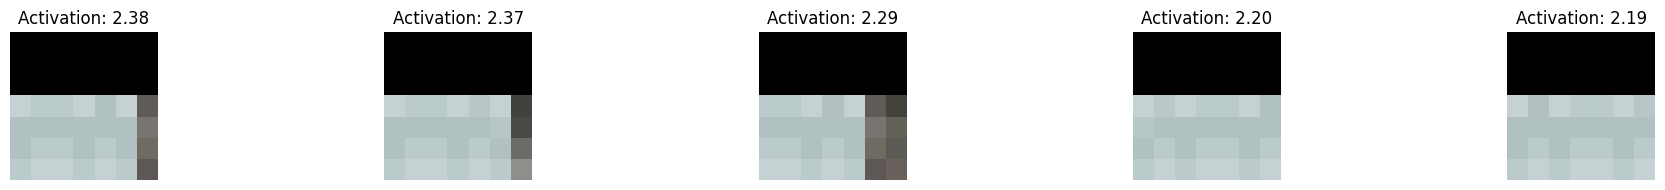

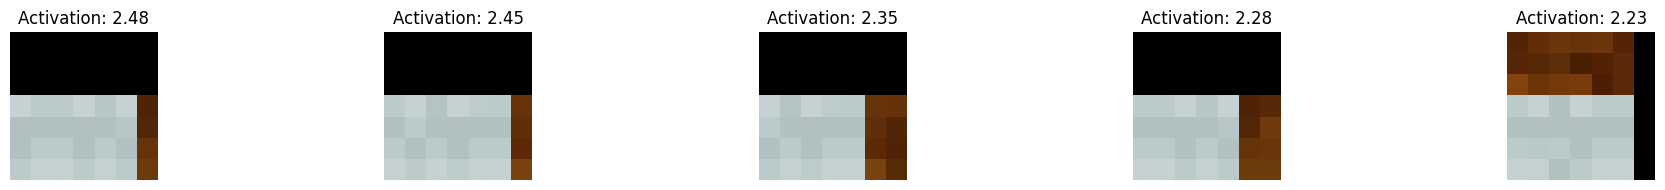

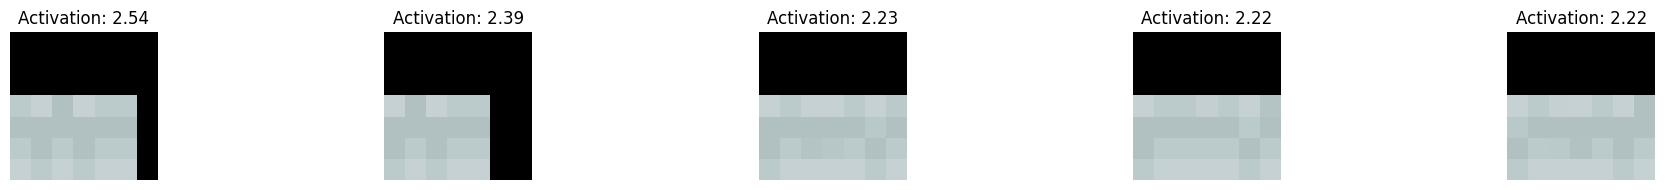

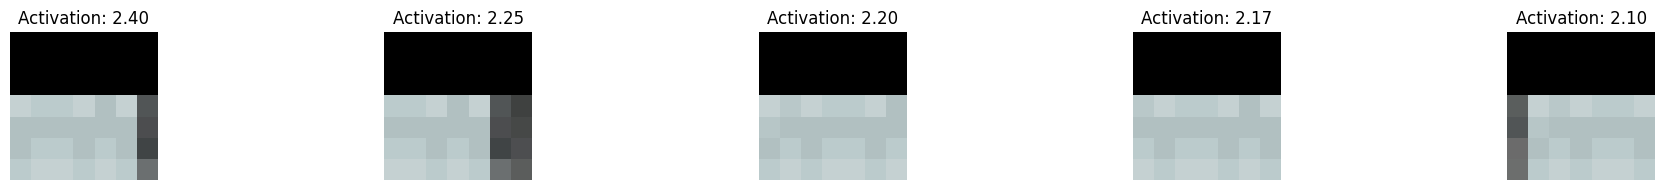

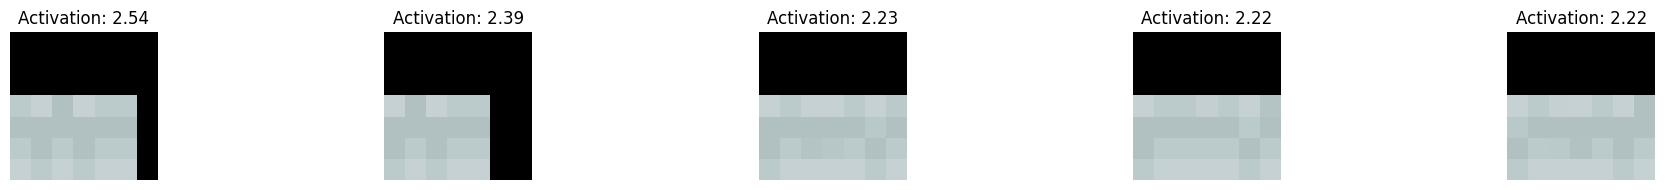

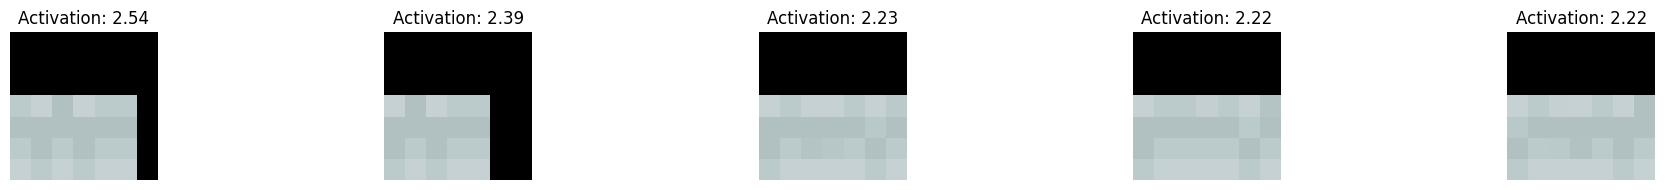

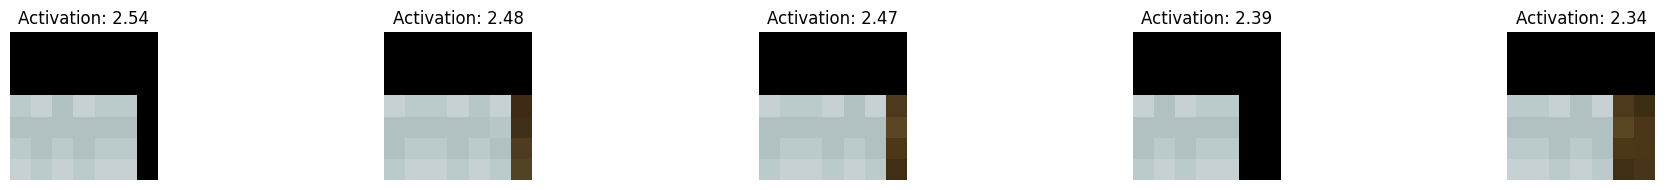

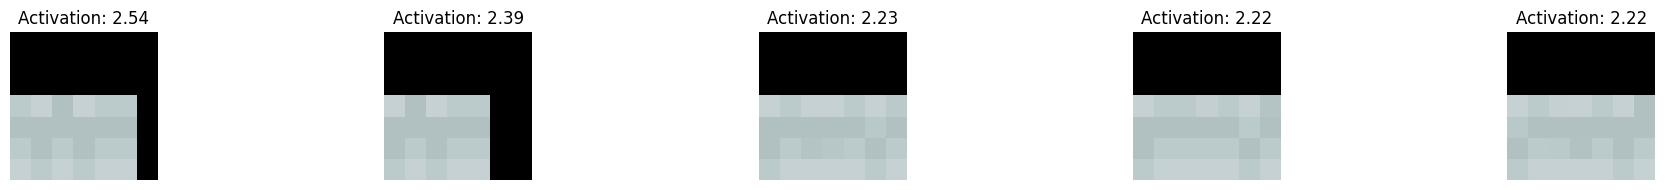

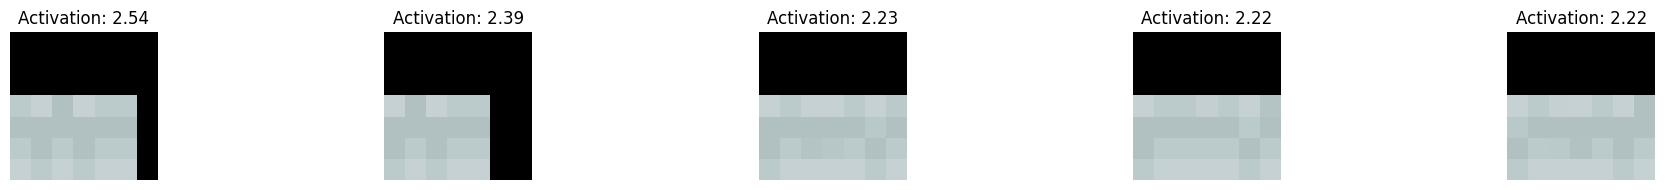

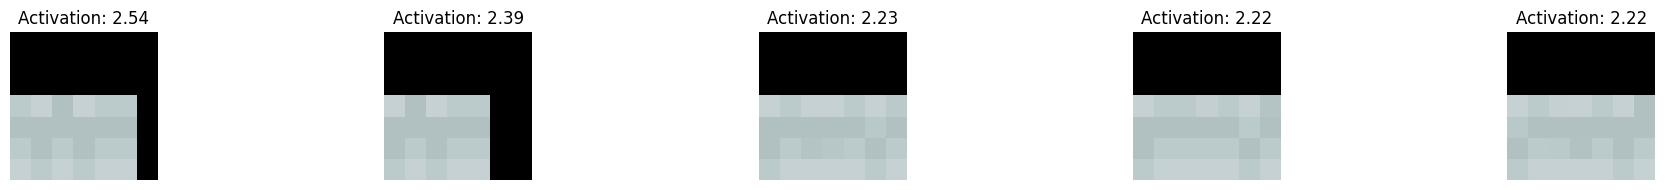

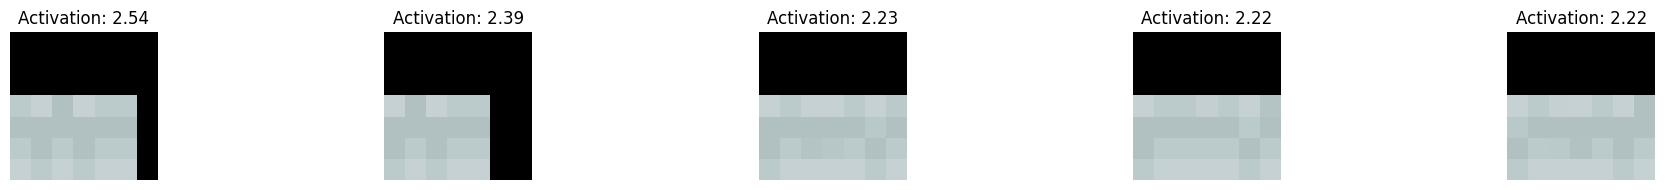

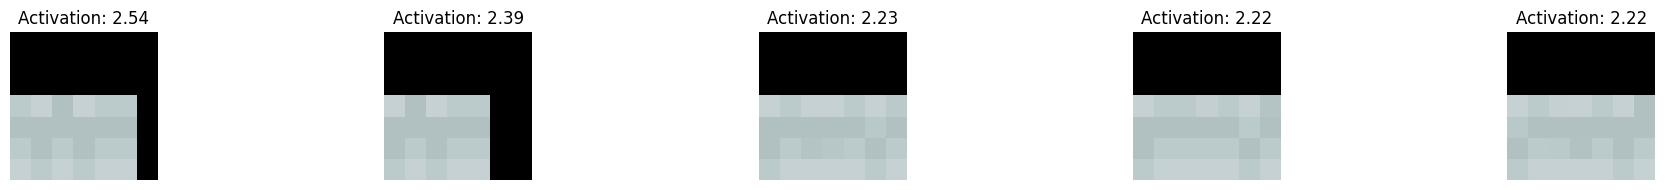

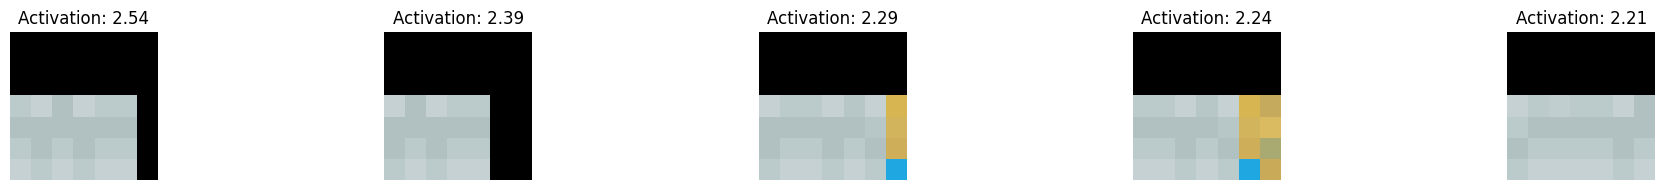

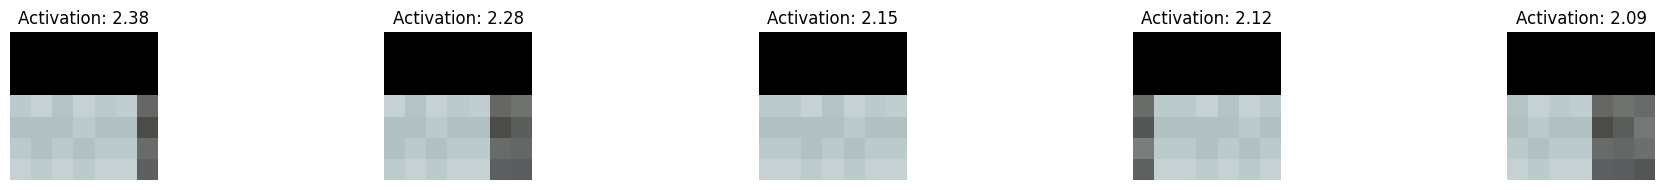

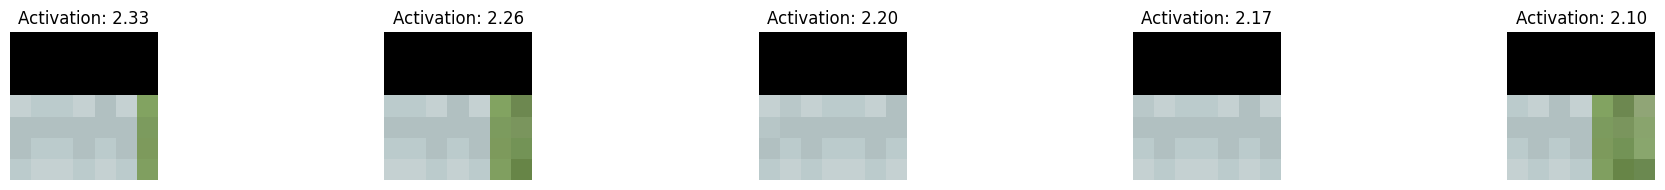

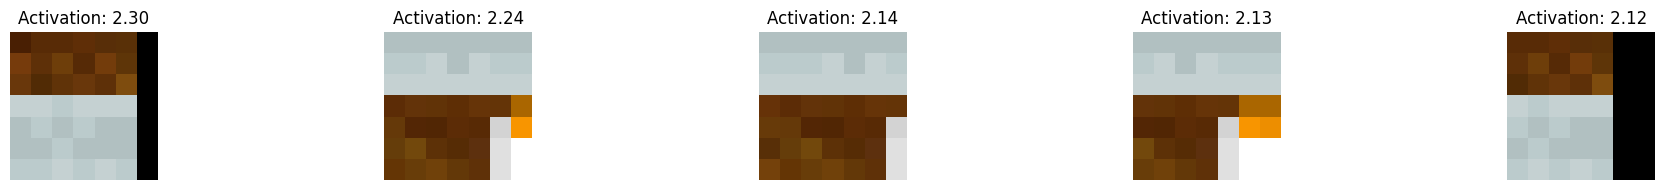

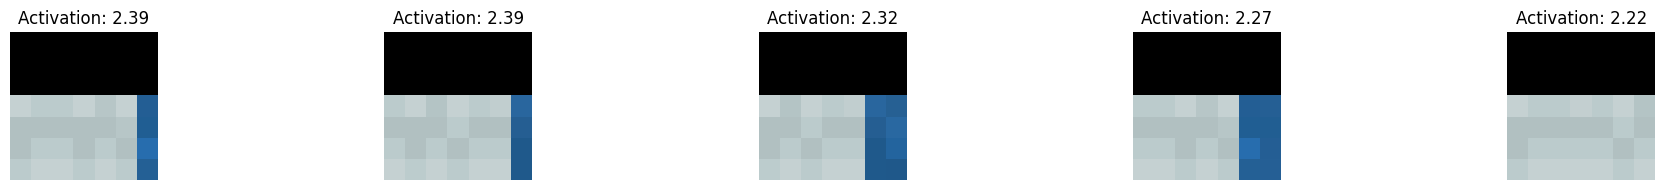

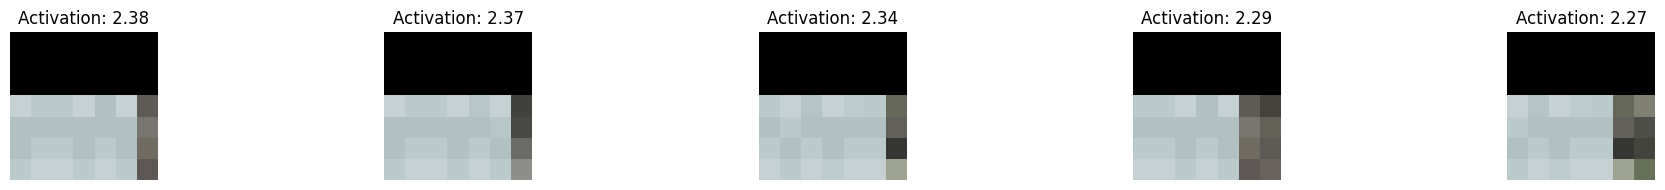

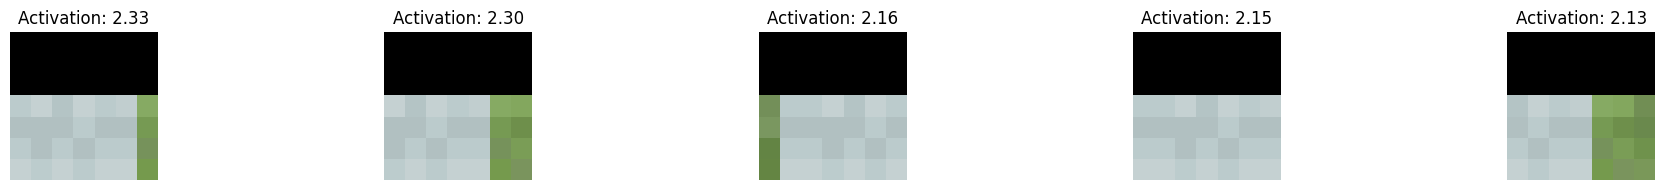

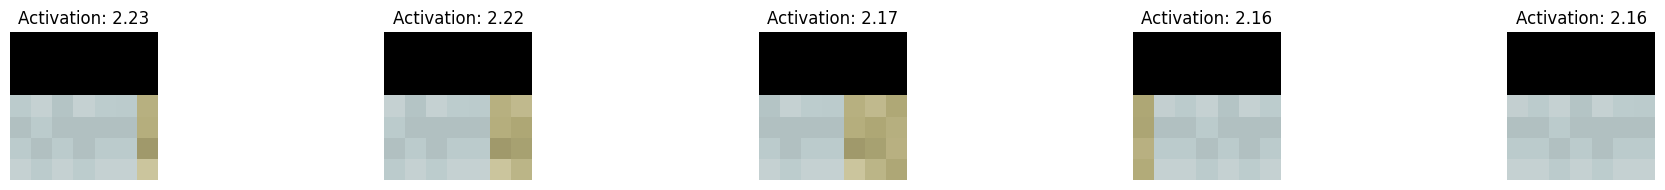

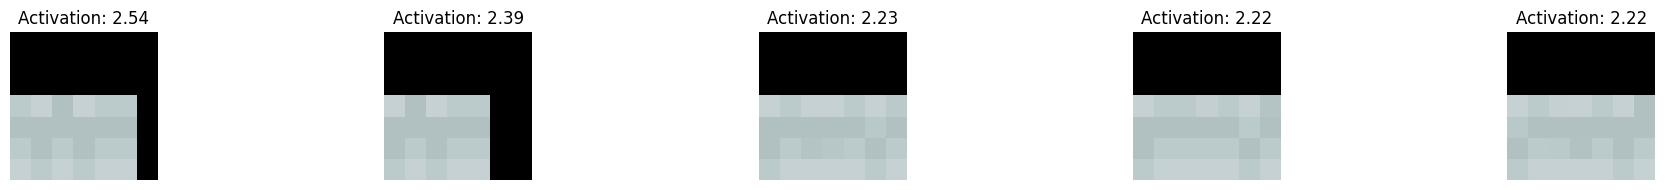

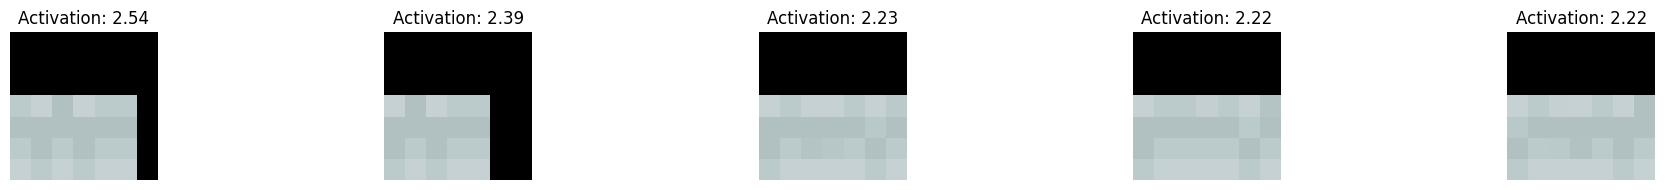

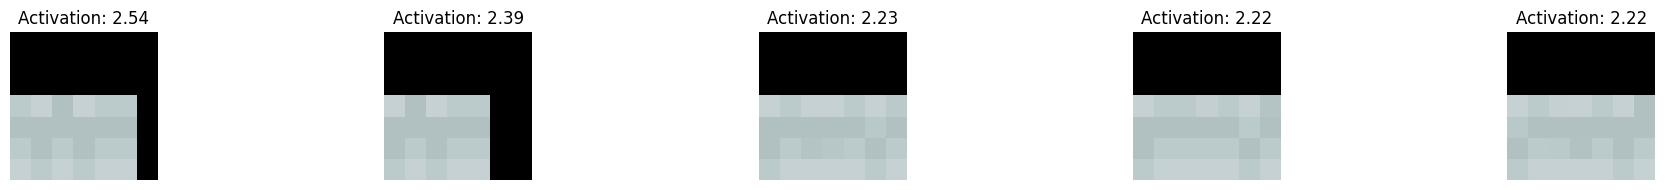

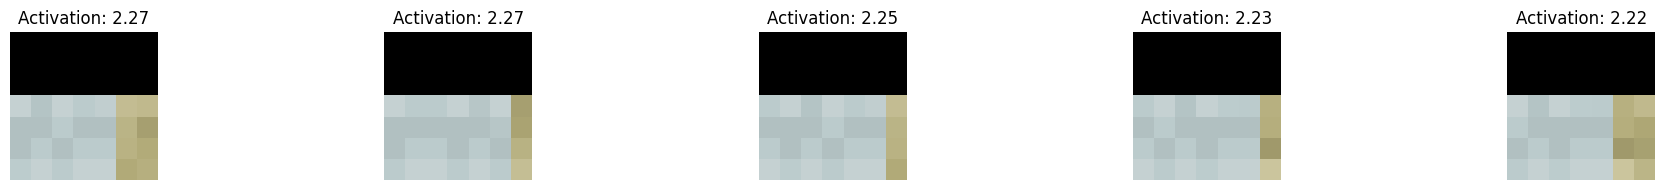

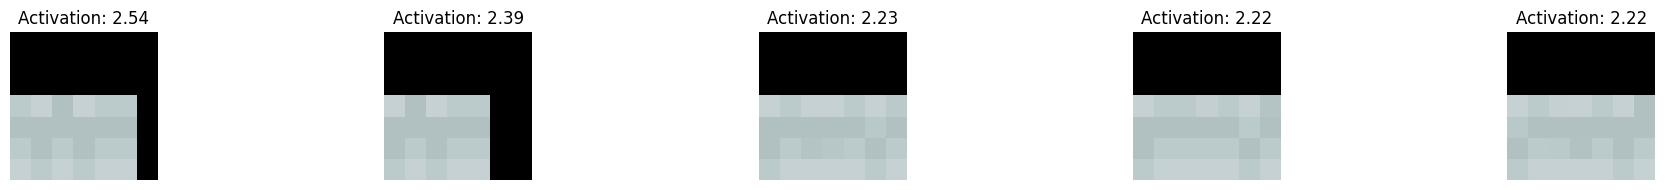

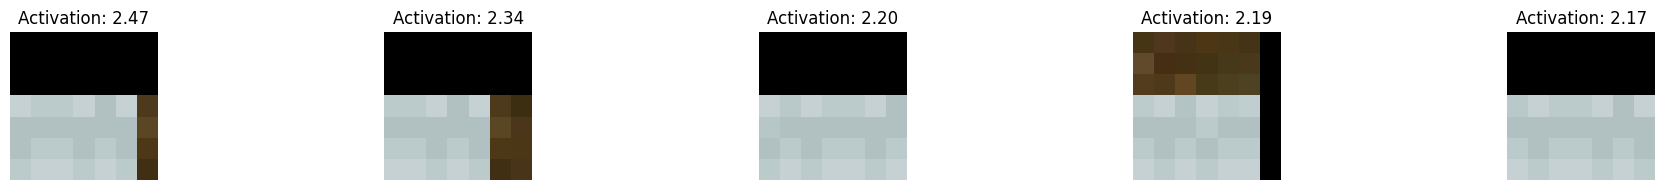

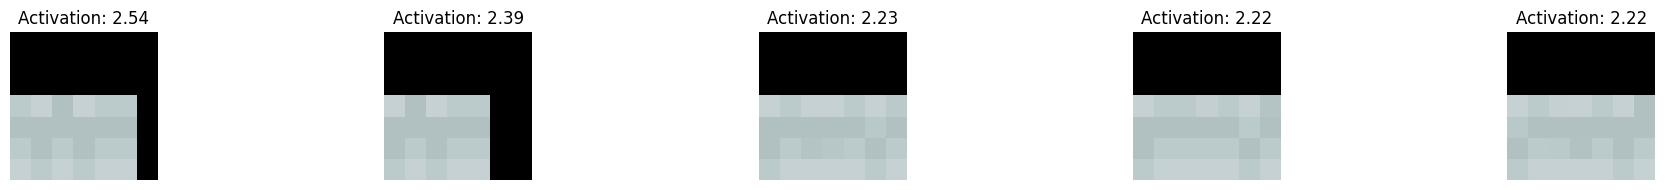

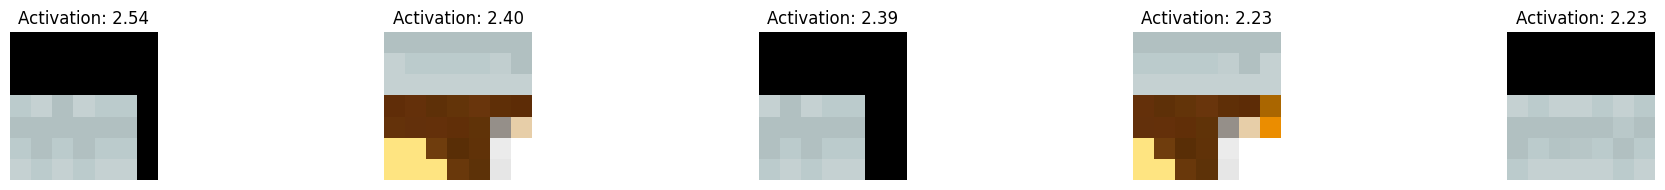

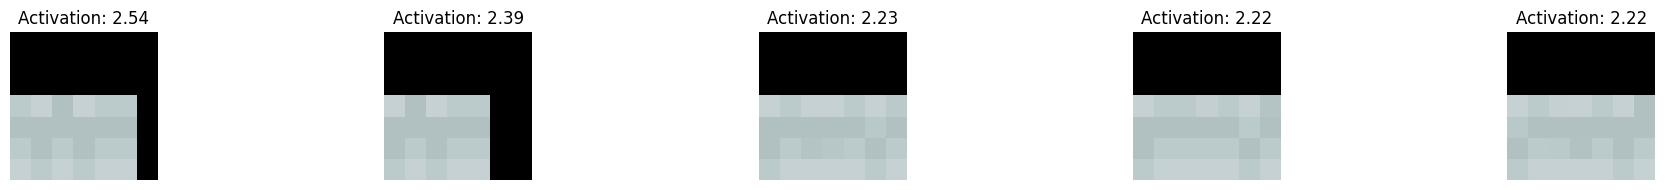

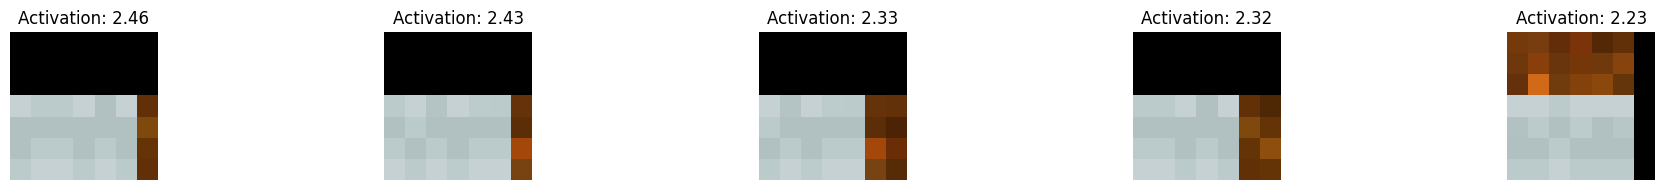

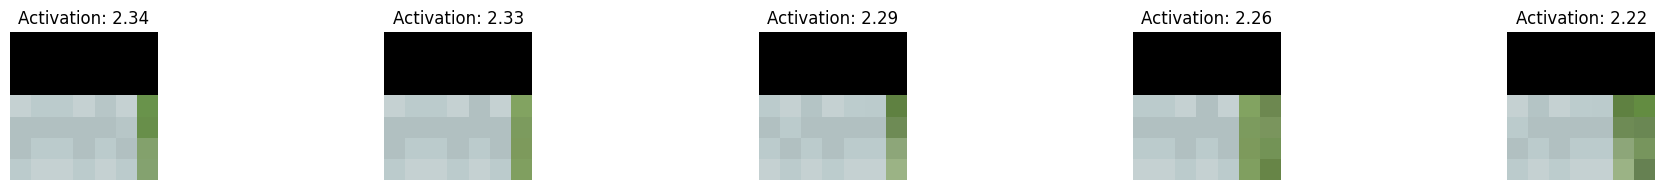

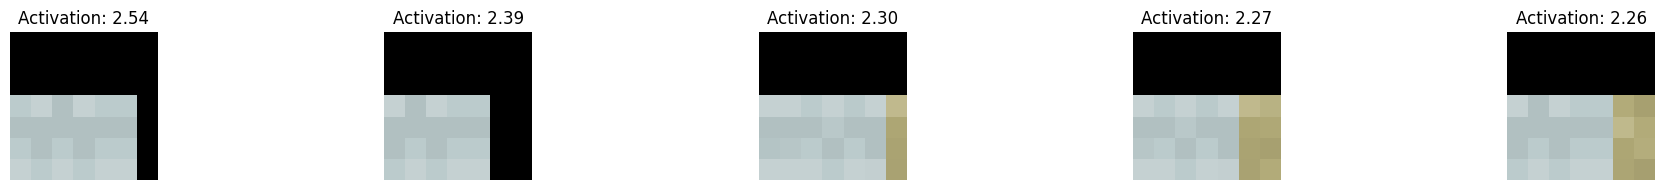

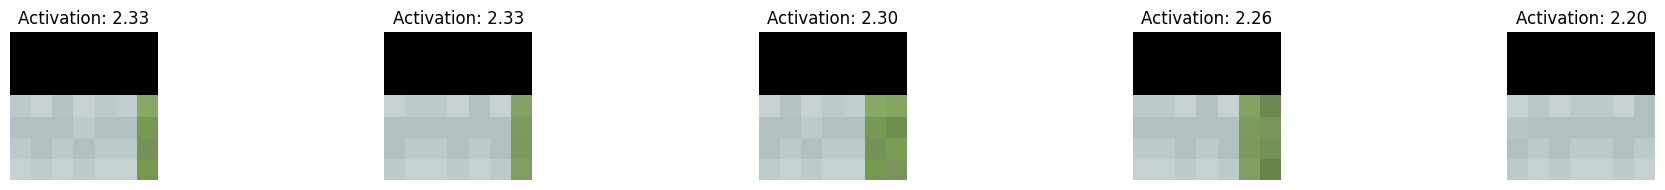

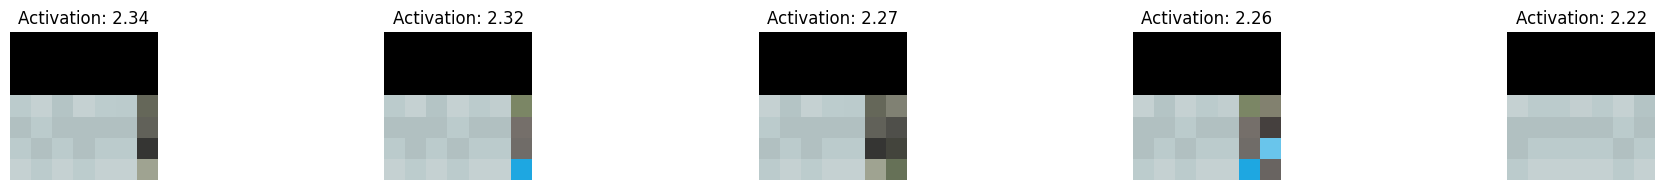

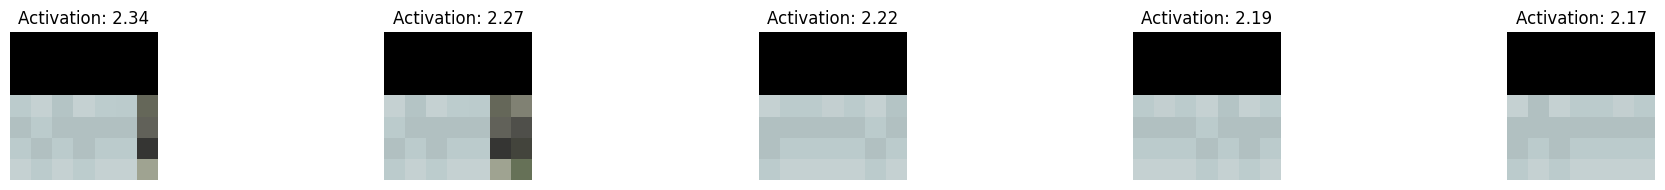

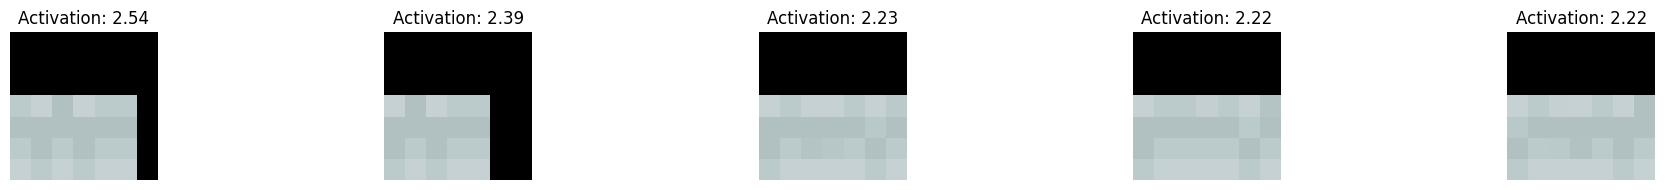

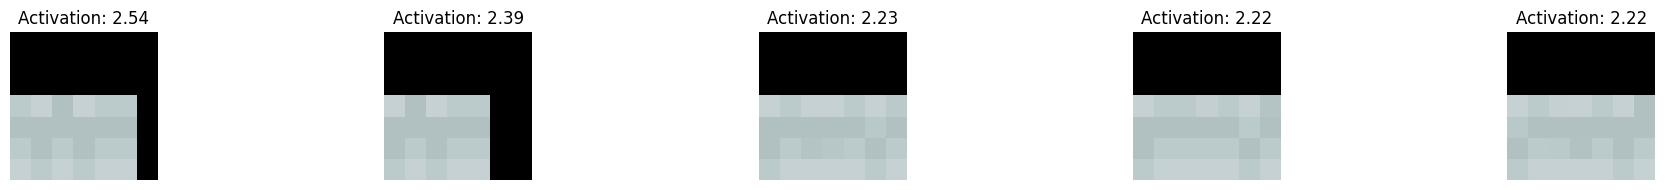

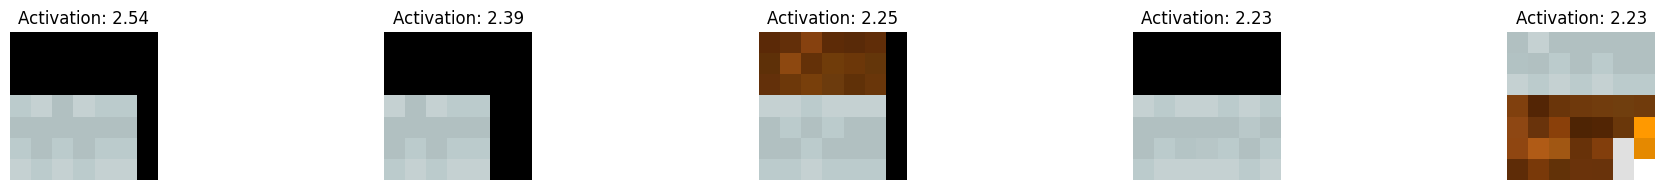

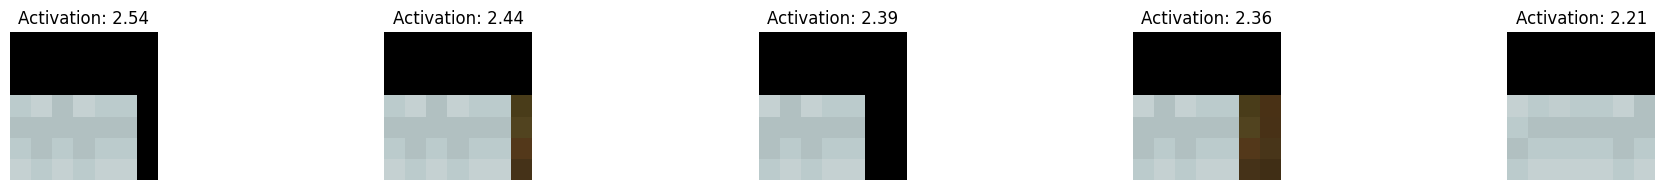

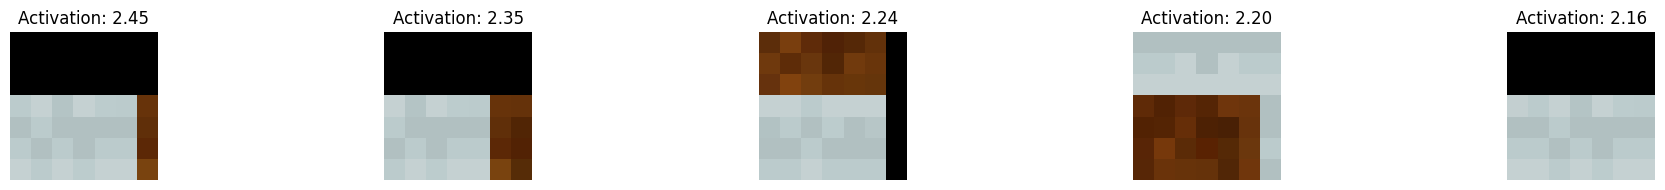

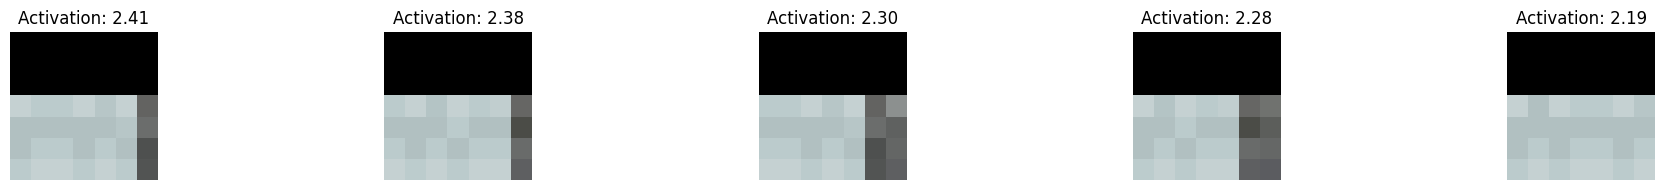

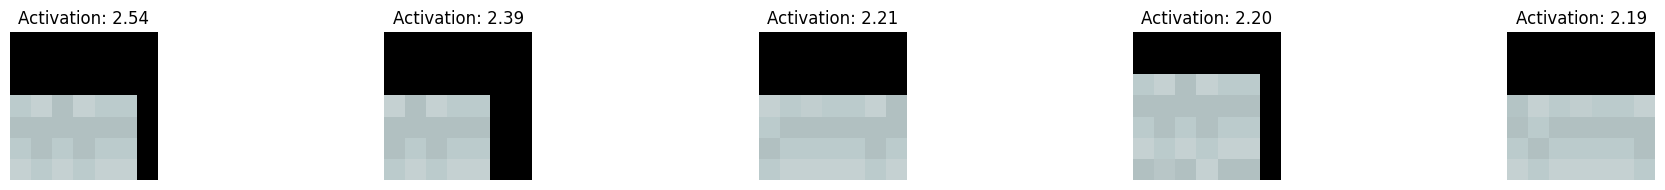

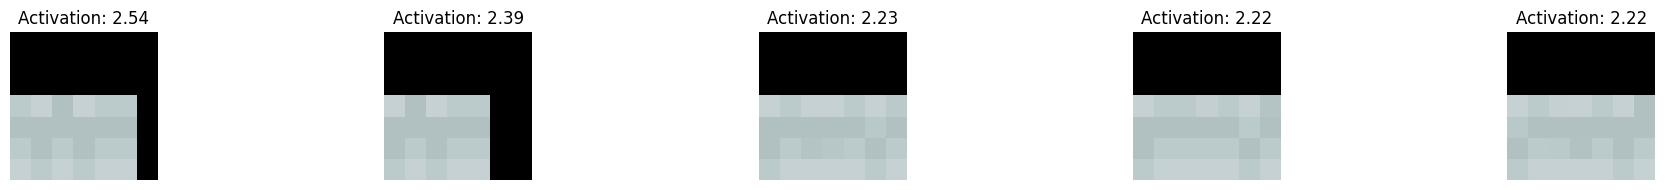

In [32]:
filter_matrix = torch.tensor(matrix[0], dtype=torch.float32)
results = top_activating_image_segments(filter_matrix, input_dataset, 3)
visualize_top_segments(results,num_segments=5)

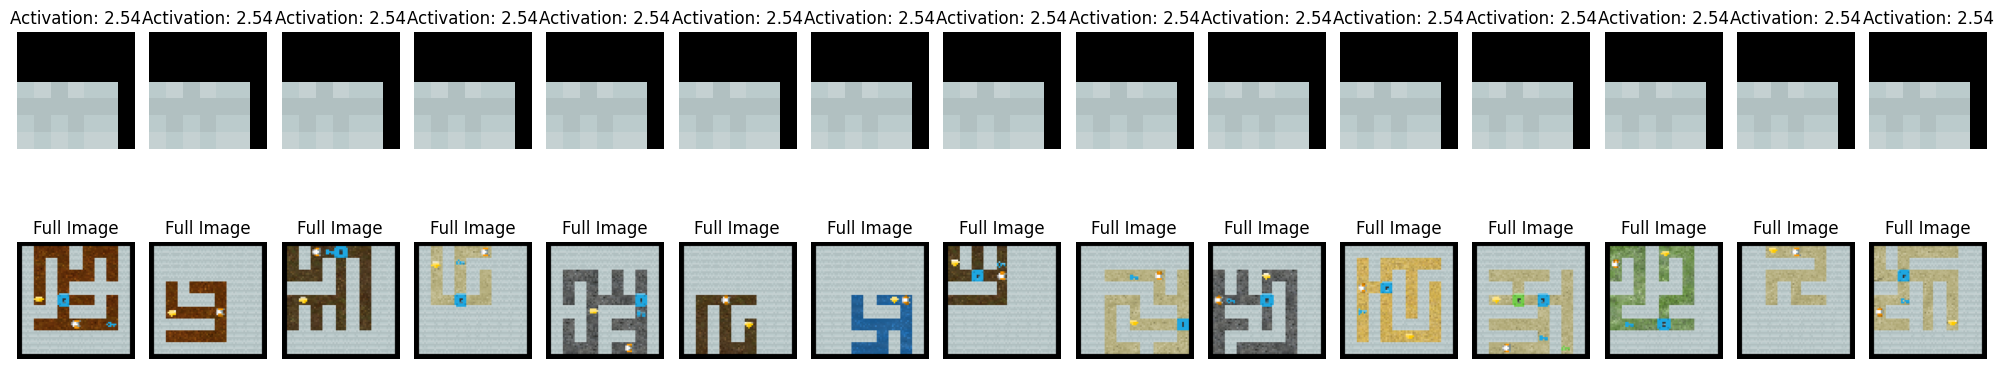

In [36]:
visualize_top_segments_with_full_images(results, num_segments=15)

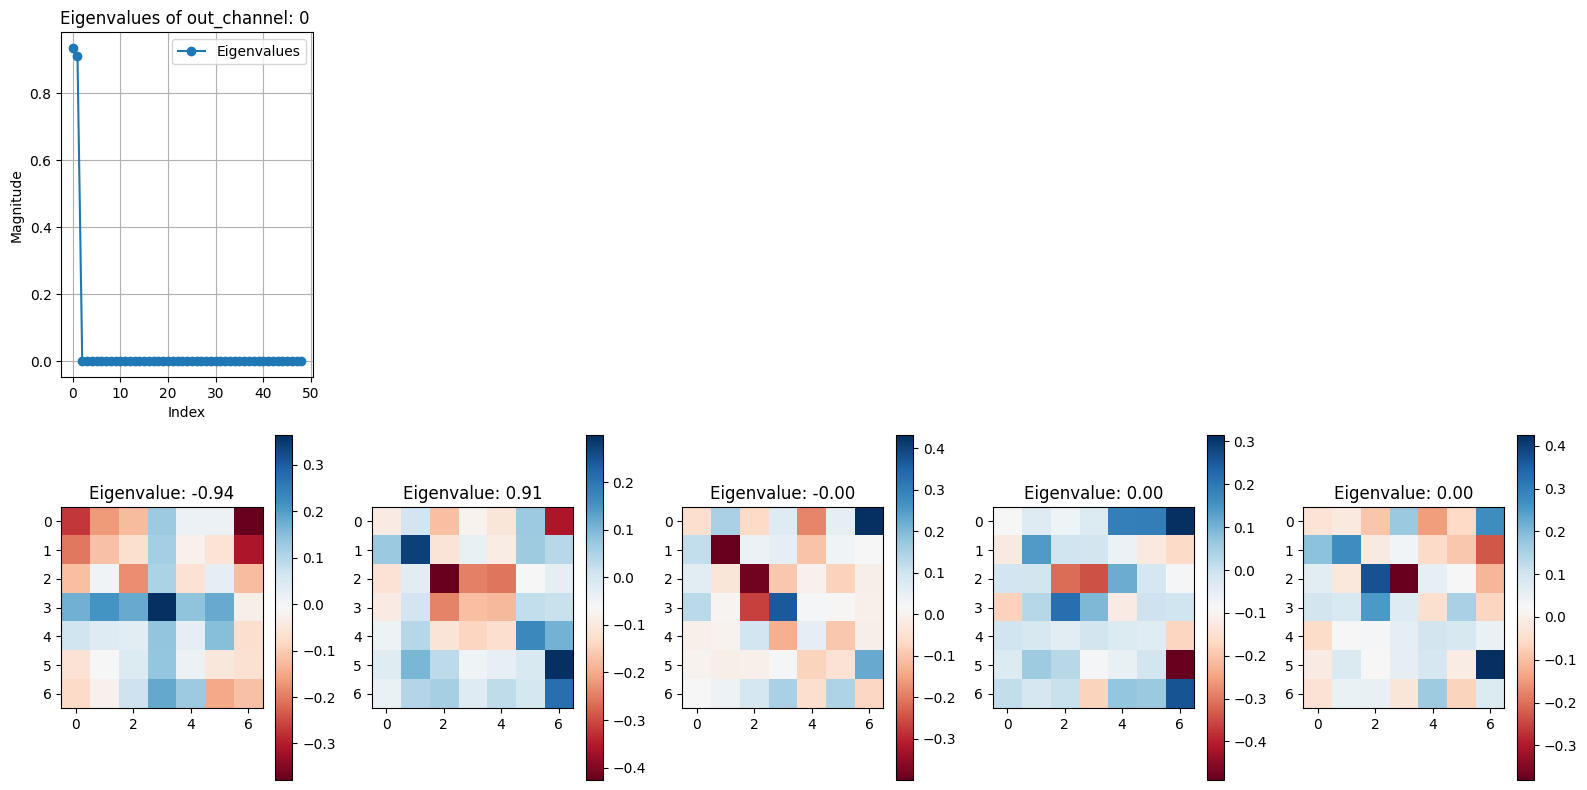

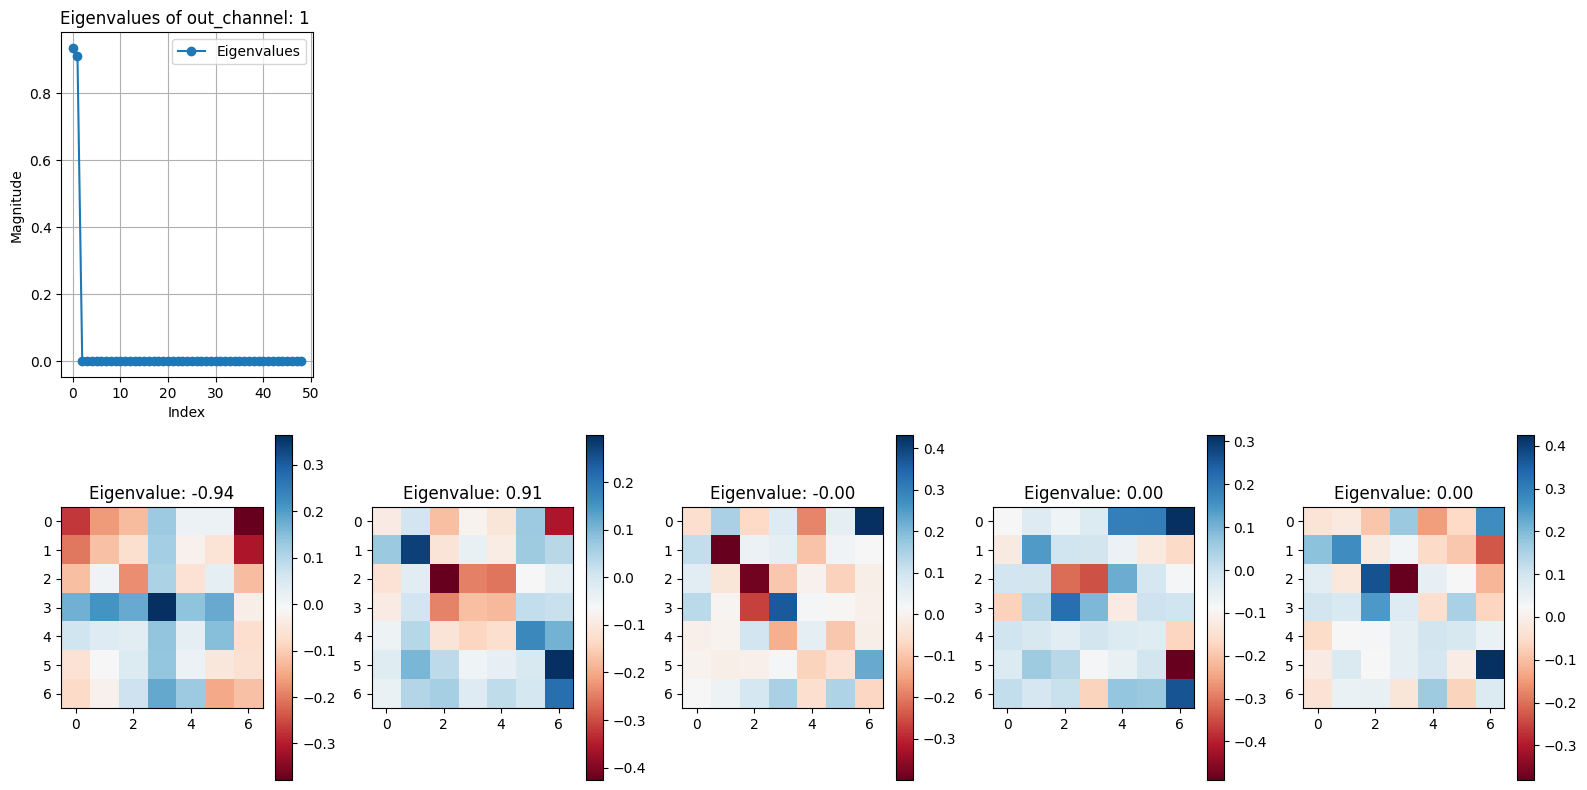

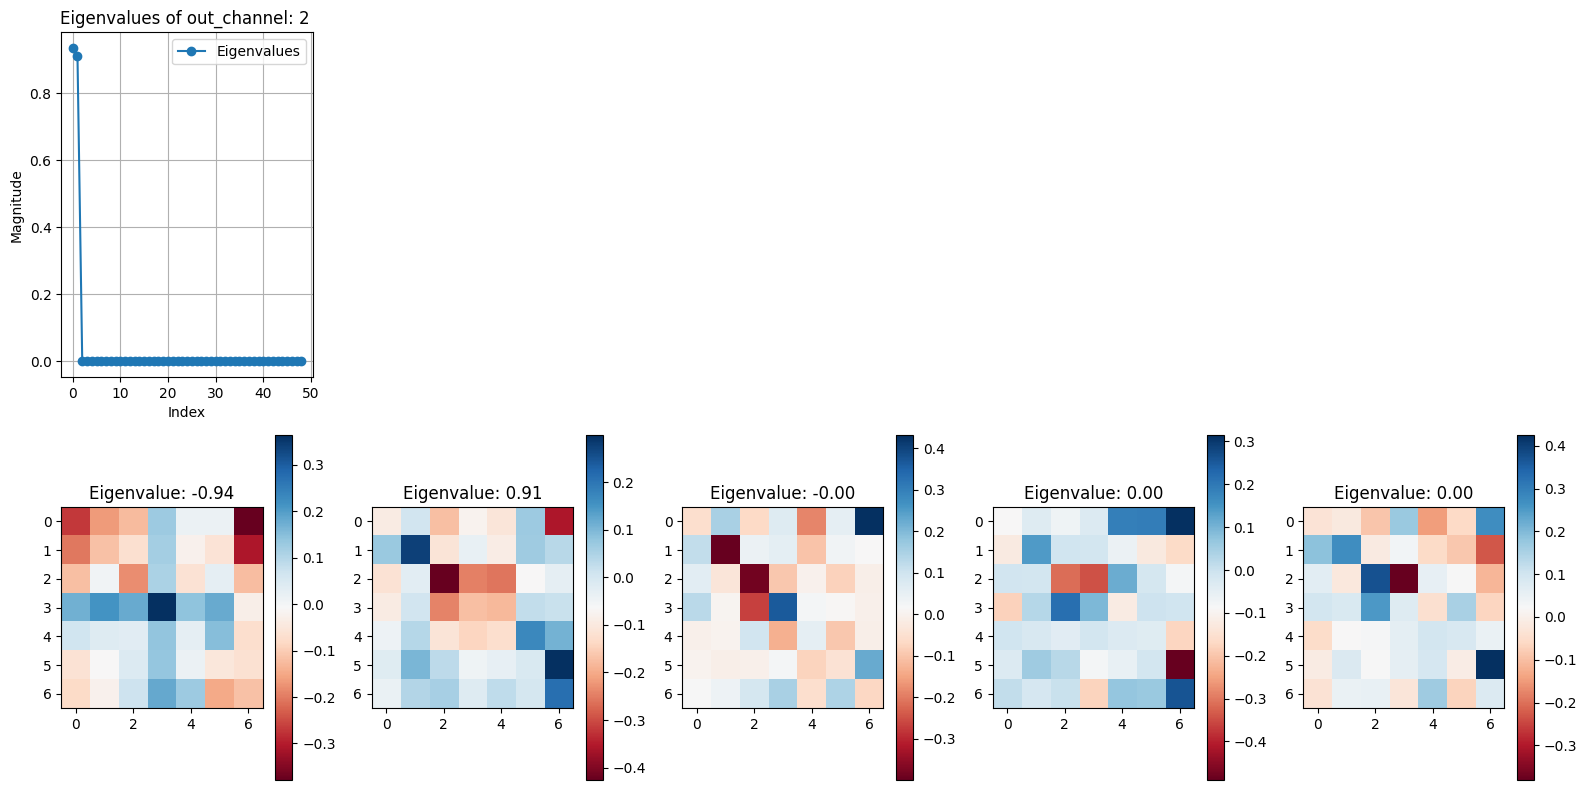

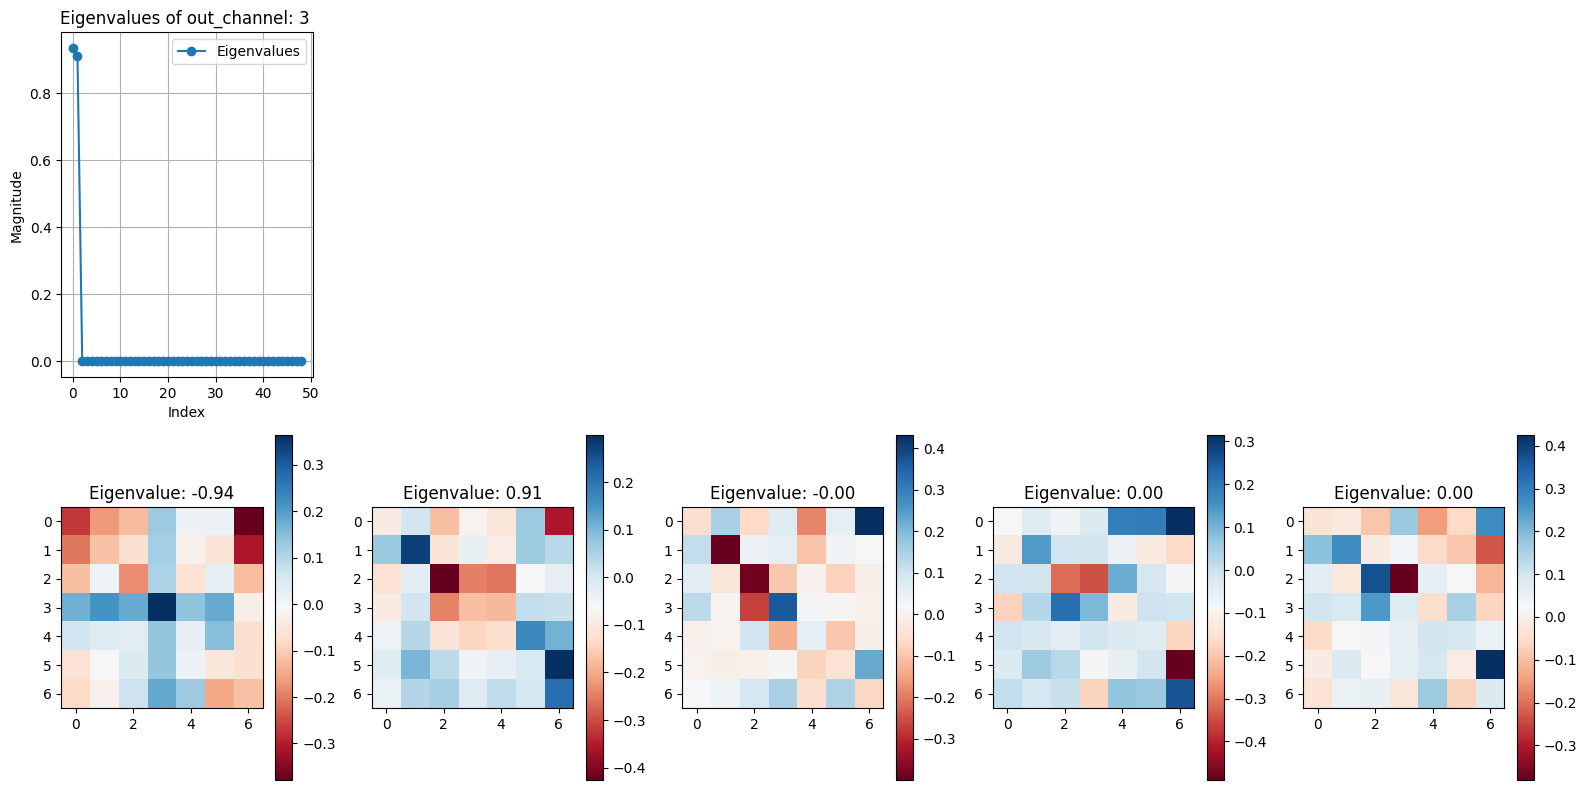

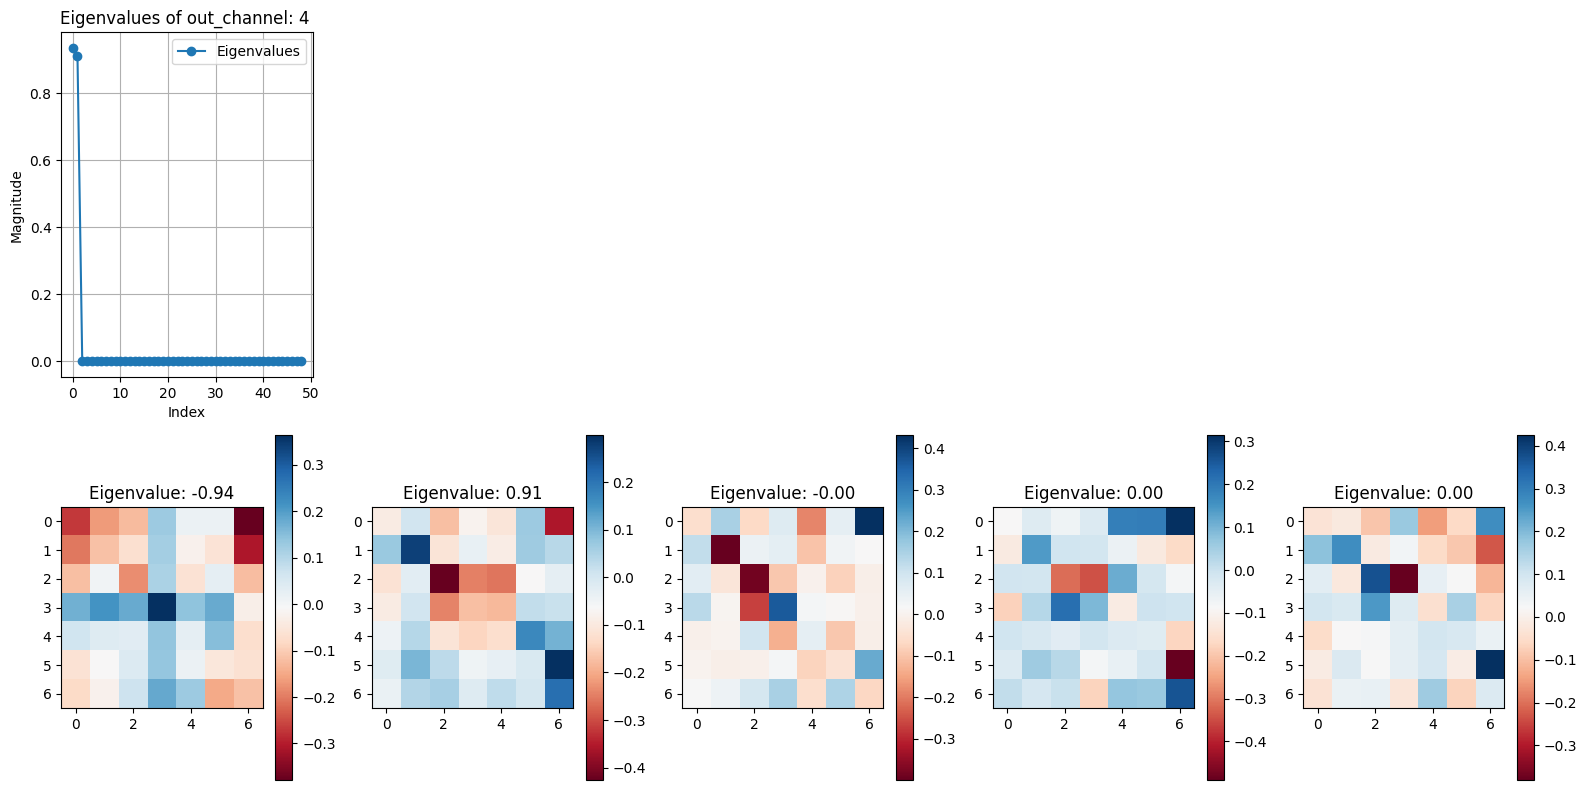

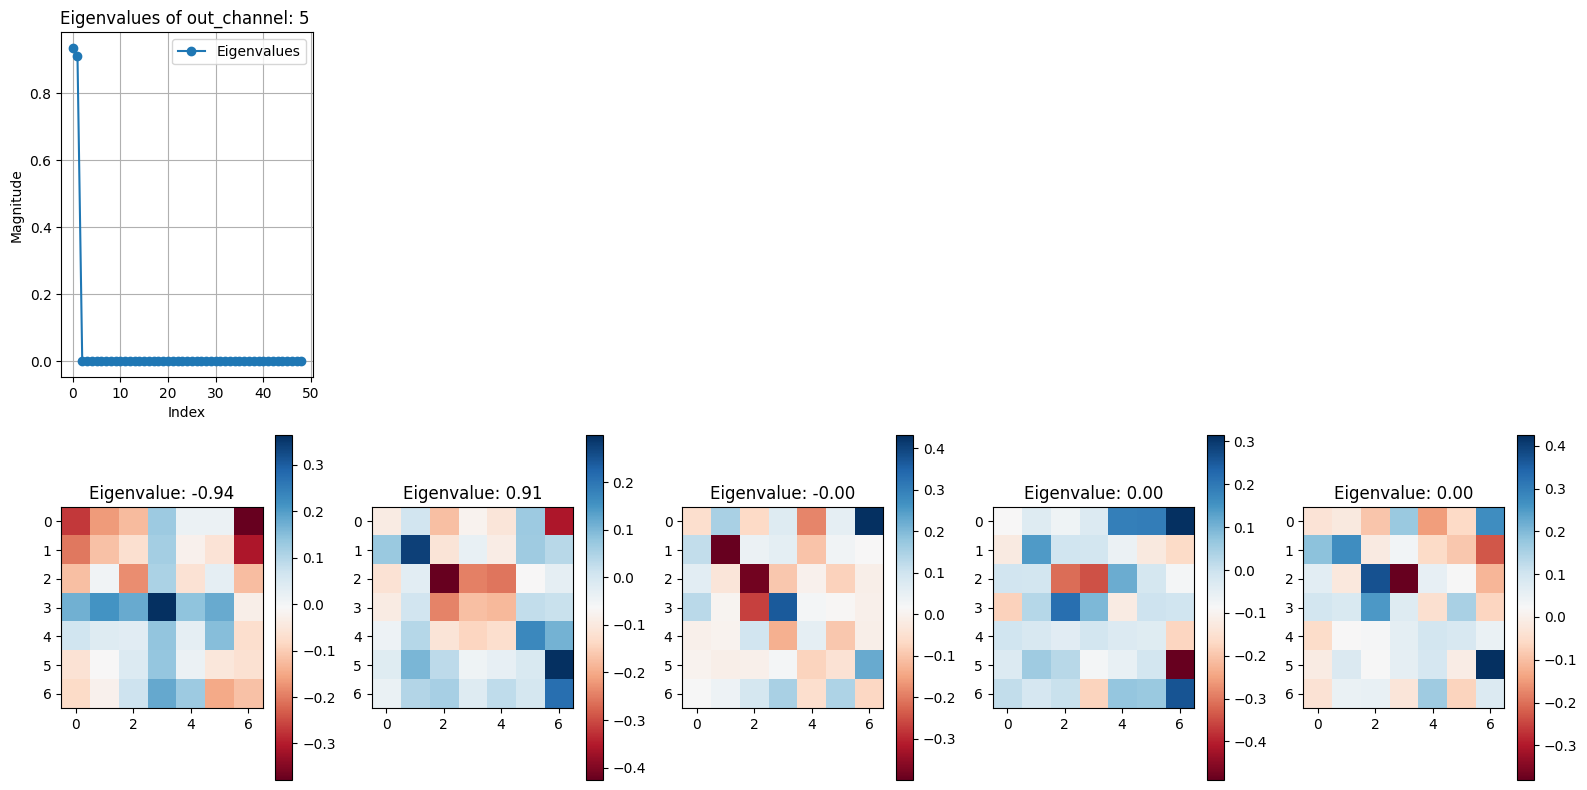

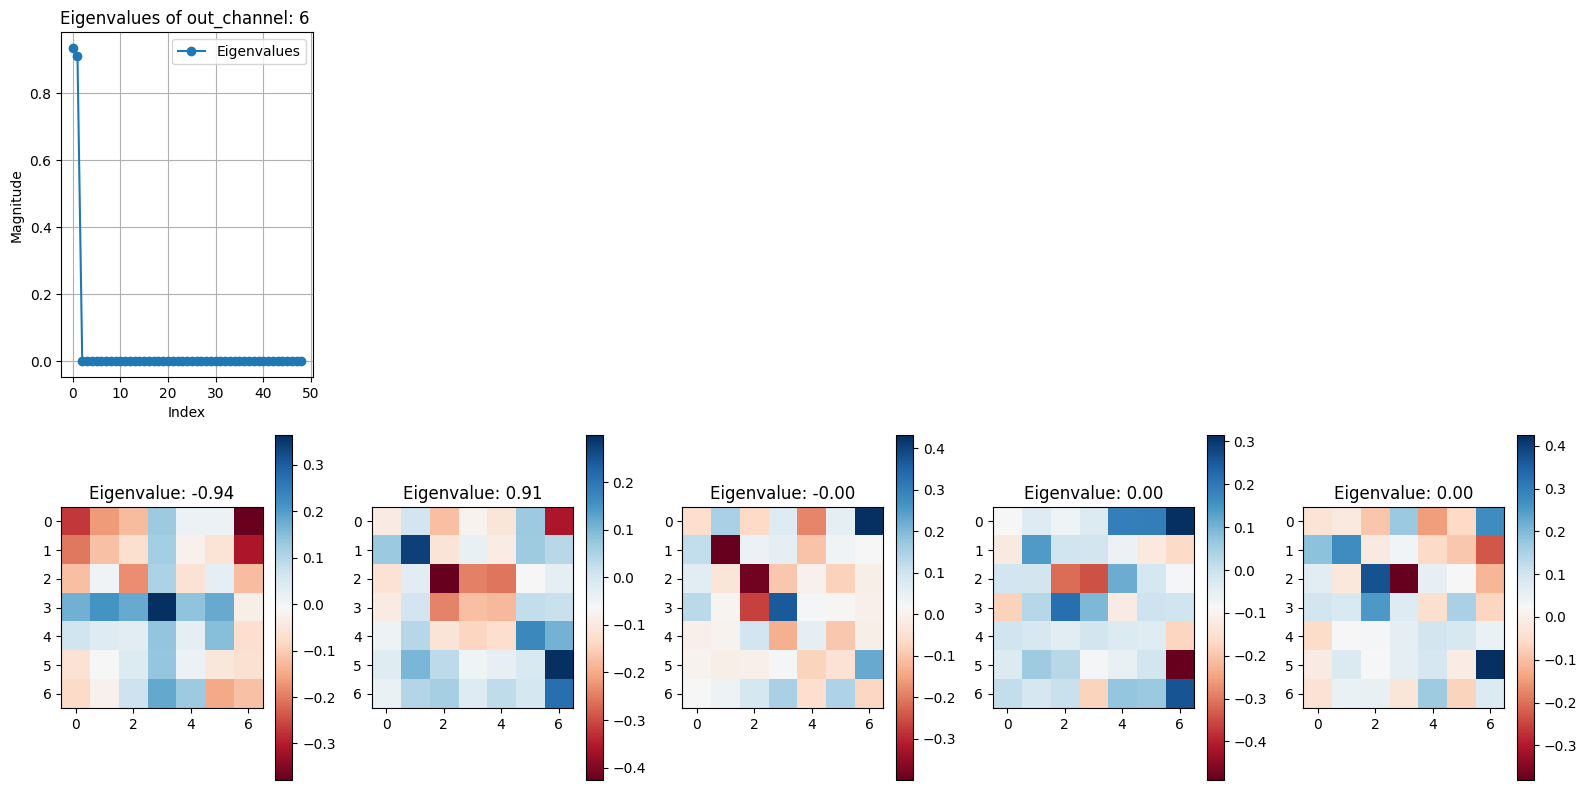

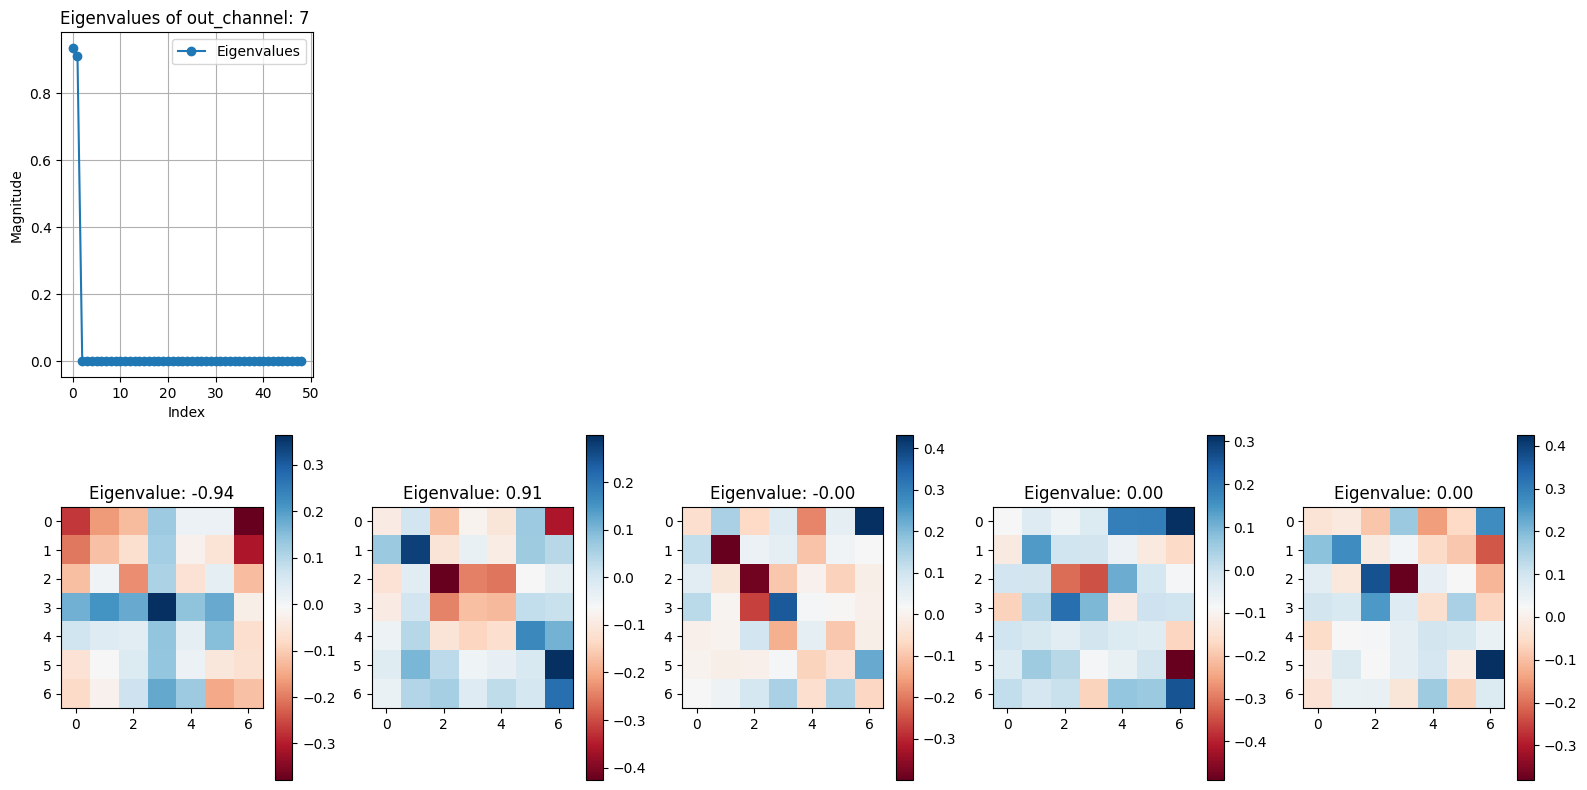

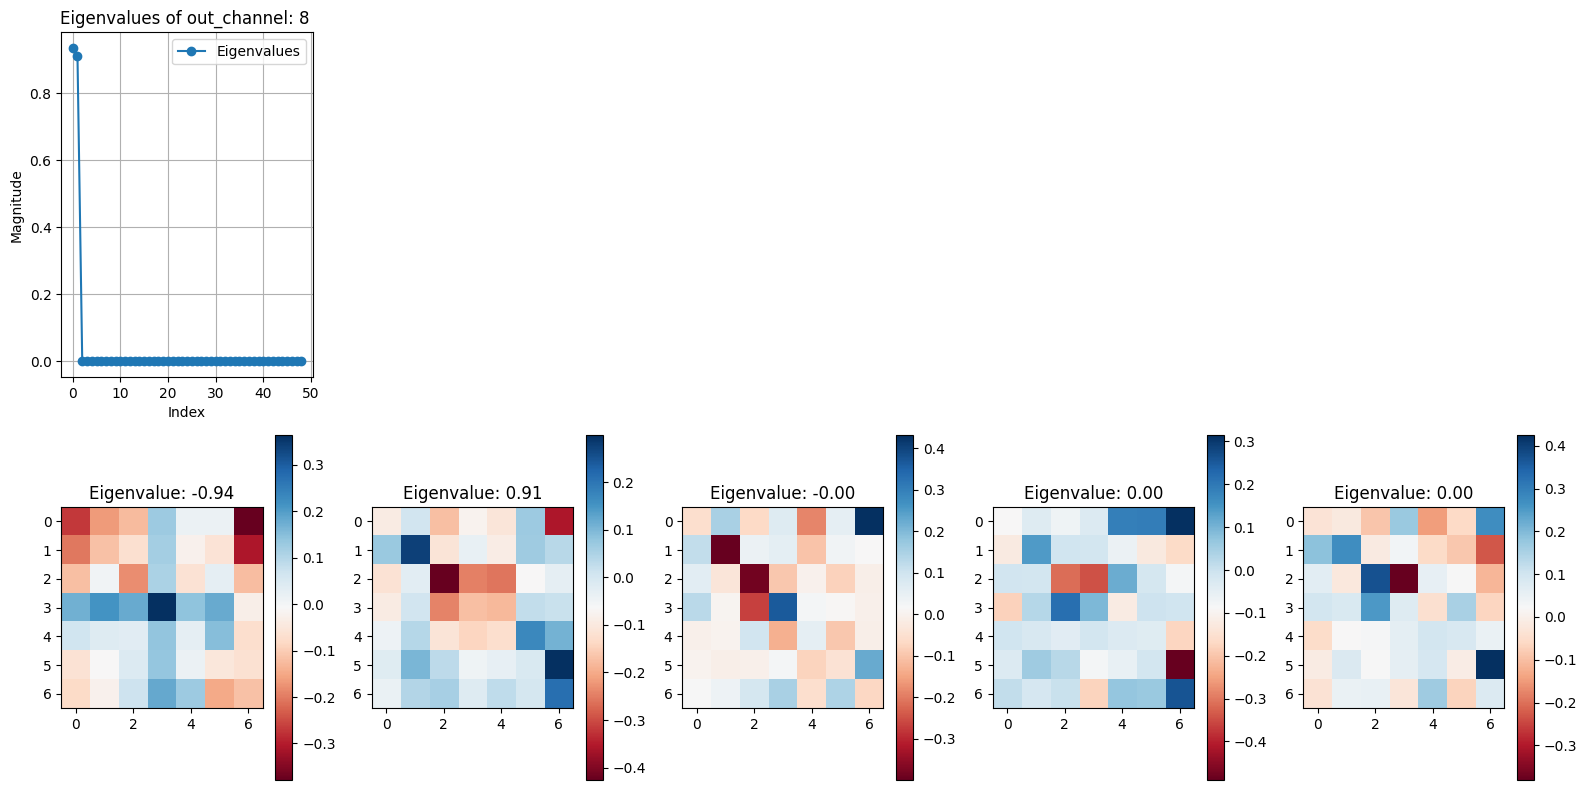

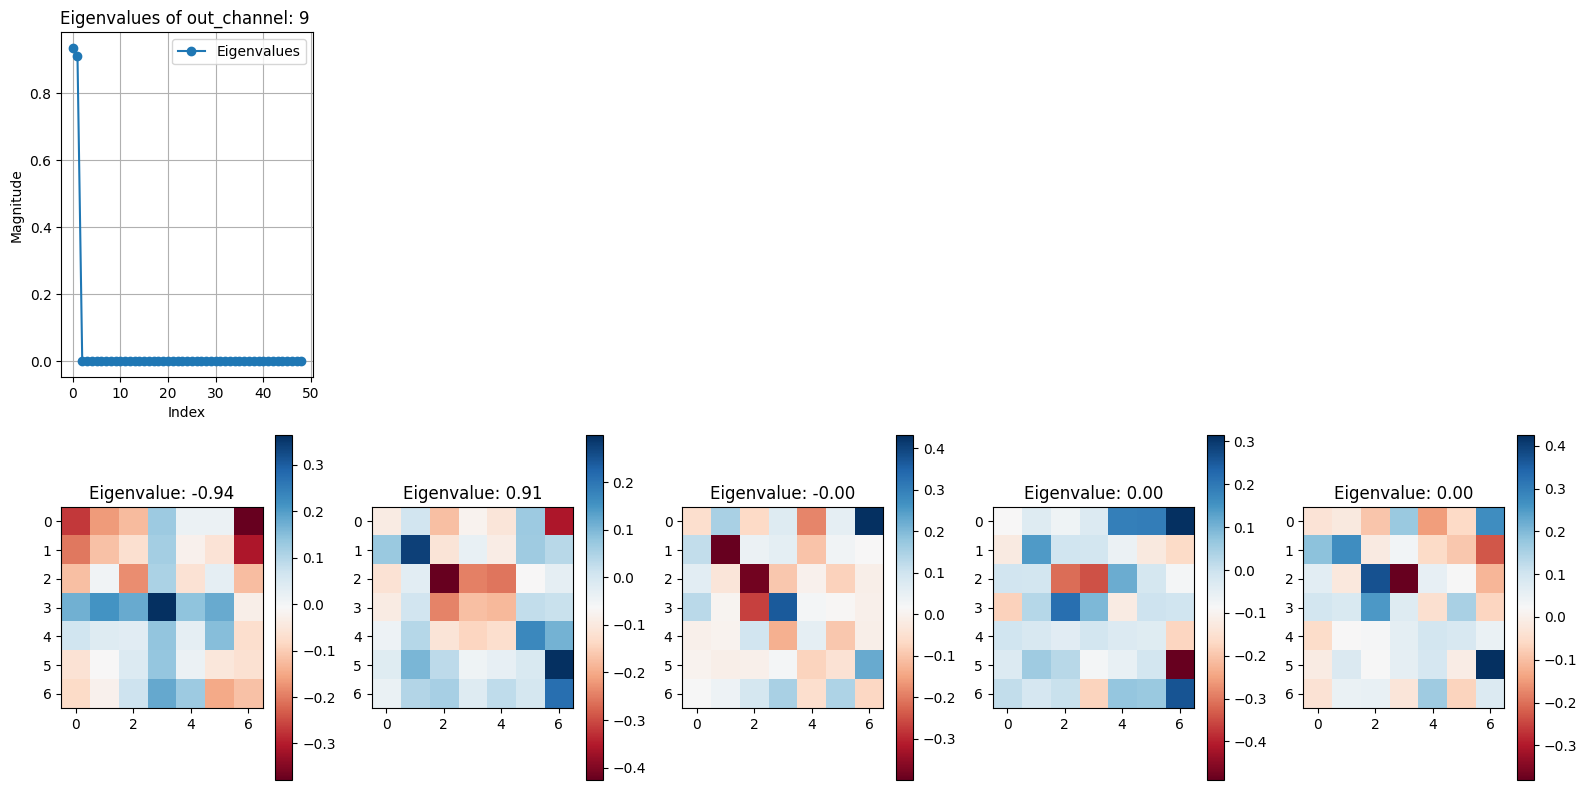

KeyboardInterrupt: 

In [37]:
filters = []
#let's save all the kernels in a list of filters in the correct format
for i in range(out_channels):
    plotter = EigenvectorPlotter(W_summed_interactions[i,:,:],7, i)
    plotter.plot()
    matrices = plotter.get_non_zero_eigenvec()
    for matrix in matrices:
        filter_matrix = torch.tensor(matrix, dtype=torch.float32)
        filters.append(filter_matrix)
    


The following section finds the maximally activating image and their segments for all filters

In [ ]:
#to find the top activating image segments for a list of filters
visualise_list_filters(input_dataset, filters,padding=3,num_segments=15)